In [1]:
# Imports
import polars as pl
pl.Config.set_fmt_str_lengths(100)
import numpy as np
import seaborn as sns
import pandas as pd
from joblib import Parallel, delayed

import matplotlib.pylab as plt
from conversions import get_file_without_path
import glob
import os
import pickle

from sklearn.feature_selection import mutual_info_regression
from scipy import signal
from scipy import stats
import random
from scipy.stats import spearmanr
import pingouin

import pandas as pd
import numpy as np
import mne
from mne.stats import permutation_cluster_test
import matplotlib.pyplot as plt


# Import data

In [33]:
hr_df = pl.DataFrame()

file_list = glob.glob("data/hr/prolific_meet_up/*/*.pickle")
for file in file_list:
    with open(file, 'rb') as f:
        data = pickle.load(f)
        file_tag = get_file_without_path(file)
        file_name = file.split("/")[-1]
        analysis     = file.split("/")[-2]
        parameters   = analysis.split("_")
        method       = parameters[0] + "_" + parameters[1]
        sid          = file_tag.split("-")[6]
        dyad         = file_tag.split("-")[9]
        user_id      = file_tag.split("-")[11]

        #Get data
        timesES = data[1]
        bpmES = np.array(data[2])

        if method == "MTTS_CAN" or method == "HR_CNN":
            roi_approach = "None"
            bpm_est      = "None"
        else:
            roi_approach = parameters[2]
            bpm_est      = parameters[3]

        if bpmES.ndim > 1:   
            bpmES = np.mean(bpmES, axis=1)
        
        if "wet" in file:
            manipulated = True
        else:
            manipulated = False

        aux_df = pl.DataFrame({
                    "sid"           : [sid]* len(timesES),
                    "user_id"       : [sid + user_id] * len(timesES) , 
                    "dyad"          : [dyad]* len(timesES),
                    "file_name"     : [file_name]* len(timesES),
                    "method"        : [method]* len(timesES),
                    "roi_approach"  : [roi_approach]* len(timesES),
                    "bpm_est"       : [bpm_est]* len(timesES),
                    "file_tag"      : [file_tag]* len(timesES),
                    "manipulated"   : [manipulated]* len(timesES),
                    "analysis"      : [analysis]* len(timesES),
                    "time"          : timesES,
                    "bpmES"         : [float(x) for x in bpmES],                    
                    })

        hr_df = hr_df.vstack(aux_df)


In [16]:
behavior_df = pl.read_csv("data/behavior/all_data_df.csv")
behavior_df = behavior_df.with_columns(
    pl.col("sid").str.replace_all(":", "").alias("sid"),
    pl.col("user_id").str.replace_all(":", "").alias("user_id"),
    pl.col("other_id").str.replace_all(":", "").alias("other_id")
)

In [35]:
all_data_df = behavior_df.join(hr_df, on=["user_id", "sid", "dyad"])
all_data_df.head()

shape: (5, 19)
┌─────┬───────┬────────────────────┬──────┬───┬─────────────┬───────────────────┬──────┬───────────┐
│     ┆ index ┆ sid                ┆ dyad ┆ … ┆ manipulated ┆ analysis          ┆ time ┆ bpmES     │
│ --- ┆ ---   ┆ ---                ┆ ---  ┆   ┆ ---         ┆ ---               ┆ ---  ┆ ---       │
│ i64 ┆ i64   ┆ str                ┆ str  ┆   ┆ bool        ┆ str               ┆ f32  ┆ f64       │
╞═════╪═══════╪════════════════════╪══════╪═══╪═════════════╪═══════════════════╪══════╪═══════════╡
│ 664 ┆ 664   ┆ mkreal_meeting_exp ┆ p4p7 ┆ … ┆ false       ┆ cupy_POS_holistic ┆ 4.0  ┆ 51.855469 │
│     ┆       ┆ eriment_prolific5  ┆      ┆   ┆             ┆ _median           ┆      ┆           │
│ 665 ┆ 665   ┆ mkreal_meeting_exp ┆ p4p7 ┆ … ┆ false       ┆ cupy_POS_holistic ┆ 4.0  ┆ 51.855469 │
│     ┆       ┆ eriment_prolific5  ┆      ┆   ┆             ┆ _median           ┆      ┆           │
│ 666 ┆ 666   ┆ mkreal_meeting_exp ┆ p4p7 ┆ … ┆ false       ┆ cupy_POS_holistic ┆ 4.0  ┆ 51.855469 │
│     ┆       ┆ eriment_prolific5  ┆      ┆   ┆             ┆ _median           ┆      ┆           │
│ 667 ┆ 667   ┆ mkreal_meeting_exp ┆ p4p7 ┆ … ┆ false       ┆ cupy_POS_holistic ┆ 4.0  ┆ 51.855469 │
│     ┆       ┆ eriment_prolific5  ┆      ┆   ┆             ┆ _median           ┆      ┆           │
│ 664 ┆ 664   ┆ mkreal_meeting_exp ┆ p4p7 ┆ … ┆ false       ┆ cupy_POS_holistic ┆ 5.0  ┆ 58.886719 │
│     ┆       ┆ eriment_prolific5  ┆      ┆   ┆             ┆ _median           ┆      ┆           │
└─────┴───────┴────────────────────┴──────┴───┴─────────────┴───────────────────┴──────┴───────────┘

In [36]:
#all_data_df
np.unique(all_data_df["method"])

array(['HR_CNN', 'MTTS_CAN', 'cpu_GREEN', 'cpu_ICA', 'cpu_LGI',
       'cpu_OMIT', 'cpu_PBV', 'cpu_PCA', 'cupy_CHROM', 'cupy_POS'],
      dtype='<U10')

In [37]:
all_data_df.group_by(["sid", "user_id", "dyad"]).count()

/var/folders/g5/mqbcmmn575z0s3c021r942c80000gp/T/ipykernel_62454/3656778895.py:1: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.
  all_data_df.group_by(["sid", "user_id", "dyad"]).count()


shape: (194, 4)
┌─────────────────────────────────────┬───────────────────────────────────────┬──────┬───────┐
│ sid                                 ┆ user_id                               ┆ dyad ┆ count │
│ ---                                 ┆ ---                                   ┆ ---  ┆ ---   │
│ str                                 ┆ str                                   ┆ str  ┆ u32   │
╞═════════════════════════════════════╪═══════════════════════════════════════╪══════╪═══════╡
│ mkreal_meeting_experiment_prolific5 ┆ mkreal_meeting_experiment_prolific5p7 ┆ p4p7 ┆ 34960 │
│ mkreal_meeting_experiment_prolific2 ┆ mkreal_meeting_experiment_prolific2p3 ┆ p3p5 ┆ 34968 │
│ mkprolific_participant_real_22      ┆ mkprolific_participant_real_22p4      ┆ p4p5 ┆ 34896 │
│ mkreal_meeting_experiment_prolific4 ┆ mkreal_meeting_experiment_prolific4p1 ┆ p1p5 ┆ 34900 │
│ mkreal_meeting_experiment_prolific6 ┆ mkreal_meeting_experiment_prolific6p3 ┆ p3p5 ┆ 34528 │
│ …                                   ┆ …                                     ┆ …    ┆ …     │
│ mkprolific_participant_real_22      ┆ mkprolific_participant_real_22p5      ┆ p2p5 ┆ 34900 │
│ mkreal_meeting_experiment_prolific5 ┆ mkreal_meeting_experiment_prolific5p7 ┆ p3p7 ┆ 34832 │
│ mkreal_meeting_experiment_prolific2 ┆ mkreal_meeting_experiment_prolific2p8 ┆ p4p8 ┆ 34832 │
│ mkprolific_participant_real_32      ┆ mkprolific_participant_real_32p5      ┆ p4p5 ┆ 34960 │
│ mkreal_meeting_experiment_prolific2 ┆ mkreal_meeting_experiment_prolific2p6 ┆ p3p6 ┆ 34896 │
└─────────────────────────────────────┴───────────────────────────────────────┴──────┴───────┘

In [38]:
all_data_df.write_csv("data/hr_computed/hr.csv")

# Analysis

In [70]:
all_data_df = pl.read_csv("data/hr_computed/hr.csv")

In [71]:
#all_data_df
np.unique(all_data_df["method"])

array(['HR_CNN', 'MTTS_CAN', 'cpu_GREEN', 'cpu_ICA', 'cpu_LGI',
       'cpu_OMIT', 'cpu_PBV', 'cpu_PCA', 'cupy_CHROM', 'cupy_POS'],
      dtype='<U10')

/var/folders/g5/mqbcmmn575z0s3c021r942c80000gp/T/ipykernel_92009/679310179.py:1: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  df_analysis = all_data_df.groupby(["time", "user_id"]).mean()


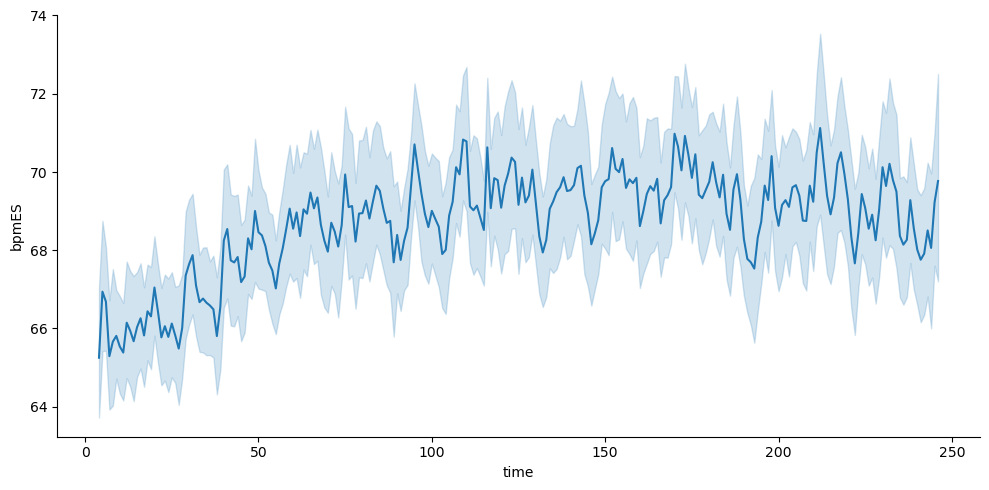

In [72]:

df_analysis = all_data_df.groupby(["time", "user_id"]).mean()

sns.relplot(x="time", y="bpmES", kind="line", data=df_analysis.to_pandas(), aspect=2)

/var/folders/g5/mqbcmmn575z0s3c021r942c80000gp/T/ipykernel_92009/3939675122.py:1: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  df_analysis = all_data_df.groupby(["time", "user_id", "manipulated"]).mean()


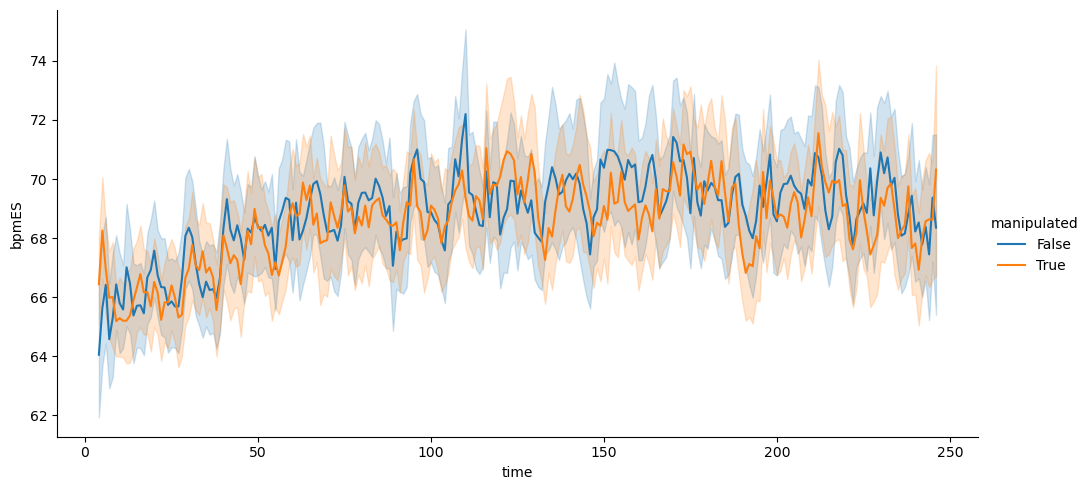

In [73]:

df_analysis = all_data_df.groupby(["time", "user_id", "manipulated"]).mean()

sns.relplot(x="time", y="bpmES", kind="line", hue="manipulated",data=df_analysis.to_pandas(), aspect=2)

/var/folders/g5/mqbcmmn575z0s3c021r942c80000gp/T/ipykernel_62454/4059215897.py:1: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  df_analysis = all_data_df.groupby(["time", "user_id", "participant_condition", "other_condition"]).mean()


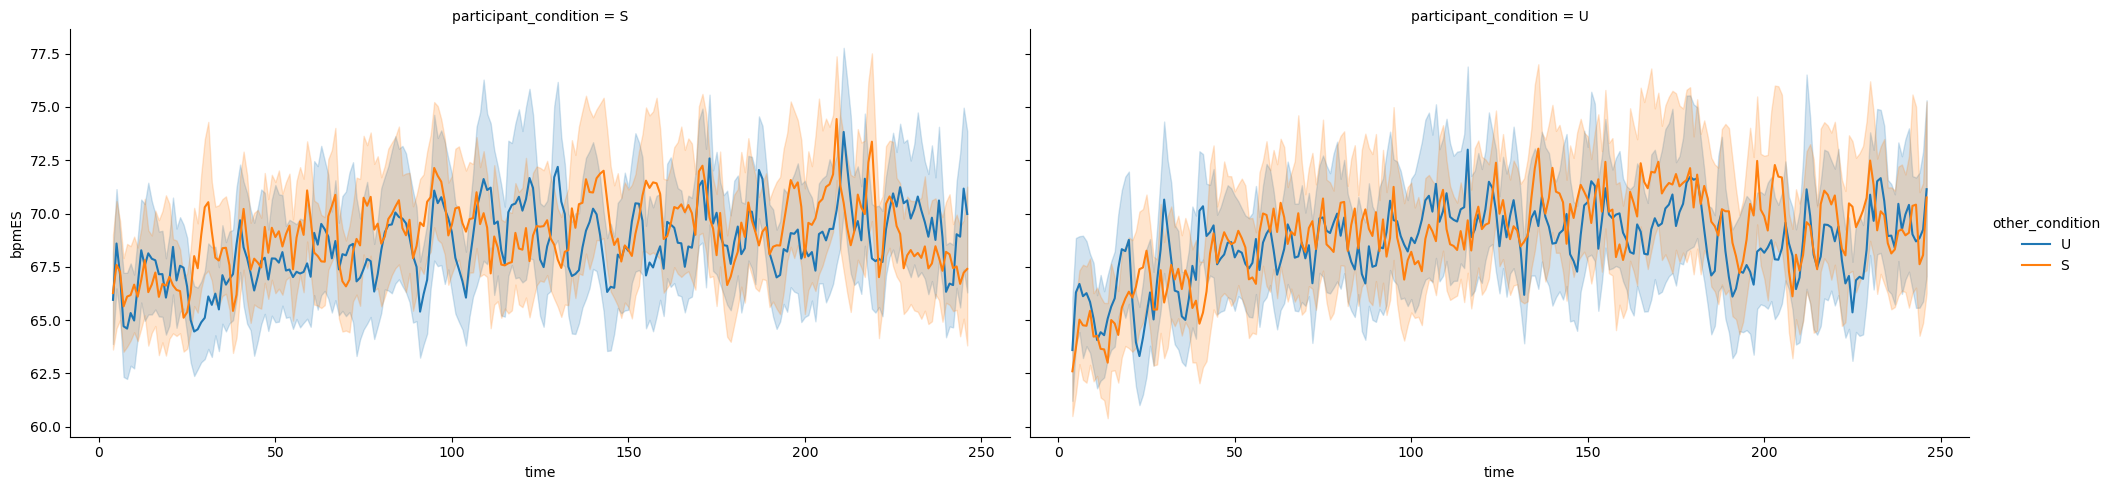

In [69]:

df_analysis = all_data_df.groupby(["time", "user_id", "participant_condition", "other_condition"]).mean()

sns.relplot(x="time", y="bpmES", kind="line", hue="other_condition",col="participant_condition", data=df_analysis.to_pandas(), aspect=2)

/var/folders/g5/mqbcmmn575z0s3c021r942c80000gp/T/ipykernel_14258/4129355082.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_analysis = df_analysis.groupby(["user_id", "participant_condition", "other_condition"]).mean().reset_index()


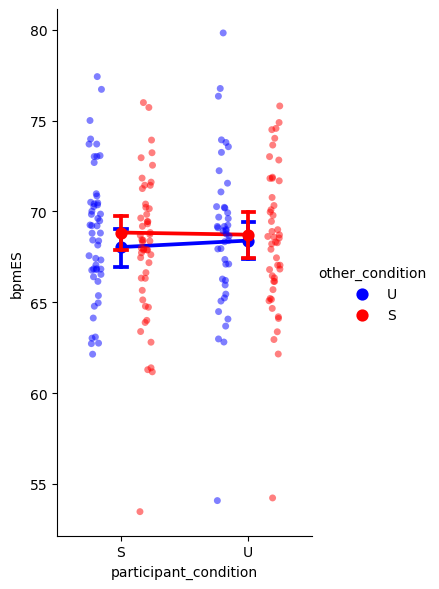

In [30]:

df_analysis = all_data_df.to_pandas()

df_analysis = df_analysis.loc[df_analysis["method"] != "MTTS_CAN"]

df_analysis = df_analysis.groupby(["user_id", "participant_condition", "other_condition"]).mean().reset_index()

g = sns.catplot(x="participant_condition", y="bpmES"
                        , hue="other_condition"
                        , kind="point"
                        , units="user_id"
                        , data=df_analysis
                        , capsize=0.09
                        , aspect=0.6
                        , height=6
                        , hue_order=["U", "S"]
                        , order=["S", "U"]
                        , palette= ["blue", "red"]
                    )

sns.stripplot(x="participant_condition", y="bpmES", hue="other_condition"
              , data=df_analysis, dodge=True, ax=g.ax, alpha=0.5, legend=False
              , palette= ["blue", "red"]
              )


df_analysis.to_csv("data/hr/hr_for_glmm.csv")

/var/folders/g5/mqbcmmn575z0s3c021r942c80000gp/T/ipykernel_62454/3910810786.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_analysis = df_analysis.groupby(["user_id", "participant_condition", "other_condition", "manipulated"]).mean().reset_index()
/Users/arias/opt/anaconda3/envs/stim39/lib/python3.9/site-packages/seaborn/axisgrid.py:848: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  func(*plot_args, **plot_kwargs)
/Users/arias/opt/anaconda3/envs/stim39/lib/python3.9/site-packages/seaborn/axisgrid.py:848: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  func(*plot_args, **plot_kwargs)
/Users/arias/opt/anaconda3/envs/stim39/lib/python3.9/site-packages/seaborn/axisgrid.py:848: FutureWarning: Passing `palette` without assigning `hue` is depr

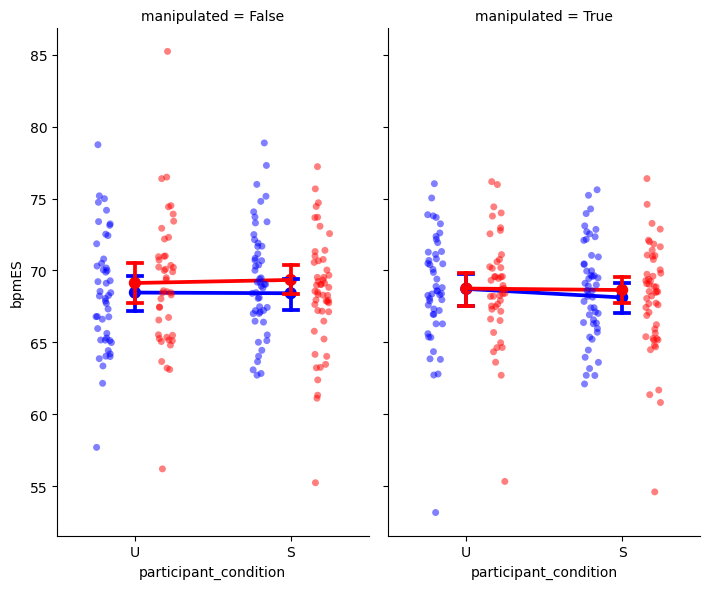

In [88]:

df_analysis = all_data_df.to_pandas()

#df_analysis = df_analysis.loc[df_analysis["method"] != "MTTS_CAN"]

df_analysis = df_analysis.groupby(["user_id", "participant_condition", "other_condition", "manipulated"]).mean().reset_index()

g = sns.FacetGrid(df_analysis, col="manipulated", height=6, aspect=0.6, hue="other_condition", hue_order=["U", "S"], palette=["blue", "red"])

# Map a pointplot to each facet
g.map_dataframe(sns.pointplot, x="participant_condition", y="bpmES", order=["U", "S"], capsize=0.09, units="user_id")

# Map a stripplot to each facet
g.map_dataframe(sns.stripplot, x="participant_condition", y="bpmES", dodge=True, alpha=0.5, palette=["blue", "red"])


/var/folders/g5/mqbcmmn575z0s3c021r942c80000gp/T/ipykernel_14258/160757643.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_analysis = df_analysis.groupby(["user_id", "participant_condition", "other_condition"]).median().reset_index()


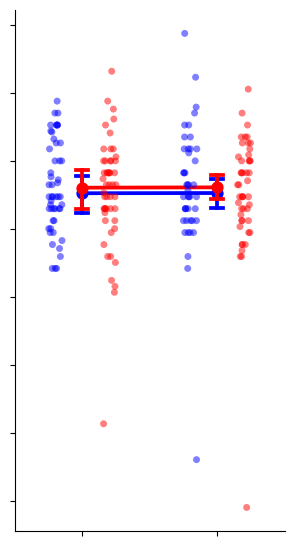

In [61]:
df_analysis = all_data_df.to_pandas()

df_analysis = df_analysis.loc[df_analysis["method"] != "MTTS_CAN"]

df_analysis = df_analysis.groupby(["user_id", "participant_condition", "other_condition"]).median().reset_index()

g = sns.catplot(x="participant_condition", y="bpmES"
                        , hue="other_condition"
                        , kind="point"
                        , units="user_id"
                        , data=df_analysis
                        , capsize=0.09
                        , aspect=0.6
                        , height=6
                        , hue_order=["U", "S"]
                        , order=["U", "S"]
                        , palette= ["blue", "red"]
                        , legend=False
                    )

sns.stripplot(x="participant_condition", y="bpmES", hue="other_condition"
              , data=df_analysis, dodge=True, ax=g.ax, alpha=0.5, legend=False
              , palette= ["blue", "red"]
              )

plt.savefig("plots/hr_main_factor_legend.pdf", bbox_inches='tight')
g.set(xticklabels=[], yticklabels=[], title='',xlabel=None, ylabel=None)
plt.savefig("plots/hr_main_factor.pdf", bbox_inches='tight')

/var/folders/g5/mqbcmmn575z0s3c021r942c80000gp/T/ipykernel_14258/493309485.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_analysis = df_analysis.groupby(["user_id", "participant_condition", "other_condition"]).std().reset_index()


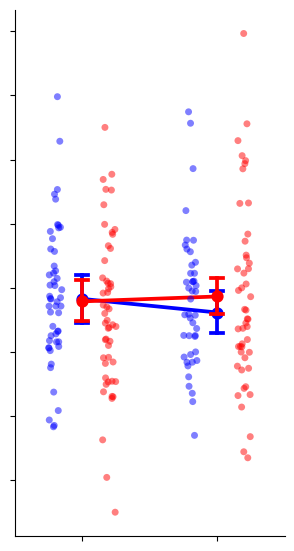

In [60]:

df_analysis = all_data_df.to_pandas()

df_analysis = df_analysis.loc[df_analysis["method"] != "MTTS_CAN"]

df_analysis = df_analysis.groupby(["user_id", "participant_condition", "other_condition"]).std().reset_index()

g = sns.catplot(x="participant_condition", y="bpmES"
                        , hue="other_condition"
                        , kind="point"
                        , units="user_id"
                        , data=df_analysis
                        , capsize=0.09
                        , aspect=0.6
                        , height=6
                        , legend=False
                        , hue_order=["U", "S"]
                        , order=["U", "S"]
                        , palette= ["blue", "red"]
                    )

sns.stripplot(x="participant_condition", y="bpmES", hue="other_condition"
              , data=df_analysis, dodge=True, ax=g.ax, alpha=0.5, legend=False
              , palette= ["blue", "red"]
              )


plt.savefig("plots/hr_sd_main_factor_legend.pdf", bbox_inches='tight')
g.set(xticklabels=[], yticklabels=[], title='',xlabel=None, ylabel=None)
plt.savefig("plots/hr_sd_main_factor.pdf", bbox_inches='tight')

/var/folders/g5/mqbcmmn575z0s3c021r942c80000gp/T/ipykernel_62454/2375602084.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_analysis = df_analysis.groupby(["user_id", "participant_condition", "other_condition", "manipulated"]).std().reset_index()
/Users/arias/opt/anaconda3/envs/stim39/lib/python3.9/site-packages/seaborn/axisgrid.py:848: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  func(*plot_args, **plot_kwargs)
/Users/arias/opt/anaconda3/envs/stim39/lib/python3.9/site-packages/seaborn/axisgrid.py:848: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  func(*plot_args, **plot_kwargs)
/Users/arias/opt/anaconda3/envs/stim39/lib/python3.9/site-packages/seaborn/axisgrid.py:848: FutureWarning: Passing `palette` without assigning `hue` is deprec

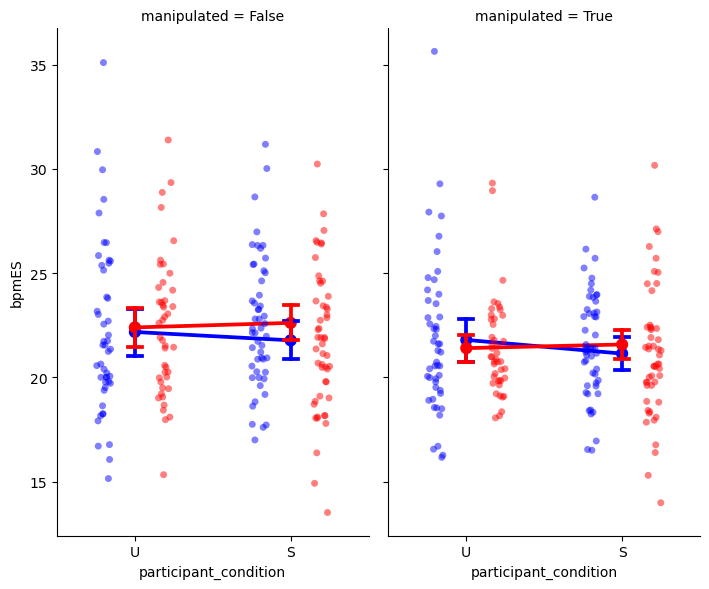

In [94]:

df_analysis = all_data_df.to_pandas()

df_analysis = df_analysis.loc[df_analysis["method"] != "MTTS_CAN"]

df_analysis = df_analysis.groupby(["user_id", "participant_condition", "other_condition", "manipulated"]).std().reset_index()

g = sns.FacetGrid(df_analysis, col="manipulated", height=6, aspect=0.6, hue="other_condition", hue_order=["U", "S"], palette=["blue", "red"])

# Map a pointplot to each facet
g.map_dataframe(sns.pointplot, x="participant_condition", y="bpmES", order=["U", "S"], capsize=0.09, units="user_id")

# Map a stripplot to each facet
g.map_dataframe(sns.stripplot, x="participant_condition", y="bpmES", dodge=True, alpha=0.5, palette=["blue", "red"])


/var/folders/g5/mqbcmmn575z0s3c021r942c80000gp/T/ipykernel_62454/2024401912.py:1: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  df_analysis = all_data_df.groupby(["user_id", "participant_condition", "other_condition", "method"]).mean()


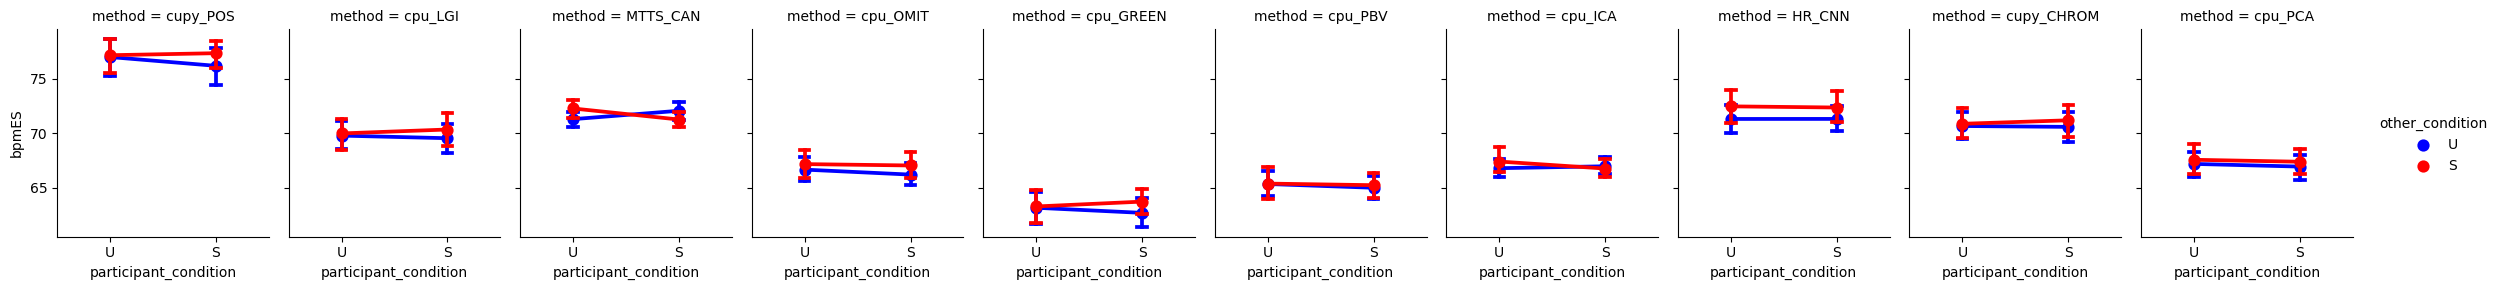

In [45]:

df_analysis = all_data_df.groupby(["user_id", "participant_condition", "other_condition", "method"]).mean()

g = sns.catplot(x="participant_condition", y="bpmES"
                        , hue="other_condition"
                        , kind="point"
                        , data=df_analysis.to_pandas()
                        , capsize=0.09
                        , aspect=0.8
                        , height=3
                        , order=["U", "S"]
                        , hue_order= ["U", "S"]
                        , palette= ["blue", "red"]
                        , col="method"
                    )


/var/folders/g5/mqbcmmn575z0s3c021r942c80000gp/T/ipykernel_62454/1837472654.py:1: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  df_analysis = all_data_df.groupby(["user_id", "participant_condition", "other_condition", "method", "manipulated"]).mean()


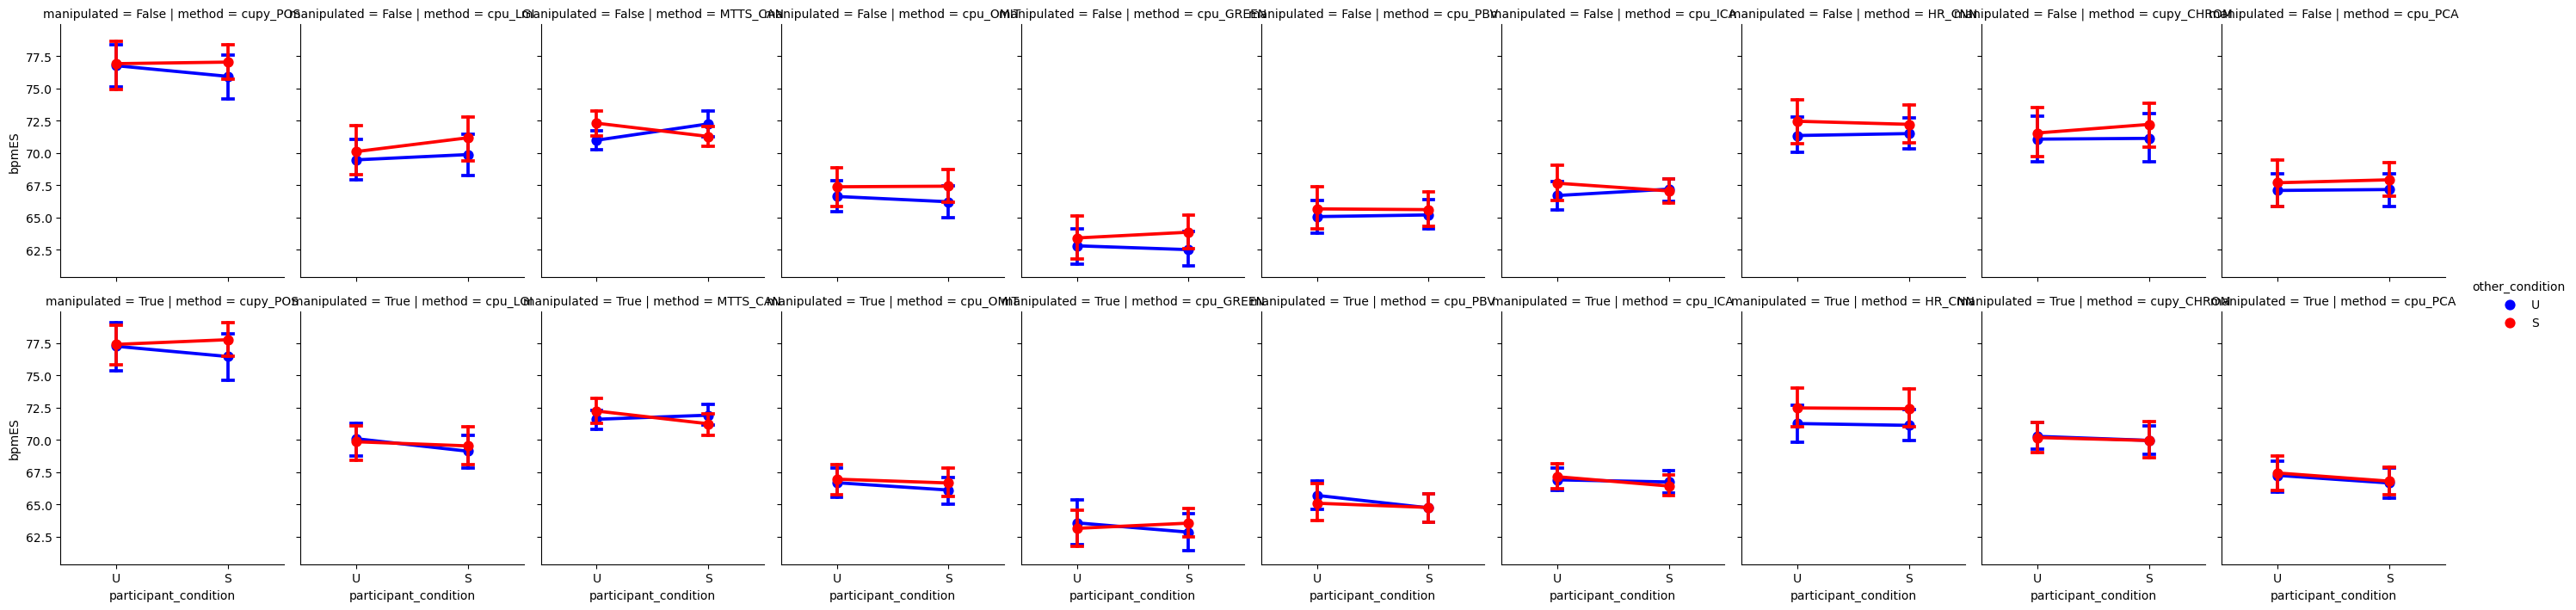

In [107]:

df_analysis = all_data_df.groupby(["user_id", "participant_condition", "other_condition", "method", "manipulated"]).mean()

g = sns.catplot(x="participant_condition", y="bpmES"
                        , hue="other_condition"
                        , kind="point"
                        , row="manipulated"
                        , data=df_analysis.to_pandas()
                        , capsize=0.09
                        , aspect=0.8
                        , height=3.6
                        , order=["U", "S"]
                        , hue_order= ["U", "S"]
                        , palette= ["blue", "red"]
                        , col="method"
                    )


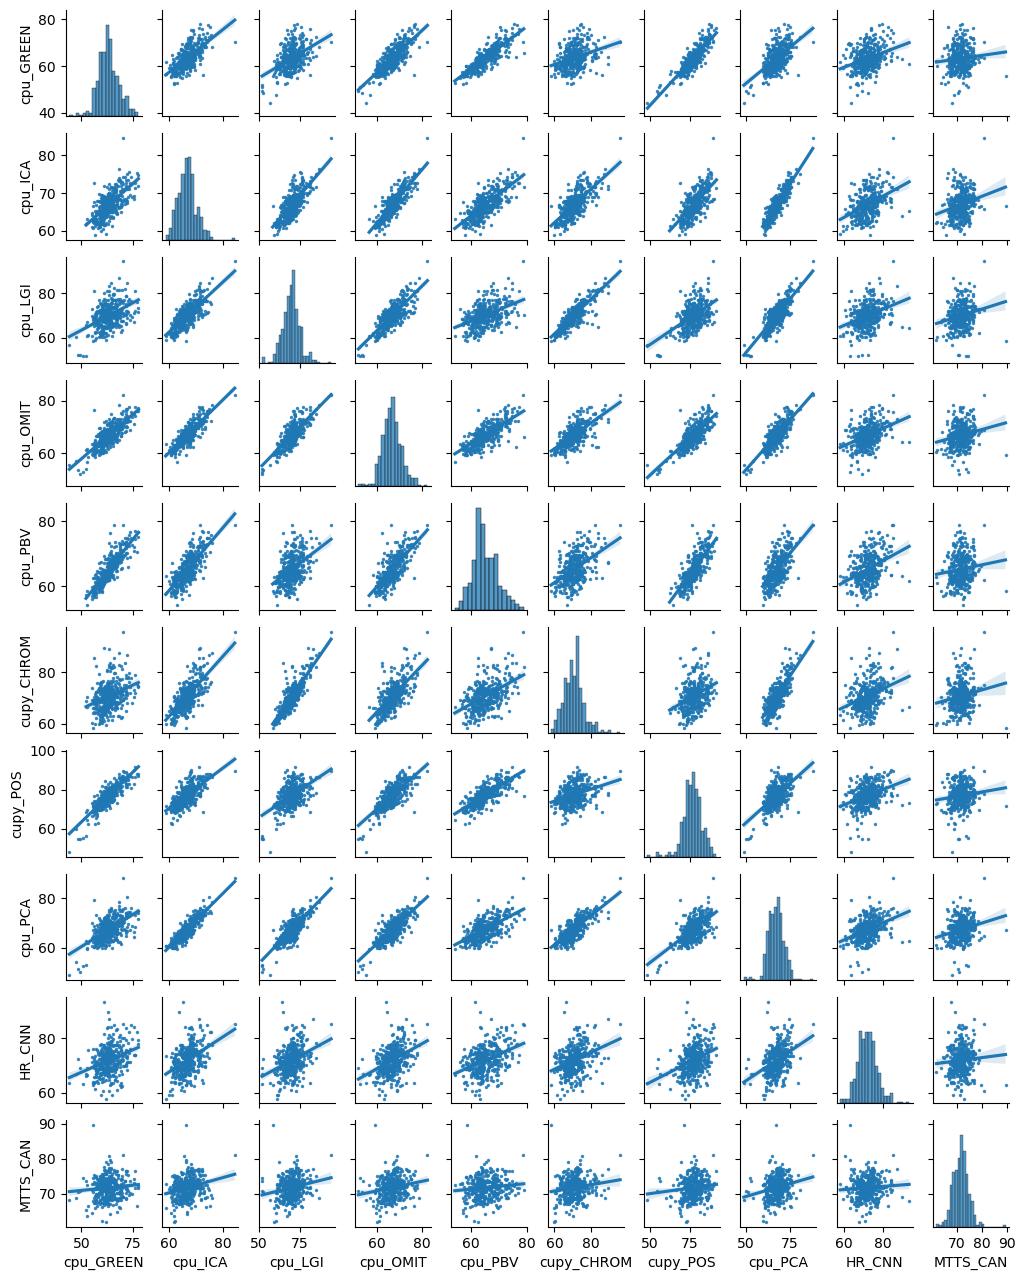

In [44]:
df_analysis = all_data_df.group_by(["dyad", "user_id", "manipulated", "method"]).mean().to_pandas()
df_analysis = df_analysis.pivot(index =["dyad", "user_id", "manipulated"] , columns="method", values="bpmES").reset_index()
df_analysis = df_analysis[["cpu_GREEN", "cpu_ICA", "cpu_LGI", "cpu_OMIT", "cpu_PBV", "cupy_CHROM", "cupy_POS", "cpu_PCA", "HR_CNN", "MTTS_CAN"]]

sns.pairplot(df_analysis, kind="reg", aspect=0.8, height=1.3, plot_kws={'scatter_kws': {'s': 2.2}})

plt.savefig("plots/paired_hr.pdf")

/var/folders/g5/mqbcmmn575z0s3c021r942c80000gp/T/ipykernel_62454/3378245723.py:1: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  df_analysis = all_data_df.groupby(['user_id', "other_id", "participant_condition", "other_condition", "question_content"]).mean()


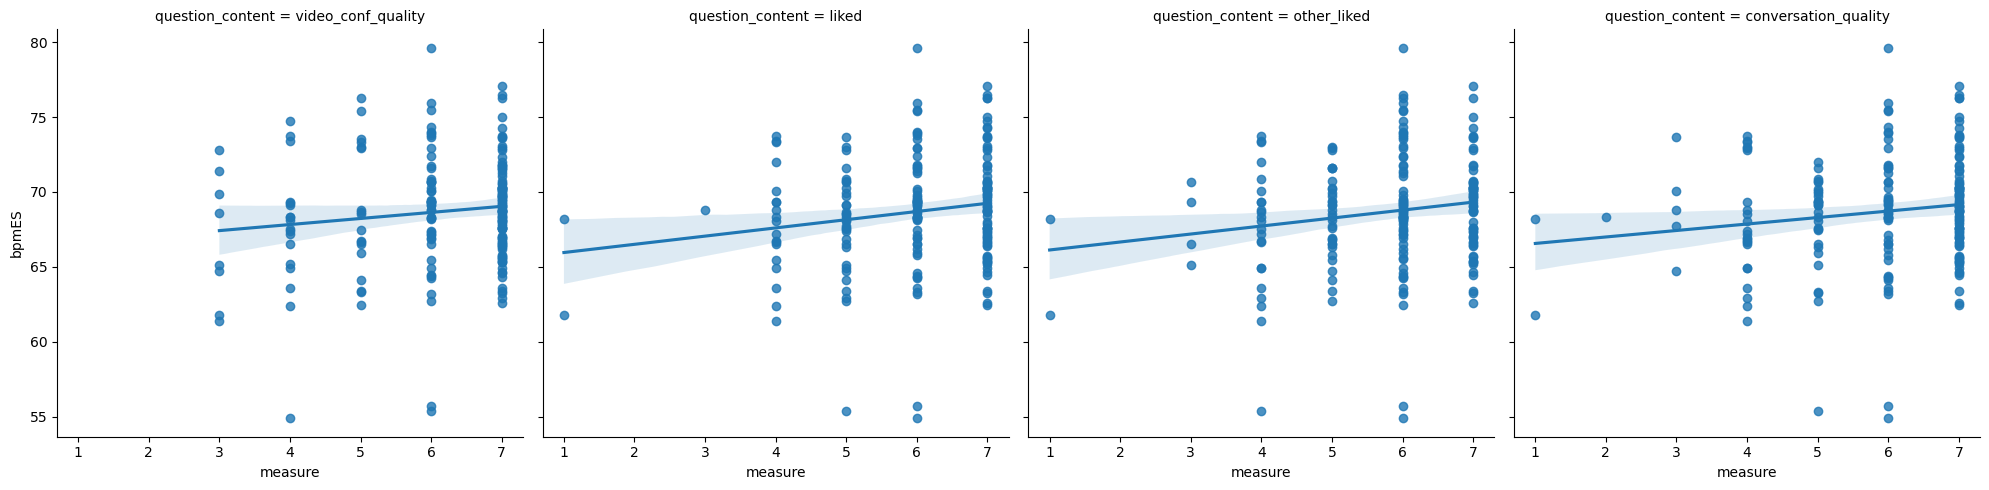

In [75]:
df_analysis = all_data_df.groupby(['user_id', "other_id", "participant_condition", "other_condition", "question_content"]).mean()

sns.lmplot(y= "bpmES", x="measure", col="question_content", data=df_analysis.to_pandas())

In [115]:
df_analysis = all_data_df.group_by(["dyad", "user_id", "participant_condition", "other_condition", "question_content"]).mean().to_pandas()


for ind, df in df_analysis.groupby(["question_content"]):
    x = df["measure"].values
    y = df["bpmES"].values
    pear_corr, pear_p = stats.pearsonr(x, y)
    spearman_corr, p_value = spearmanr(x, y)

    print("question : ", ind)
    print("Pearson", pear_corr, pear_p)
    print("Spearman", spearman_corr, p_value)
    print()


question :  conversation_quality
Pearson 0.1481471329096323 0.03925486585815
Spearman 0.13103622275410093 0.06857811042279978

question :  liked
Pearson 0.1662000169634099 0.020554445576006285
Spearman 0.1393668431206286 0.052613503748193395

question :  other_liked
Pearson 0.16741120210975097 0.019638185426494207
Spearman 0.1354457113684348 0.05969556182537498

question :  video_conf_quality
Pearson 0.12613095402201793 0.07969591127426655
Spearman 0.0826359364592977 0.2519989862963893



/var/folders/g5/mqbcmmn575z0s3c021r942c80000gp/T/ipykernel_62454/425341910.py:4: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for ind, df in df_analysis.groupby(["question_content"]):


/var/folders/g5/mqbcmmn575z0s3c021r942c80000gp/T/ipykernel_62454/23500085.py:1: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  df_analysis = all_data_df.groupby(['user_id', "other_id", "participant_condition", "other_condition", "question_content", "manipulated"]).mean()


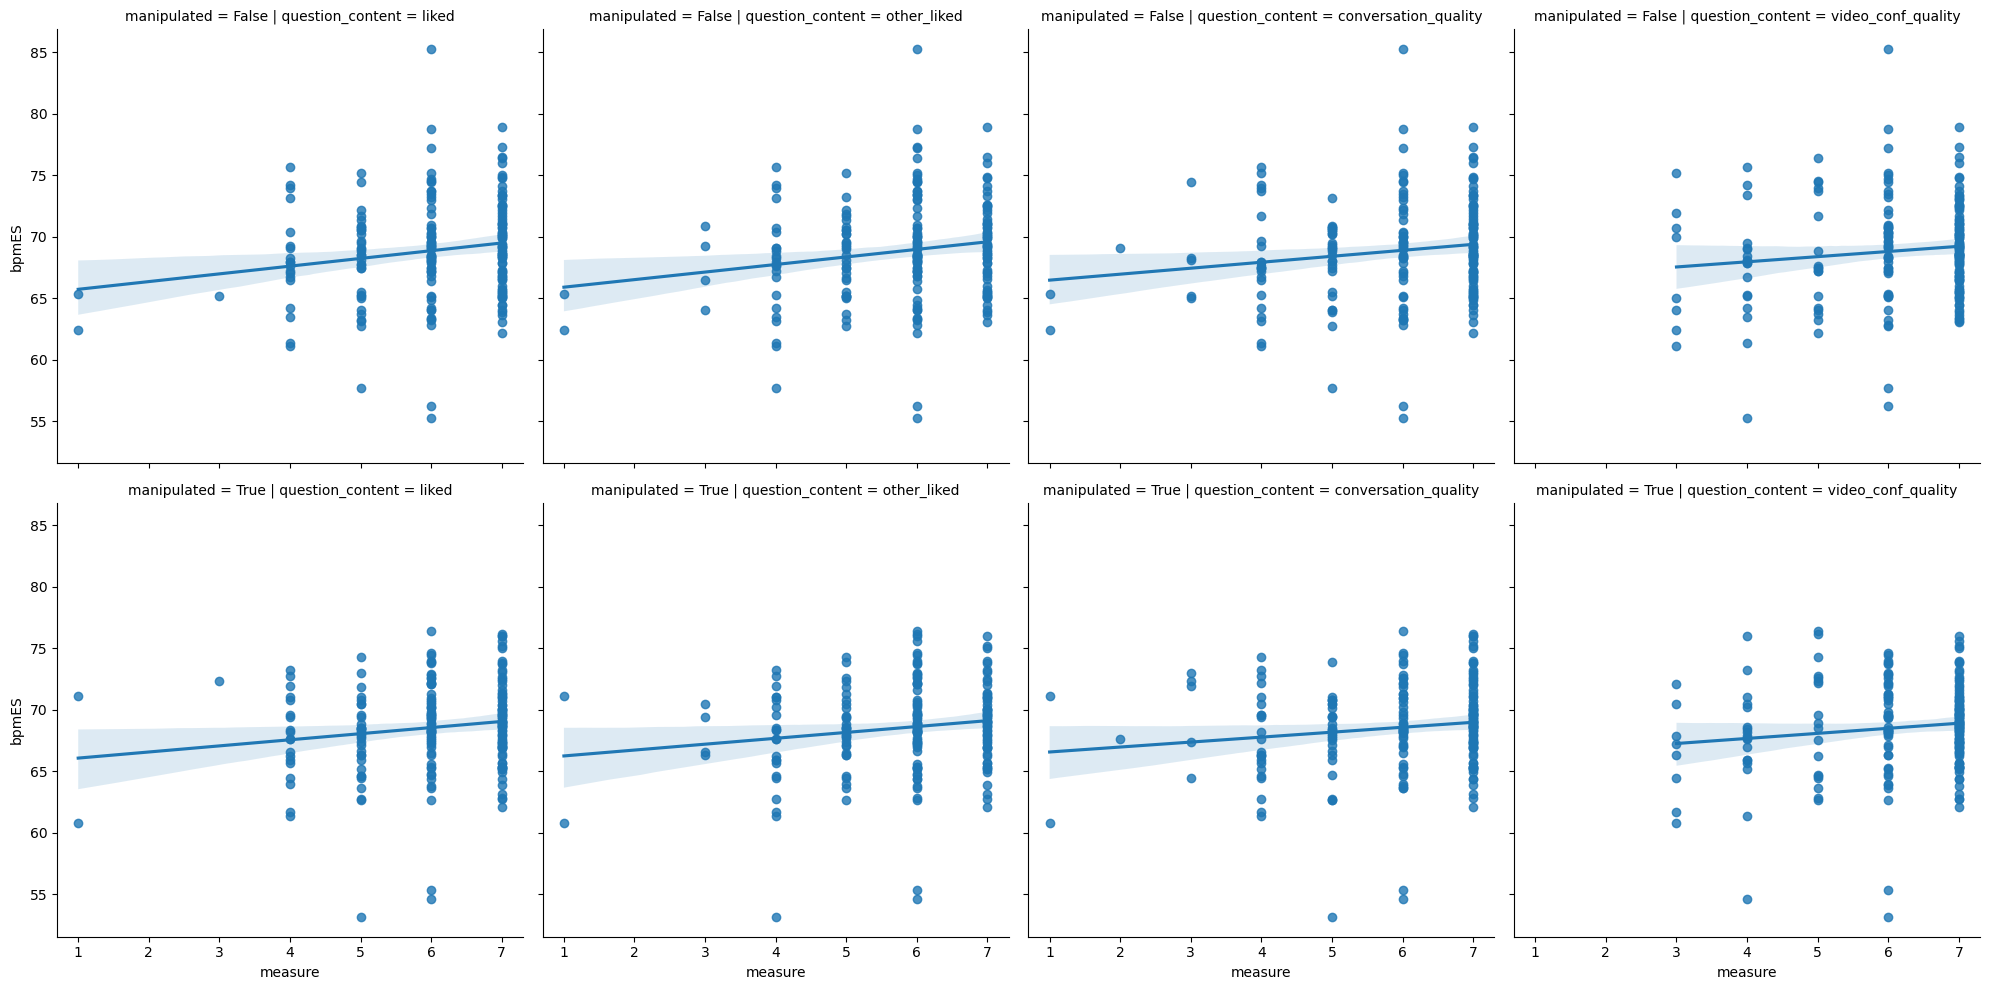

In [92]:
df_analysis = all_data_df.groupby(['user_id', "other_id", "participant_condition", "other_condition", "question_content", "manipulated"]).mean()

sns.lmplot(y= "bpmES", x="measure", col="question_content", row="manipulated", data=df_analysis.to_pandas())

In [90]:
df_analysis = all_data_df.group_by(["dyad", "user_id", "participant_condition", "other_condition", "question_content", "manipulated"]).mean().to_pandas()

from scipy.stats import spearmanr

for manip, df_aux in df_analysis.groupby(["manipulated"]):
    print(" ---------- mnanipulated :" , manip, " ---------------")
    for ind, df in df_aux.groupby(["question_content"]):
        x = df["measure"].values
        y = df["bpmES"].values
        pear_corr, pear_p = stats.pearsonr(x, y)
        spearman_corr, p_value = spearmanr(x, y)

        print("Pearson", pear_corr, pear_p)
        print("Spearman", spearman_corr, p_value)
        print()


 ---------- mnanipulated : False
Pearson 0.15134157552318422 0.03516352097175179
Spearman 0.13523929271773139 0.06008913026181373

Pearson 0.17342781564184895 0.015592637211807082
Spearman 0.14683478327116184 0.04104827455185741

Pearson 0.17599084541070403 0.01410347502745248
Spearman 0.14714062274887213 0.04062428526822506

Pearson 0.11881226798715683 0.09893912954786277
Spearman 0.08481282581968053 0.23967816936271802

 ---------- mnanipulated : True
Pearson 0.1400907646591686 0.05138542048978612
Spearman 0.12365435308048216 0.08583780905477788

Pearson 0.15297172405294202 0.033218770688230335
Spearman 0.12464267159111204 0.08334278841471567

Pearson 0.15264944266921768 0.0335958363373303
Spearman 0.11803057503023283 0.10119535745537994

Pearson 0.1301544868931917 0.07047761080865861
Spearman 0.07679929719641428 0.2871700077577023



/var/folders/g5/mqbcmmn575z0s3c021r942c80000gp/T/ipykernel_62454/292457246.py:5: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for manip, df_aux in df_analysis.groupby(["manipulated"]):
/var/folders/g5/mqbcmmn575z0s3c021r942c80000gp/T/ipykernel_62454/292457246.py:7: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for ind, df in df_aux.groupby(["question_content"]):
/var/folders/g5/mqbcmmn575z0s3c021r942c80000gp/T/ipykernel_62454/292457246.py:7: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoi

# Synchrony

In [49]:
import pandas as pd
all_data_df = pd.read_csv("data/hr_computed/hr.csv")
ts_df = all_data_df.groupby(["sid", "dyad", "user_id", "other_id", "participant_condition", "other_condition", "file_name", "manipulated", "time"]).mean(numeric_only=True).reset_index()


In [50]:
#define global features
other_manipulations = [True, False]
source_features = ["bpmES"]
target_features = ["bpmES"]

In [51]:
#Check which interactions were recorded correctly and can be used for this analysis:
correct_interactions   = []
incorrect_interactions = []
for interaction in glob.glob("data/preproc/prolific/*/trimed/*"):
    recordings = glob.glob(interaction + "/*.mp4")
    if len(recordings)==4:
        sid = interaction.split("/")[3]
        dyad = interaction.split("/")[5][2:]

        correct_interactions.append((sid, dyad))
    else:
        incorrect_interactions.append((sid, dyad))

print("Found "+ str(len(correct_interactions)) + " correct interactions")
print("Found "+ str(len(incorrect_interactions)) + " incorrect interactions")

Found 113 correct interactions
Found 21 incorrect interactions


In [124]:
#Both manipulated with the same value
lag = 15 # 15 seconds before and 15 seconds after
nb_min_samples = 100 #atleast 1 minute per interaction
save_plot = False

mi_df = pd.DataFrame()
df_lags = pd.DataFrame()
for other_manipulated in other_manipulations:
    for (sid, participant_manipulated, dyad, user_id), dyad_df in ts_df.groupby(["sid", "manipulated", "dyad", "user_id"]):
        #if participant_manipulated == True:
        #    continue
        
        #Check if interaction was recorded correctly (4 recordings in total).
        found=False
        for interaction in correct_interactions:
            if sid == interaction[0] and dyad == interaction[1]:
                found = True
                break
        if not found:
            #print("Skipping not correct recording - dyad : " + dyad + " sid : " + sid)
            continue
            
        #Prepare participants' time series
        participant_df = dyad_df.loc[dyad_df["user_id"] == user_id]
        participant_df = participant_df.ffill(axis="rows")
        participant_df = participant_df.bfill(axis="rows")
        
        other_id = participant_df["other_id"]
        nulls = np.unique(other_id.isnull())
        if len(nulls)==1 and nulls[0]:
            continue

        other_id = np.unique(other_id)[0]    
        partner_df = ts_df.loc[ts_df["user_id"] == other_id]
        partner_df = partner_df.loc[partner_df["dyad"] == dyad]    
        partner_df = partner_df.loc[partner_df["manipulated"] == other_manipulated]        
        partner_df = partner_df.ffill(axis="rows")
        partner_df = partner_df.bfill(axis="rows")

        if not len(partner_df)>0:
            continue

        for source_feature in source_features:
            for target_feature in target_features:    
                
                #preapre participant time series
                X = participant_df[source_feature].values

                #preapre target time series
                y = partner_df[target_feature].values

                if len(y)==0 or len(X) ==0 or len(y)< nb_min_samples or len(X)< nb_min_samples:
                    continue

                #Keep only the same number of samples for both
                max = np.min([len(X), len(y)])
                X = X[0:max]
                y = y[0:max]

                #cross-correlation
                corr_X = [(val-np.nanmean(X))/np.nanstd(X) for val in X]
                corr_y = [(val-np.nanmean(y))/np.nanstd(y) for val in y]
                corr = signal.correlate(corr_X, corr_y, mode='same') 
                corr = corr  / len(X)

                #Select only cross correaltion between +/- lag
                selected_corr = corr[round(len(corr)/2 - lag): round(len(corr)/2 + lag)]
                pears_r, p = stats.pearsonr(corr_X, corr_y)
                max_corr = np.arctanh(np.nanmax(selected_corr))

                #Compute MI
                X = X.reshape(-1,1)    
                mi = mutual_info_regression(X=X, y=y
                                   , discrete_features = 'auto'
                                   , n_neighbors = 60
                                   , copy = True
                                   , random_state=None
                               )
                
                if save_plot:                
                    plt.figure(figsize=(12,5))
                    plt.plot(X)
                    plt.plot(y)
                    plt.savefig("plots/hr/"+str(sid)+ str(dyad)+ str(user_id)+str(participant_manipulated)+".pdf")


                #Save results to a DataFrame
                aux_df = pd.DataFrame()
                aux_df["source_feature"]           = [source_feature]
                aux_df["target_feature"]           = [target_feature]
                aux_df["other_id"]                 = [other_id]
                aux_df["user_id"]                  = [user_id]
                aux_df["participant_manipulated"]  = [participant_manipulated]
                aux_df["other_manipulated"]        = [other_manipulated]
                aux_df["dyad"]                     = [dyad]
                aux_df["sid"]                      = [sid]
                aux_df["mi"]                       = mi
                aux_df["max_corr"]                 = [max_corr]

                aux_lags_df = pd.DataFrame()
                aux_lags_df["lag"]  = range(2*lag)
                aux_lags_df["lag"]  = aux_lags_df["lag"]-lag
                aux_lags_df["corr"] = selected_corr
                aux_lags_df["dyad"]                     = [dyad for i in range(len(aux_lags_df))]    
                aux_lags_df["source_feature"]           = [source_feature for i in range(len(aux_lags_df))]
                aux_lags_df["target_feature"]           = [target_feature for i in range(len(aux_lags_df))]
                aux_lags_df["participant_manipulated"]  = [participant_manipulated for i in range(len(aux_lags_df))]
                aux_lags_df["other_id"]                 = [other_id for i in range(len(aux_lags_df))]
                aux_lags_df["sid"]                      = [sid for i in range(len(aux_lags_df))]
                aux_lags_df["user_id"]                  = [user_id for i in range(len(aux_lags_df))]
                aux_lags_df["other_manipulated"]        = [other_manipulated for i in range(len(aux_lags_df))]            
                df_lags = pd.concat([df_lags, aux_lags_df])

                mi_df = pd.concat([mi_df, aux_df])

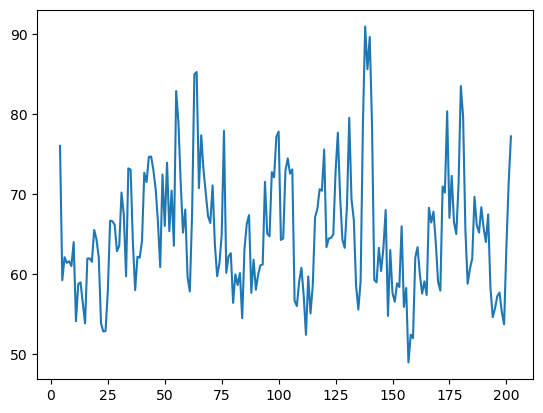

In [131]:
plt.plot(participant_df["time"].values, participant_df["bpmES"].values)

In [53]:
mi_df   = mi_df.merge(behavior_df.to_pandas()    , on=["sid", "dyad", "user_id", "other_id"], how="left")
df_lags = df_lags.merge(behavior_df.to_pandas()  , on=["sid", "dyad", "user_id", "other_id"], how="left")

In [54]:
mi_df.to_csv("data/hr_computed/mi_df.csv")
df_lags.to_csv("data/hr_computed/df_lags.csv")

## Synchrony Analysis

In [25]:
mi_df = pd.read_csv("data/hr_computed/mi_df.csv")

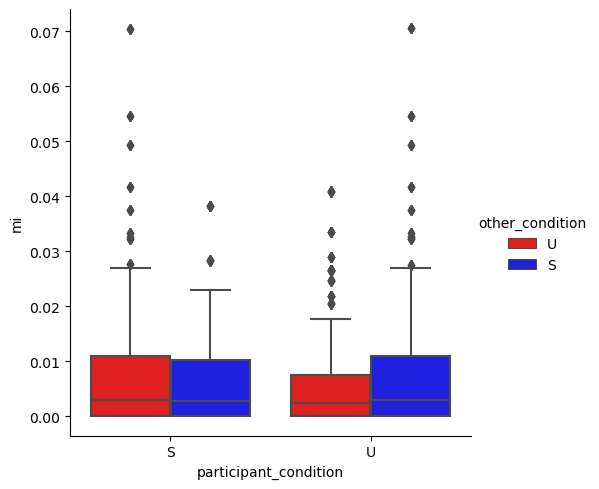

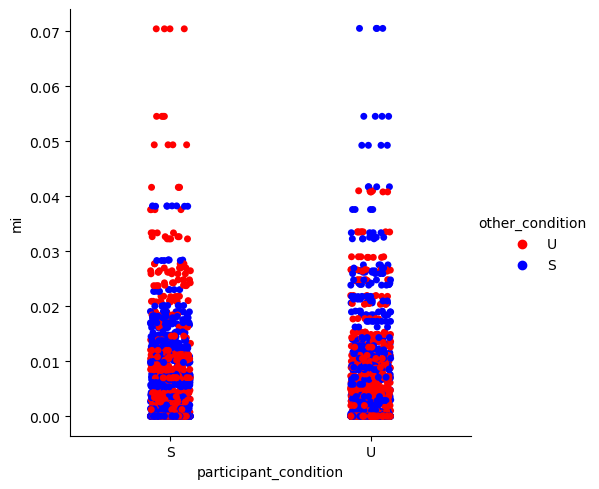

In [56]:
sns.catplot(x="participant_condition"
            , hue="other_condition"
            , y="mi"
            , data=mi_df
            , kind="box"
            , palette=sns.color_palette(['red', 'blue'])
            , order=["S", "U"]
            )
sns.catplot(x="participant_condition"
            , hue="other_condition"
            , y="mi"
            , data=mi_df
            , palette=sns.color_palette(['red', 'blue'])
            , order=["S", "U"]
            )

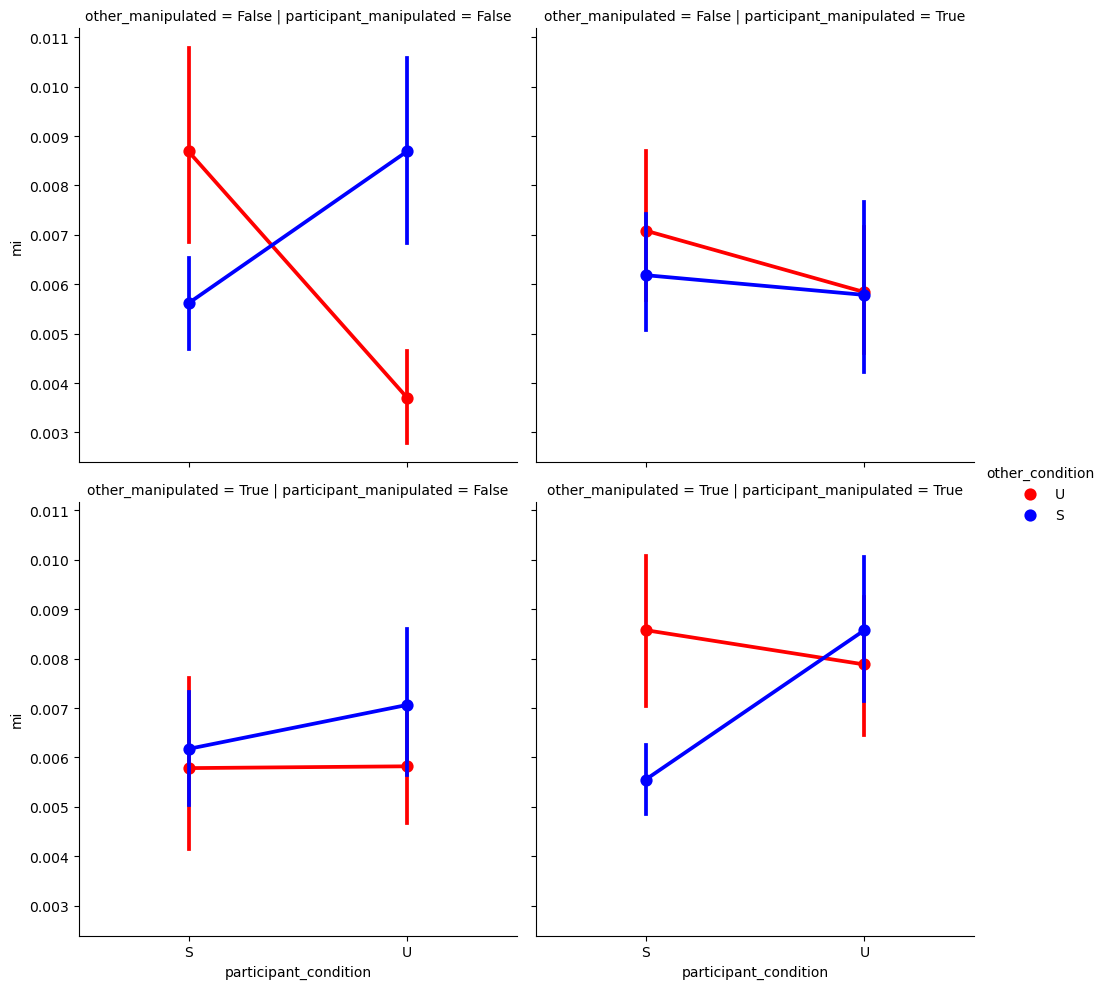

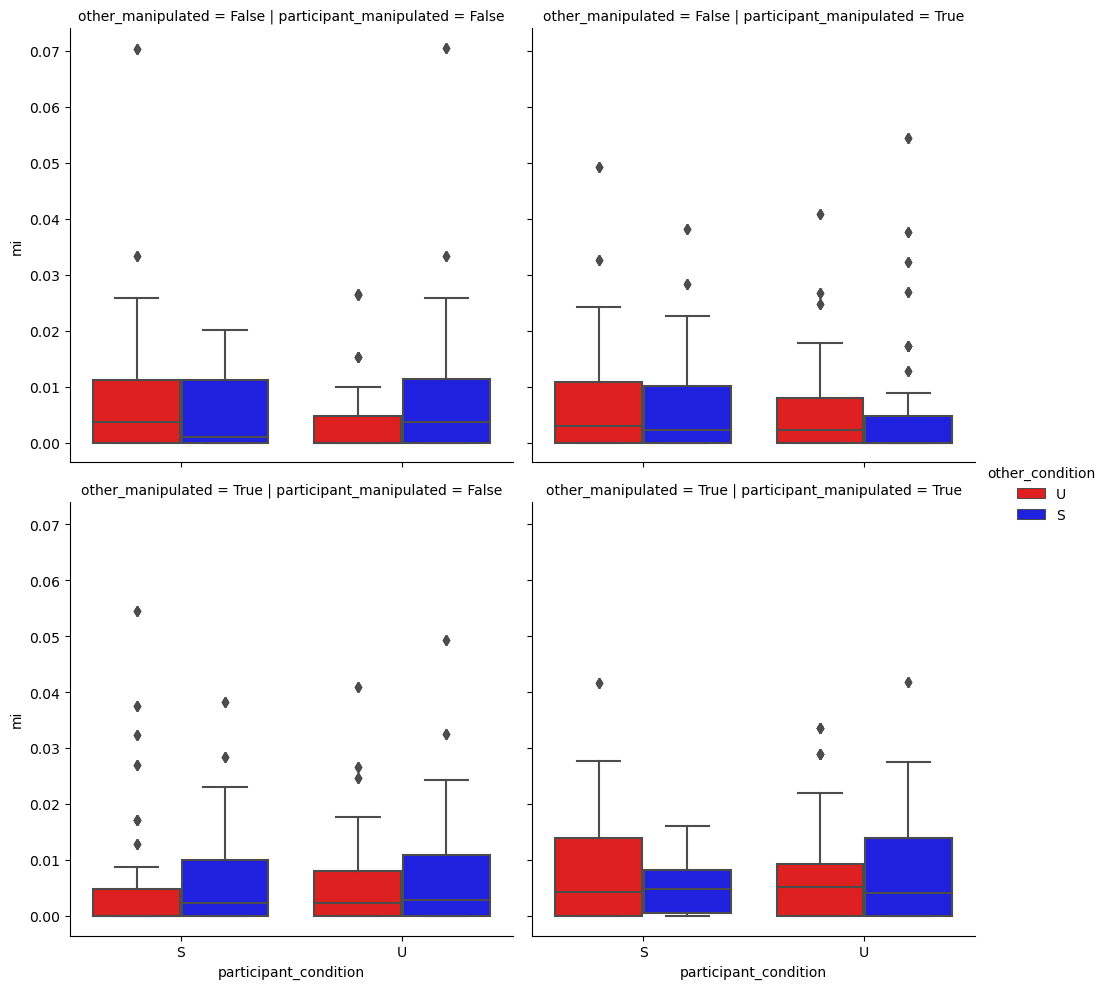

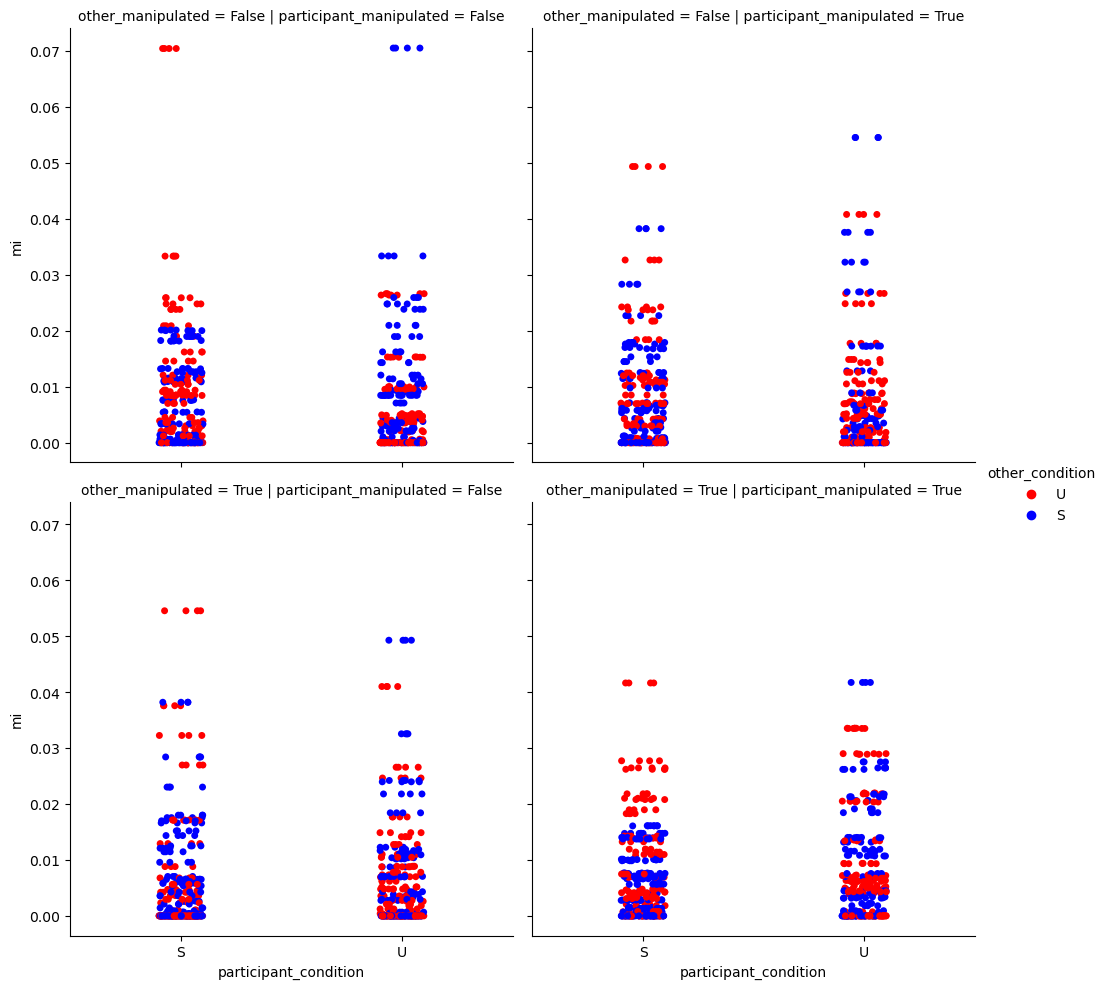

In [57]:
sns.catplot(x="participant_condition"
            , hue="other_condition"
            , y="mi"
            , col="participant_manipulated"
            , row="other_manipulated"
            , data=mi_df
            , palette=sns.color_palette(['red', 'blue'])
            , order=["S", "U"]
            , hue_order=["S", "U"]
            , kind="point"
            )

sns.catplot(x="participant_condition"
            , hue="other_condition"
            , y="mi"
            , col="participant_manipulated"
            , row="other_manipulated"
            , data=mi_df
            , kind="box"
            , palette=sns.color_palette(['red', 'blue'])
            , order=["S", "U"]
            , hue_order=["S", "U"]
            )
sns.catplot(x="participant_condition"
            , hue="other_condition"
            , col="participant_manipulated"
            , row="other_manipulated"
            , y="mi"
            , data=mi_df
            , palette=sns.color_palette(['red', 'blue'])
            , order=["S", "U"]
            , hue_order=["S", "U"]
            )

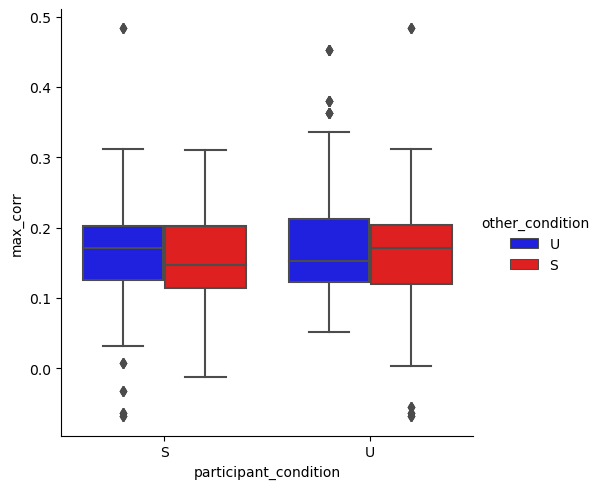

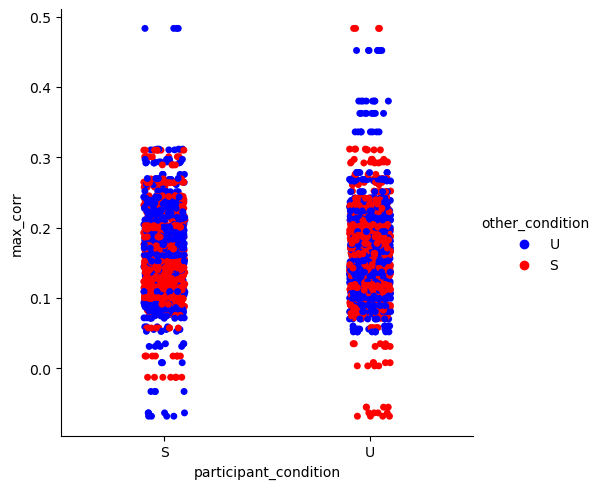

In [58]:
sns.catplot(x="participant_condition"
            , hue="other_condition"
            , y="max_corr"
            , data=mi_df
            , kind="box"
            , palette=sns.color_palette(['red', 'blue'])
            , order=["S", "U"]
            , hue_order=["S", "U"]
            )
sns.catplot(x="participant_condition"
            , hue="other_condition"
            , y="max_corr"
            , data=mi_df
            , palette=sns.color_palette(['blue', 'red'])
            , order=["S", "U"]
            , hue_order=["S", "U"]
            )

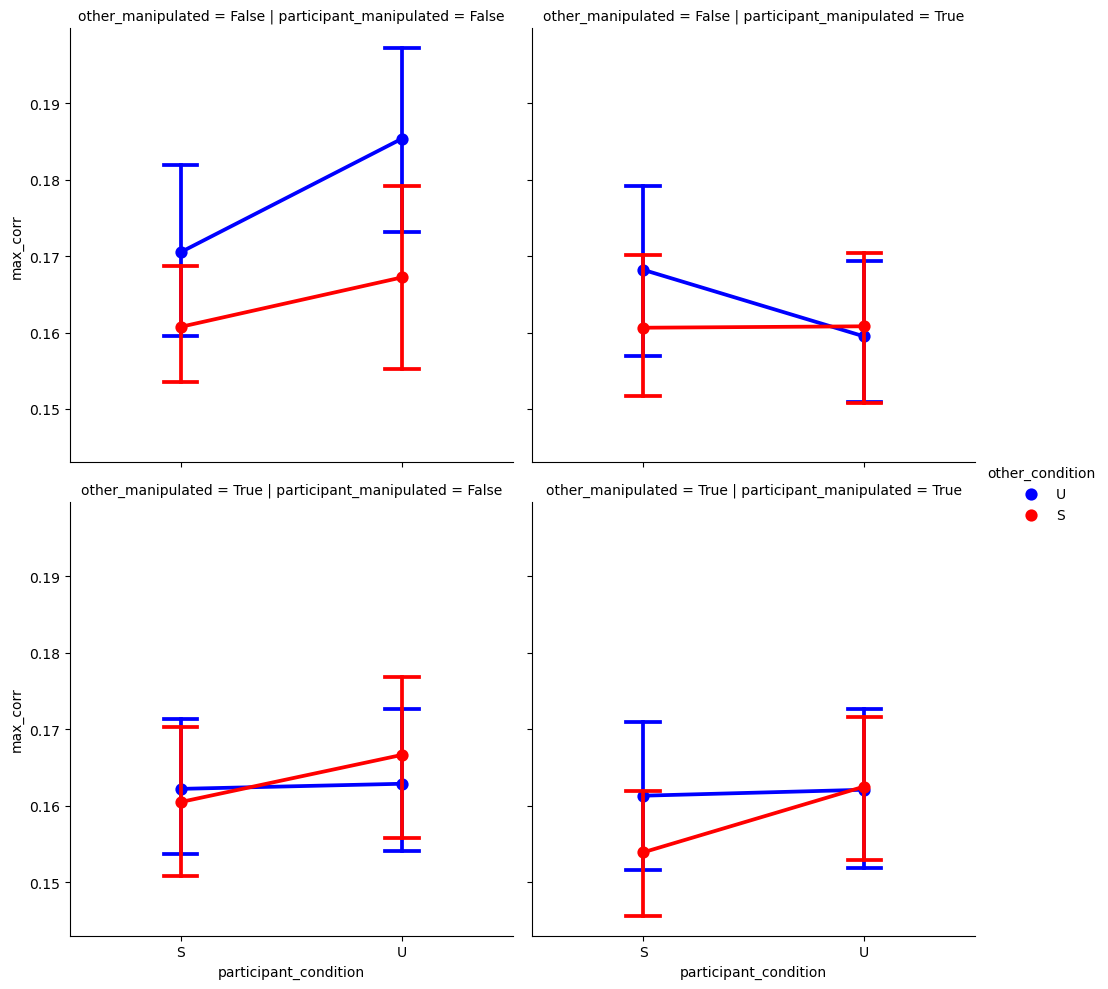

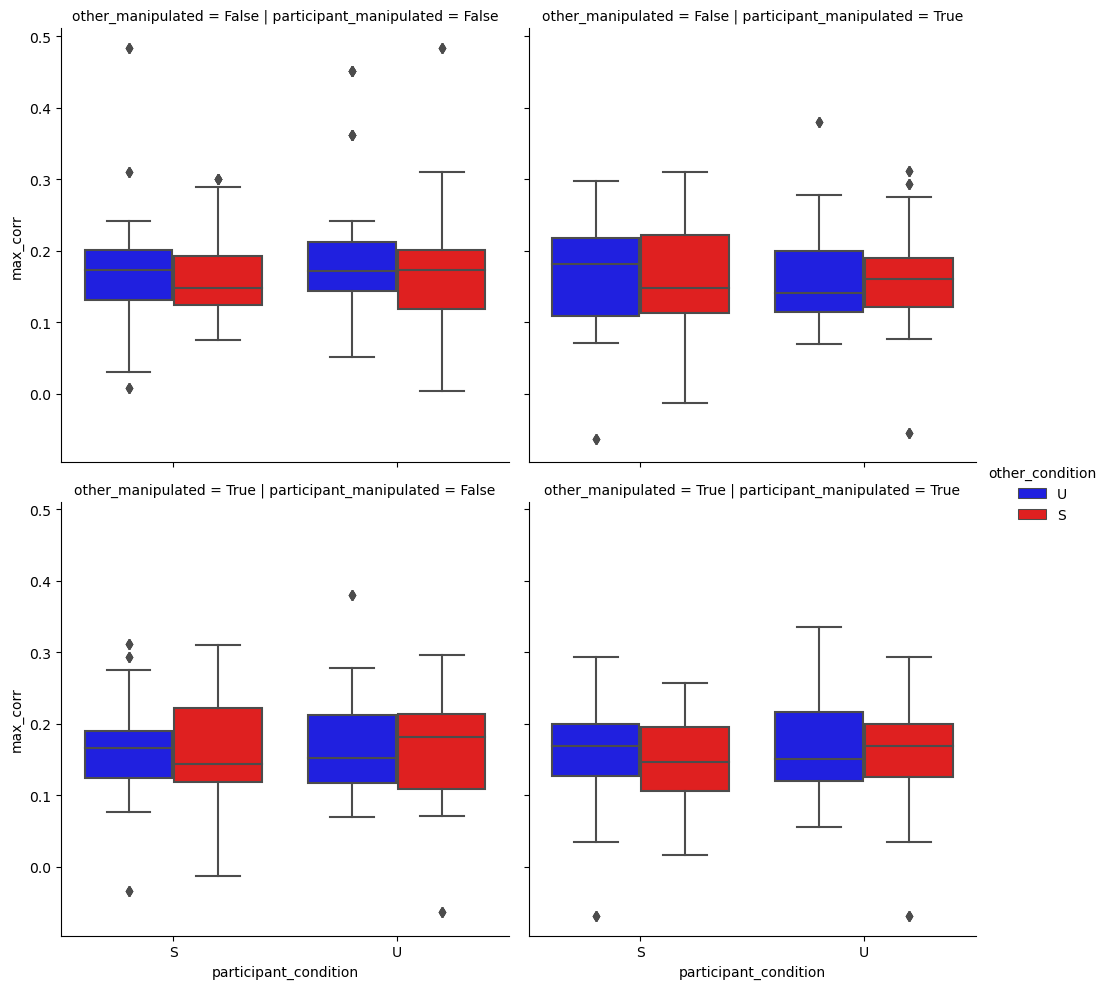

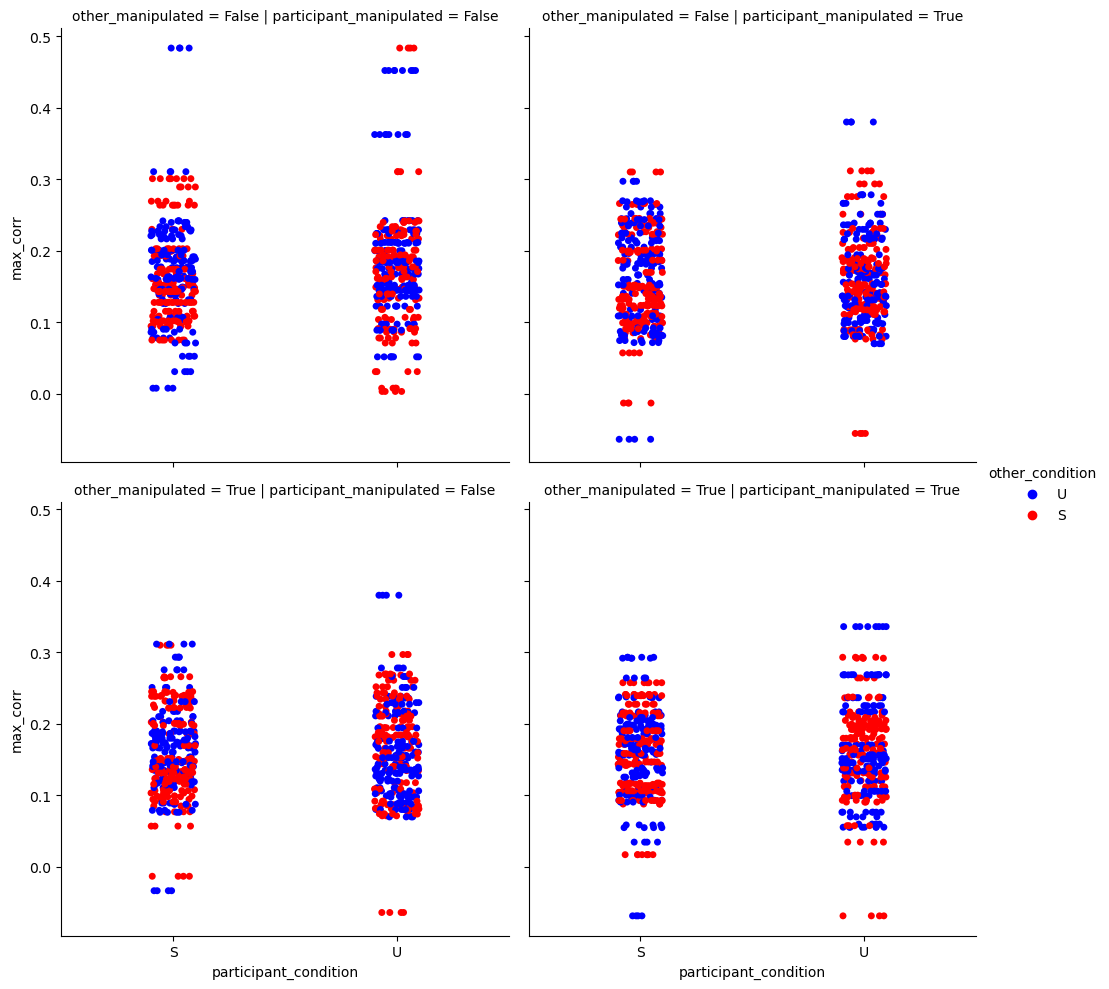

In [59]:

sns.catplot(x="participant_condition"
            , hue="other_condition"
            , col="participant_manipulated"
            , row="other_manipulated"
            , y="max_corr"
            , data=mi_df
            , palette=sns.color_palette(['red', 'blue'])
            , order=["S", "U"]
            , kind="point"
            , capsize=0.15
            , hue_order=["S", "U"]
            )

sns.catplot(x="participant_condition"
            , hue="other_condition"
            , y="max_corr"
            , data=mi_df
            , col="participant_manipulated"
            , row="other_manipulated"
            , kind="box"
            , palette=sns.color_palette(['red', 'blue'])
            , order=["S", "U"]
            , hue_order=["S", "U"]
            )
sns.catplot(x="participant_condition"
            , hue="other_condition"
            , col="participant_manipulated"
            , row="other_manipulated"
            , y="max_corr"
            , data=mi_df
            , palette=sns.color_palette(['red', 'blue'])
            , order=["S", "U"]
            , hue_order=["S", "U"]
            )

## Lags

In [34]:
df_lags = pd.read_csv("data/hr_computed/df_lags.csv")

/Users/arias/opt/anaconda3/envs/stim39/lib/python3.9/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  func(*plot_args, **plot_kwargs)


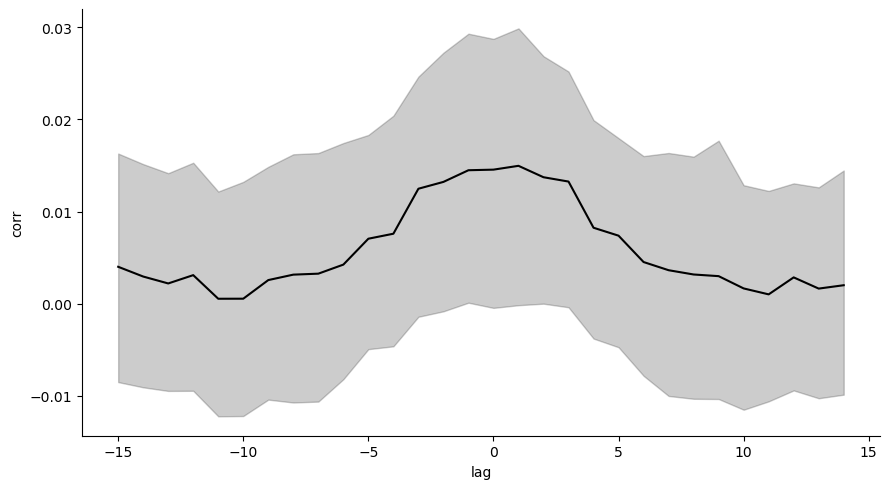

In [35]:
df_lags["u_cond"] = df_lags["participant_condition"] + df_lags["other_condition"]
df_lags["u_dyad"] = df_lags["sid"] + df_lags["dyad"]

df_analysis = df_lags

df_analysis = df_analysis.groupby(["lag", "u_dyad", "participant_condition", "other_condition", "u_cond"]).mean(numeric_only=True).reset_index()


g = sns.relplot(x="lag", y="corr", aspect=1.8, data= df_analysis, kind="line", ci=95, height=5, color="black")

plt.savefig("plots/hr_sync_legend.pdf", bbox_inches='tight')
#g.set(xticklabels=[], yticklabels=[], title='',xlabel=None, ylabel=None)
plt.savefig("plots/hr_sync.pdf", bbox_inches='tight')

/Users/arias/opt/anaconda3/envs/stim39/lib/python3.9/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  func(*plot_args, **plot_kwargs)


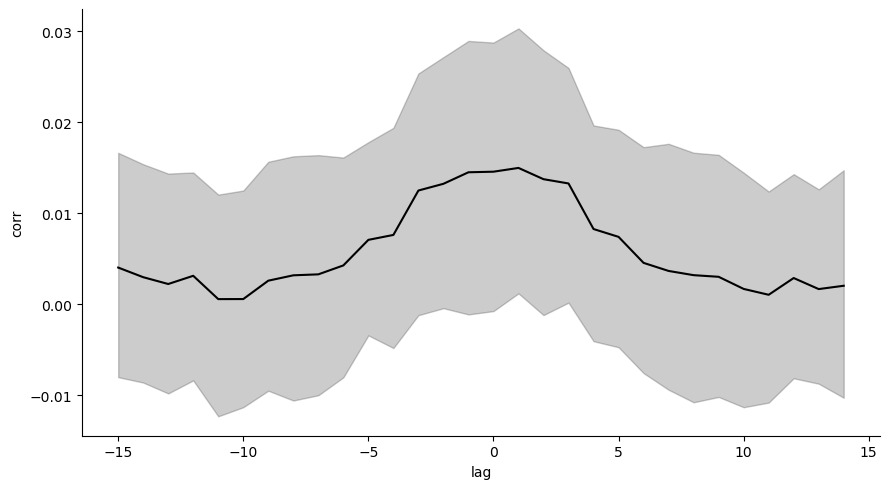

In [40]:
df_lags["u_cond"] = df_lags["participant_condition"] + df_lags["other_condition"]
df_lags["u_dyad"] = df_lags["sid"] + df_lags["dyad"]

df_analysis = df_lags.groupby(["lag", "u_dyad", "participant_condition", "other_condition", "u_cond"]).mean(numeric_only=True).reset_index()


g = sns.relplot(x="lag", y="corr", aspect=1.8, data= df_analysis, kind="line", ci=95, height=5, color="black")

plt.savefig("plots/hr_sync_legend.pdf", bbox_inches='tight')
#g.set(xticklabels=[], yticklabels=[], title='',xlabel=None, ylabel=None)
plt.savefig("plots/hr_sync.pdf", bbox_inches='tight')

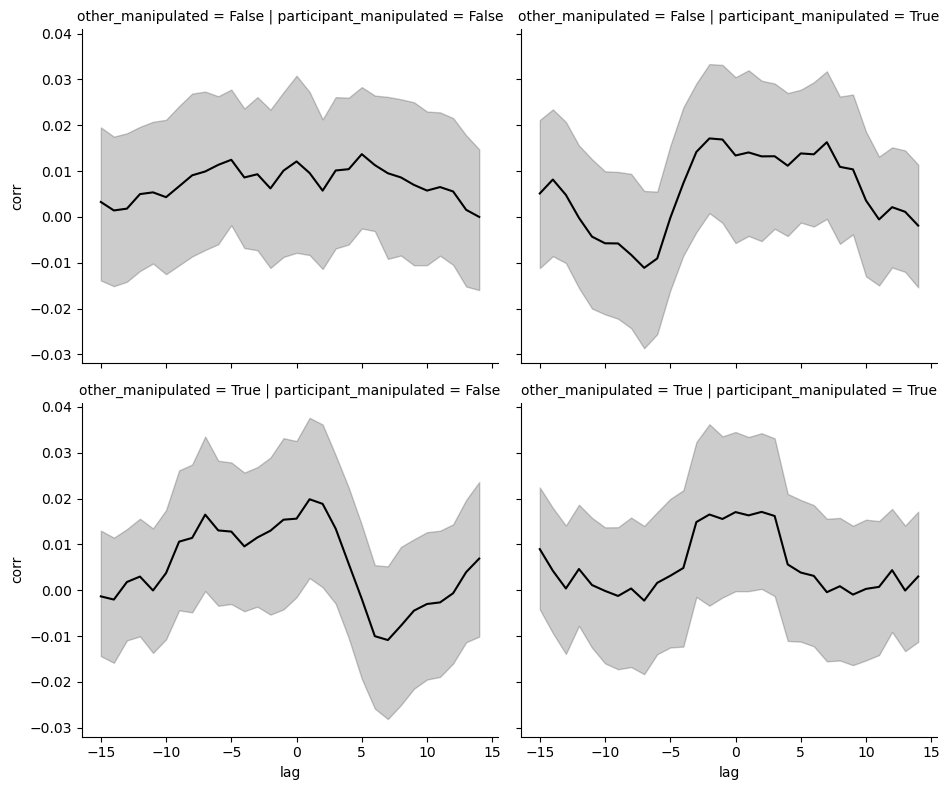

In [44]:
df_lags["u_cond"] = df_lags["participant_condition"] + df_lags["other_condition"]
df_lags["u_dyad"] = df_lags["sid"] + df_lags["dyad"]

df_analysis = df_lags.groupby(["lag", "u_dyad"
                               , "participant_condition", "other_condition"
                               , "participant_manipulated"
                               , "other_manipulated", "u_cond"]).mean(numeric_only=True).reset_index()

g = sns.relplot(x="lag", y="corr", aspect=1.2, data= df_analysis, kind="line", errorbar=('ci', 95), height=4, color="black", col= "participant_manipulated", row="other_manipulated")

#plt.savefig("plots/hr_sync_legend.pdf", bbox_inches='tight')
#g.set(xticklabels=[], yticklabels=[], title='',xlabel=None, ylabel=None)
#plt.savefig("plots/hr_sync.pdf", bbox_inches='tight')

            T  dof alternative  p-val         CI95%  cohen-d   BF10  power
T-test  1.757   87   two-sided  0.083  [-0.0, 0.03]    0.187  0.513  0.412


/var/folders/g5/mqbcmmn575z0s3c021r942c80000gp/T/ipykernel_92009/4153142227.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_analysis = df_analysis.groupby(["u_dyad"]).mean()[["corr"]]


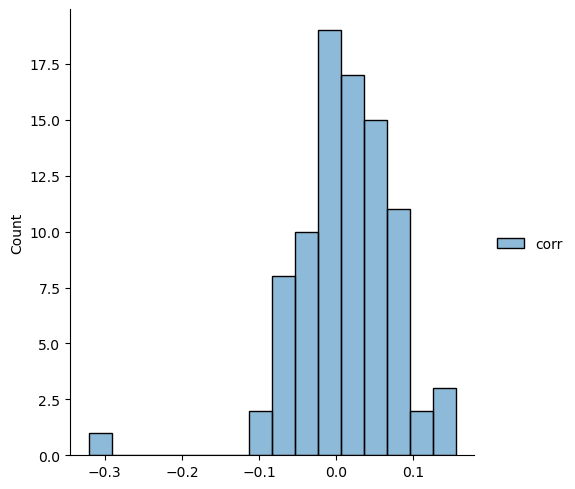

In [67]:
df_analysis = df_lags

df_analysis = df_analysis.loc[df_analysis["lag"] > -6]
df_analysis = df_analysis.loc[df_analysis["lag"] < 6]

df_analysis = df_analysis.groupby(["u_dyad", "participant_condition", "other_condition", "u_cond"]).mean(numeric_only=True).reset_index()

df_analysis = df_analysis.groupby(["u_dyad"]).mean()[["corr"]]

#df_analysis = df_analysis.loc[df_analysis["corr"] > -0.2] # Check that this is an artefact

sns.displot(df_analysis)

from pingouin import ttest
x = df_analysis["corr"].values
print(ttest(x, 0).round(3))

In [68]:
#check if artefact
df_analysis = df_lags
df_analysis = df_analysis.groupby(["u_dyad", "participant_condition", "other_condition", "u_cond"]).mean(numeric_only=True).reset_index()
df_analysis.loc[df_analysis["corr"] < -0.2]

all_data_df = pl.read_csv("data/hr_computed/hr.csv")


u_dyad participant_condition  \
109  mkreal_meeting_experiment_prolific6p1p6                     S   
110  mkreal_meeting_experiment_prolific6p1p6                     U   

    other_condition u_cond  Unnamed: 0  lag      corr  \
109               U     SU     58259.5 -0.5 -0.261916   
110               S     US     58379.5 -0.5 -0.271943   

     participant_manipulated  other_manipulated  Unnamed: 11  index  measure  
109                      0.5                0.5        685.5  685.5      5.5  
110                      0.5                0.5        689.5  689.5      6.0

In [59]:
df_analysis = df_lags
df_analysis = df_analysis.groupby(["u_dyad", "participant_condition", "other_condition", "u_cond"]).mean(numeric_only=True).reset_index()

df_analysis = df_analysis.groupby(["u_dyad"]).mean().reset_index()[["mi"]]

#df_analysis = df_analysis.loc[df_analysis["corr"] > -0.2] # Check that this is an artefact

sns.displot(df_analysis)


x = df_analysis["corr"].values
print(ttest(x, 0).round(3))

KeyError: 'u_dyad'

In [57]:
df_analysis

Unnamed: 0 source_feature target_feature  \
0              0          bpmES          bpmES   
1              1          bpmES          bpmES   
2              2          bpmES          bpmES   
3              3          bpmES          bpmES   
4              4          bpmES          bpmES   
...          ...            ...            ...   
2811        2811          bpmES          bpmES   
2812        2812          bpmES          bpmES   
2813        2813          bpmES          bpmES   
2814        2814          bpmES          bpmES   
2815        2815          bpmES          bpmES   

                                   other_id  \
0          mkprolific_participant_real_21p5   
1          mkprolific_participant_real_21p5   
2          mkprolific_participant_real_21p5   
3          mkprolific_participant_real_21p5   
4          mkprolific_participant_real_21p1   
...                                     ...   
2811  mkreal_meeting_experiment_prolific6p8   
2812  mkreal_meeting_experiment_prolific6p4   
2813  mkreal_meeting_experiment_prolific6p4   
2814  mkreal_meeting_experiment_prolific6p4   
2815  mkreal_meeting_experiment_prolific6p4   

                                    user_id  participant_manipulated  \
0          mkprolific_participant_real_21p1                    False   
1          mkprolific_participant_real_21p1                    False   
2          mkprolific_participant_real_21p1                    False   
3          mkprolific_participant_real_21p1                    False   
4          mkprolific_participant_real_21p5                    False   
...                                     ...                      ...   
2811  mkreal_meeting_experiment_prolific6p4                     True   
2812  mkreal_meeting_experiment_prolific6p8                     True   
2813  mkreal_meeting_experiment_prolific6p8                     True   
2814  mkreal_meeting_experiment_prolific6p8                     True   
2815  mkreal_meeting_experiment_prolific6p8                     True   

      other_manipulated  dyad                                  sid        mi  \
0                  True  p1p5       mkprolific_participant_real_21  0.007324   
1                  True  p1p5       mkprolific_participant_real_21  0.007324   
2                  True  p1p5       mkprolific_participant_real_21  0.007324   
3                  True  p1p5       mkprolific_participant_real_21  0.007324   
4                  True  p1p5       mkprolific_participant_real_21  0.002601   
...                 ...   ...                                  ...       ...   
2811              False  p4p8  mkreal_meeting_experiment_prolific6  0.000000   
2812              False  p4p8  mkreal_meeting_experiment_prolific6  0.009769   
2813              False  p4p8  mkreal_meeting_experiment_prolific6  0.009769   
2814              False  p4p8  mkreal_meeting_experiment_prolific6  0.009769   
2815              False  p4p8  mkreal_meeting_experiment_prolific6  0.009769   

      max_corr  Unnamed: 11  index participant_condition other_condition  \
0     0.135284            0      0                     U               U   
1     0.135284            1      1                     U               U   
2     0.135284            2      2                     U               U   
3     0.135284            3      3                     U               U   
4     0.080401            4      4                     U               U   
...        ...          ...    ...                   ...             ...   
2811  0.199583          799    799                     S               S   
2812  0.186737          800    800                     S               S   
2813  0.186737          801    801                     S               S   
2814  0.186737          802    802                     S               S   
2815  0.186737          803    803                     S               S   

          question_content  measure  
0                    liked      4.0  
1              other_like

In [88]:
#Cluster permutation
#Random subsampling of the data to get as many observations per condition
#Cluster permutation test with mne
import mne

n_permutations = 5000
min_lag = np.min(df_lags["lag"])

#Prepare data
df_analysis = df_lags.copy()
df_analysis = df_analysis.groupby(["lag", "u_dyad"]).mean(numeric_only=True).reset_index().copy()
df_analysis.sort_values(by=["u_dyad", "lag"], inplace=True)

dyads = df_analysis['u_dyad'].unique()
lags = df_analysis['lag'].unique()

# Prepare a list to hold the data for each condition
# Each element of the list is an array of shape (n_dyads, n_timepoints)
data_by_condition = []
significant_clusters_info = []
# Initialize an array for this condition
condition_data = np.empty((len(dyads), len(lags)))

for j, dyad in enumerate(dyads):
    condition_dyad_data = df_analysis[(df_analysis['u_dyad'] == dyad)]
    # Ensure the time series data is complete and in order
    condition_data[j, :] = condition_dyad_data.set_index('lag')["corr"].reindex(lags).ffill().bfill().values.squeeze()

print("This condition has the following dimensions : " + str(condition_data.shape))

#Step 2: Run the Cluster-based Permutation Test for Each Condition
# Run the cluster-based permutation test for each condition
cluster_stats = mne.stats.permutation_cluster_1samp_test(
    condition_data,
    n_permutations=n_permutations,
    threshold=None,
    tail=0,  # Two-tailed test
    out_type='mask',
    verbose=True
)

T_obs, clusters, cluster_p_values, H0 = cluster_stats

# Identify significant clusters
good_cluster_inds = np.where(cluster_p_values < 0.05)[0]

print("Significant clusters:", good_cluster_inds)
print("Cluster p-values:", cluster_p_values[good_cluster_inds])
print("Cluster lag range :", clusters[0][0].start + min_lag, " -- ", clusters[0][0].stop + min_lag)

significant_clusters_info.append({
    "significant_clusters": good_cluster_inds,
    "p_values": cluster_p_values[good_cluster_inds],
})


This condition has the following dimensions : (88, 30)
Using a threshold of 1.987608
stat_fun(H1): min=-0.082687 max=1.941601
Running initial clustering …
Found 0 clusters
Significant clusters: []
Cluster p-values: []


/var/folders/g5/mqbcmmn575z0s3c021r942c80000gp/T/ipykernel_14258/3103157897.py:33: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  cluster_stats = mne.stats.permutation_cluster_1samp_test(


IndexError: index 0 is out of bounds for axis 0 with size 0

In [93]:
T_obs, clusters, cluster_p_values, H0 = cluster_stats

/Users/arias/opt/anaconda3/envs/stim39/lib/python3.9/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  func(*plot_args, **plot_kwargs)


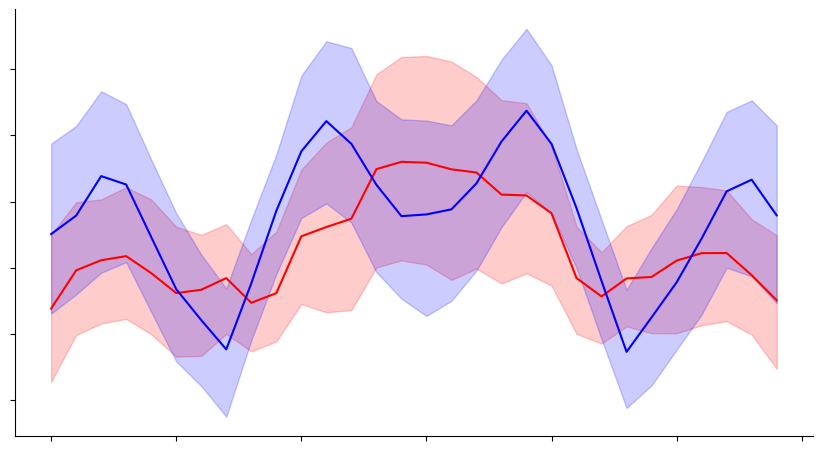

In [64]:
df_lags["u_cond"] = df_lags["participant_condition"] + df_lags["other_condition"]
df_lags["u_dyad"] = df_lags["sid"] + df_lags["dyad"]

df_analysis = df_lags

df_analysis = df_analysis.loc[df_analysis["u_cond"] != "US"]
df_analysis = df_analysis.loc[df_analysis["u_cond"] != "SU"]

#df_analysis = df_analysis.loc[df_analysis["participant_manipulated"] == False]
#df_analysis = df_analysis.loc[df_analysis["other_manipulated"] == False]

#df_analysis = df_analysis.groupby(["lag", "user_id", "participant_condition", "other_condition", "u_cond"]).mean(numeric_only=True).reset_index()

df_analysis = df_analysis.groupby(["lag", "u_dyad", "participant_condition", "other_condition", "u_cond"]).mean(numeric_only=True).reset_index()


g = sns.relplot(x="lag", y="corr", hue="u_cond", aspect=1.8, palette = ["red", "blue"], hue_order= ["SS", "UU"], data= df_analysis, kind="line", ci=68, legend=False, height=5)

plt.savefig("plots/hr_sync_condition_legend.pdf", bbox_inches='tight')
g.set(xticklabels=[], yticklabels=[], title='',xlabel=None, ylabel=None)
plt.savefig("plots/hr_sync_condition.pdf", bbox_inches='tight')

## Correlations

In [75]:
mi_df = pd.read_csv("data/hr_computed/mi_df.csv")
df_lags = pd.read_csv("data/hr_computed/df_lags.csv")

/var/folders/g5/mqbcmmn575z0s3c021r942c80000gp/T/ipykernel_92009/3142613609.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_analysis = mi_df.groupby(['user_id', "other_id", "participant_condition", "other_condition", "question_content"]).mean().reset_index()


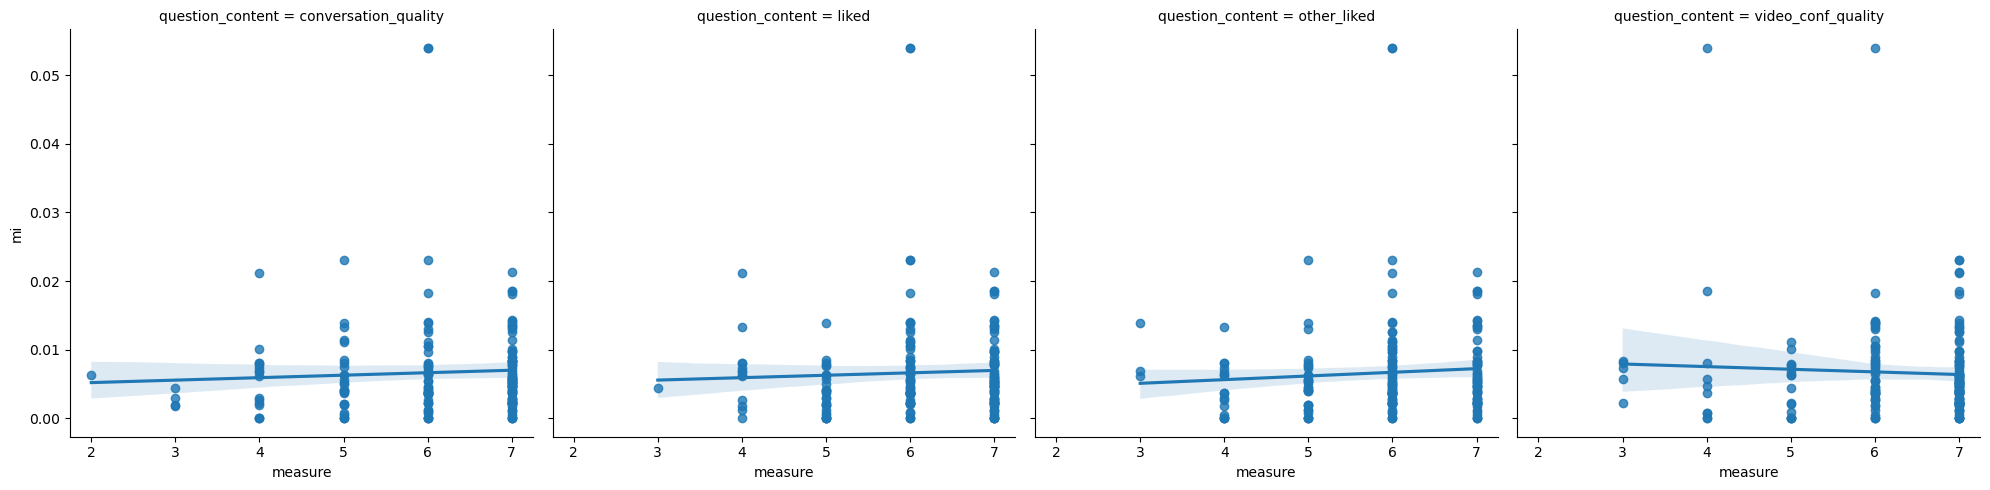

In [76]:
df_analysis = mi_df.groupby(['user_id', "other_id", "participant_condition", "other_condition", "question_content"]).mean().reset_index()

sns.lmplot(y= "mi", x="measure", col="question_content", data=df_analysis)

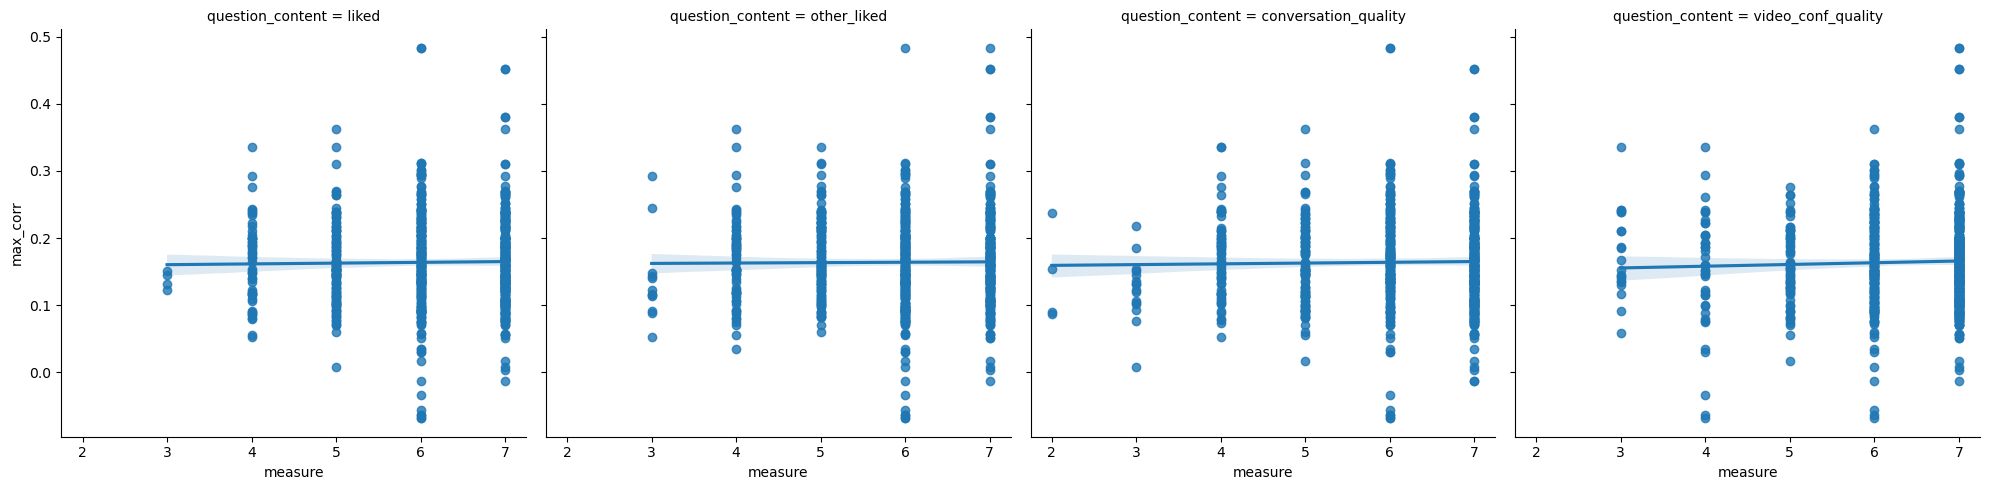

In [77]:
sns.lmplot(y="max_corr", x="measure", col="question_content", data=mi_df)

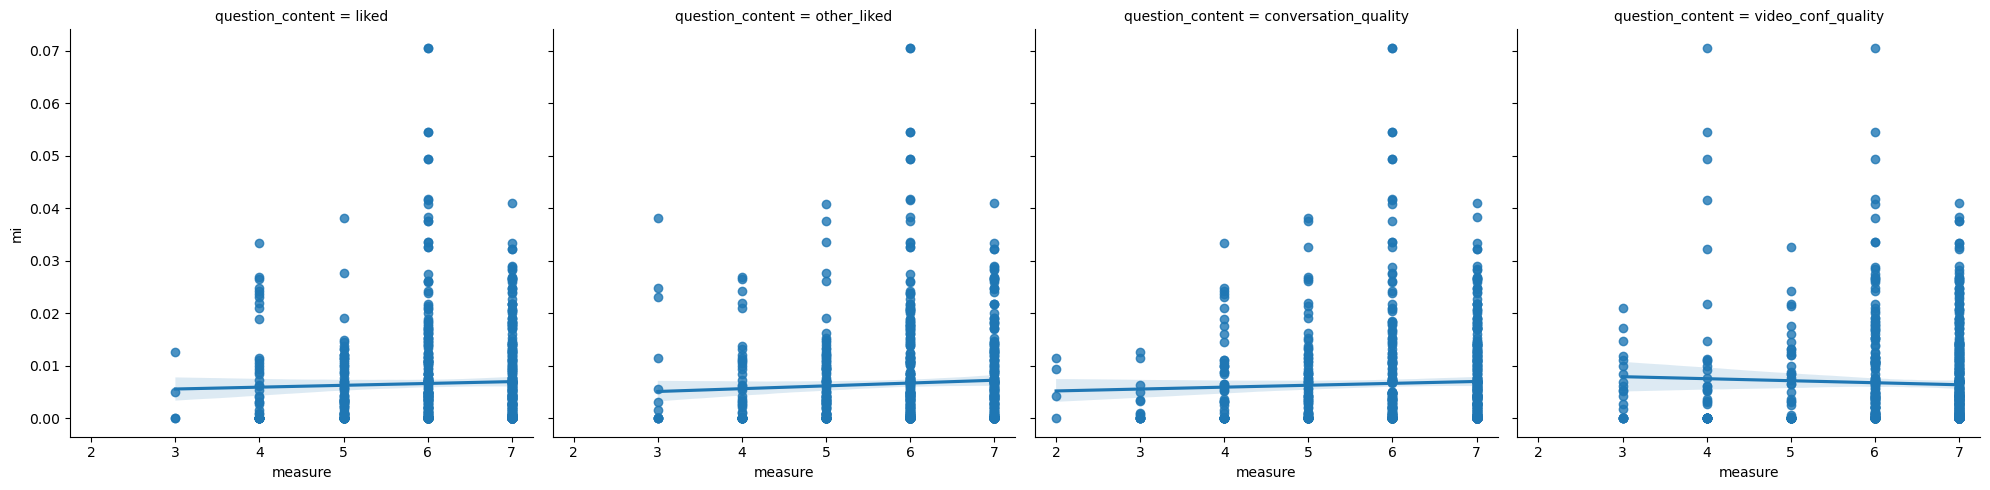

In [78]:
sns.lmplot(y="mi", x="measure", col="question_content", data=mi_df)

In [79]:
from scipy import stats


for ind, df in df_analysis.groupby("question_content"):
    x = df["max_corr"].values
    y = df["measure"].values

    r, p = stats.pearsonr(x, y)
    
    print(ind)
    print( " R : "+ str(r), "p= " + str(p))
    print()
    

conversation_quality
 R : 0.02871183905461902 p= 0.705230461801733

liked
 R : 0.02489864511330723 p= 0.7429003147536658

other_liked
 R : 0.0134424380918107 p= 0.8594523399299845

video_conf_quality
 R : 0.05922969046727043 p= 0.43488636085147353



# Synchrony 2nd measure

In [2]:
behavior_df = pl.read_csv("data/behavior/all_data_df.csv")
behavior_df = behavior_df.with_columns(
    pl.col("sid").str.replace_all(":", "").alias("sid"),
    pl.col("user_id").str.replace_all(":", "").alias("user_id"),
    pl.col("other_id").str.replace_all(":", "").alias("other_id")
)

In [68]:
all_data_df = pd.read_csv("data/hr_computed/hr.csv")

#ts_df = all_data_df.groupby(["sid", "dyad", "user_id", "other_id", "participant_condition", "other_condition", "file_name", "manipulated", "time"]).mean(numeric_only=True).reset_index()

ts_df = all_data_df.groupby(["sid", "dyad", "user_id", "other_id", "participant_condition", "other_condition", "file_name", "manipulated", "time"]).mean(numeric_only=True).reset_index()


/tmp/ipykernel_982/2820608948.py:1: DtypeWarning: Columns (12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  all_data_df = pd.read_csv("data/hr_computed/hr.csv")


In [69]:
#define global features
other_manipulations = [True, False]
source_features = ["bpmES"]
target_features = ["bpmES"]

In [70]:
#Check which interactions were recorded correctly and can be used for this analysis:
correct_interactions   = []
incorrect_interactions = []
for interaction in glob.glob("../preproc/prolific/*/trimed/*"):
    recordings = glob.glob(interaction + "/*.mp4")
    if len(recordings)==4:
        sid = interaction.split("/")[3]
        dyad = interaction.split("/")[5][2:]

        correct_interactions.append((sid, dyad))
    else:
        incorrect_interactions.append((sid, dyad))

print("Found "+ str(len(correct_interactions)) + " correct interactions")
print("Found "+ str(len(incorrect_interactions)) + " incorrect interactions")

Found 113 correct interactions
Found 21 incorrect interactions


In [71]:
import numpy as np
from scipy.special import erfcinv

#For time series normalisation
def copnorm(x):
    """
    COPNORM Copula normalization
    cx = copnorm(x) returns standard normal samples with the same empirical
    CDF value as the input. Operates along the first axis.
    Equivalent to cx = norminv(ctransform(x))
    """
    # Rank the data
    ranks = np.argsort(np.argsort(x, axis=0), axis=0)
    
    # Normalize the ranks
    n = x.shape[0]
    x_normalized = (ranks + 1) / (n + 1)
    
    # Transform to standard normal
    x_standard_normal = -np.sqrt(2) * erfcinv(2 * x_normalized)
    
    return x_standard_normal

In [72]:
# Initialize the dataframes with the correct schema if they are not initialized
df_lags_schema = {
    "lag": pl.Int64,
    "corr": pl.Float64,
    "dyad": pl.Utf8,
    "source_feature": pl.Utf8,
    "target_feature": pl.Utf8,
    "participant_manipulated": pl.Boolean,
    "other_manipulated": pl.Boolean,
    "other_id": pl.Utf8,
    "sid": pl.Utf8,
    "user_id": pl.Utf8,
    "window": pl.Int64,
    "start": pl.Int64,
    "start_time": pl.Int64,
    "real_dyad": pl.Utf8,
    "repetition_nb": pl.Int64
}

mi_df_schema = {
    "source_feature": pl.Utf8,
    "target_feature": pl.Utf8,
    "other_id": pl.Utf8,
    "user_id": pl.Utf8,
    "participant_manipulated": pl.Boolean,
    "other_manipulated": pl.Boolean,
    "dyad": pl.Utf8,
    "sid": pl.Utf8,
    "mi": pl.Float64,
    "max_corr": pl.Float64,
    "mean_corr": pl.Float64,
    "window": pl.Int64,
    "start": pl.Int64,
    "start_time": pl.Int64,
    "real_dyad": pl.Utf8,
    "repetition_nb": pl.Int64
}

In [73]:
#Function to compute synchrony
import random; 
def compute_synchrony(sid, participant_manipulated, other_manipulated, dyad, user_id, dyad_df, ts_df, overlap, window_length, save_plot, nb_min_samples, lag, real_dyad):
    mi_df   = pl.DataFrame(schema=mi_df_schema)
    df_lags = pl.DataFrame(schema=df_lags_schema)
    
    #Check if interaction was recorded correctly (4 recordings in total).
    found=False
    for interaction in correct_interactions:
        if sid == interaction[0] and dyad == interaction[1]:
            found = True
            break
    if not found:
        #print("Skipping not correct recording - dyad : " + dyad + " sid : " + sid)
        return None, None
        
    #Prepare participants' time series
    participant_df = dyad_df.loc[dyad_df["user_id"] == user_id].copy()
    participant_df = participant_df.ffill(axis="rows")
    participant_df = participant_df.bfill(axis="rows")
    
    other_id = participant_df["other_id"]
    nulls = np.unique(other_id.isnull())
    if len(nulls)==1 and nulls[0]:
        return None, None

    other_id = np.unique(other_id)[0]  

    if real_dyad:
        partner_dyad = dyad
        partner_other_id= other_id

    #Find surrogate dyad
    else :
        #Choose a random participant
        filtered_list = [tup for tup in correct_interactions if tup[0] != user_id]
        filtered_list = [tup for tup in filtered_list if tup[0] != other_id]
        filtered_list = [tup for tup in filtered_list if tup[1] != user_id]
        filtered_list = [tup for tup in filtered_list if tup[1] != other_id]
        #Change other_id
        partner_sid, partner_dyad  = random.choice(filtered_list)
        partner_other_id  =  partner_sid + random.choice((partner_dyad[0:2], partner_dyad[2:4]))

    #Select time series of the partner
    partner_df = ts_df.loc[ts_df["user_id"] == partner_other_id].copy()
    partner_df = partner_df.loc[partner_df["dyad"] == partner_dyad]    
    partner_df = partner_df.loc[partner_df["manipulated"] == other_manipulated]        
    partner_df = partner_df.ffill(axis="rows")
    partner_df = partner_df.bfill(axis="rows")

    if not len(partner_df)>0:
        return None, None
        
    for repetition_nb in range(nb_of_surrogate_perms):
        #If real dyad value has already been computed
        if repetition_nb>1 and real_dyad:
            continue
            
        for source_feature in source_features:
            for target_feature in target_features:    
                #preapre participant time series
                X = participant_df[source_feature].values
    
                #preapre target time series
                y = partner_df[target_feature].values
    
                if len(y)==0 or len(X) ==0 or len(y)< nb_min_samples or len(X)< nb_min_samples:
                    continue            
                
                #Keep only the same number of samples for both
                max = np.min([len(X), len(y)])
                X = X[0:max]
                y = y[0:max]
    
                start = 0
                window = 0
                while start + window_length< len(X):
                    
                    sub_X  = X[start:start+window_length]
                    sub_Y =  y[start:start+window_length]
    
                    has_infs = np.isinf(sub_Y).any() or np.isinf(sub_Y).any() 
                    has_nans = np.isnan(sub_X).any() or np.isnan(sub_X).any()
                    if has_infs:
                        print("careful, Y or X has infs")
                    if has_nans:
                        print("careful, Y or X has nans")
    
                    if len(sub_X) < lag:
                        start = start+overlap
                        window += 1
                        continue
    
                    #cross-correlation
                    std_X = np.nanstd(sub_X)
                    std_Y = np.nanstd(sub_Y)
                    if std_X == 0 or std_Y == 0:
                        print(f"Zero standard deviation found")
                        #Update window information
                        start = start+overlap
                        window += 1
                        continue
                    
                    corr_X = [(val-np.nanmean(sub_X))/np.nanstd(sub_X) for val in sub_X]
                    corr_y = [(val-np.nanmean(sub_Y))/np.nanstd(sub_Y) for val in sub_Y]
                    corr = signal.correlate(corr_X, corr_y, mode='same') 
                    corr = corr  / len(sub_X)
    
                    #Select only cross correaltion between +/- lag
                    selected_corr = corr[round(len(corr)/2 - lag): round(len(corr)/2 + lag)]
    
                    #Check selected corrs:
                    has_infs = np.isinf(corr_X).any() or np.isinf(corr_y).any() 
                    has_nans = np.isnan(corr_X).any() or np.isnan(corr_y).any()
                    if has_infs:
                        print("careful, Corr has infs")
                    if has_nans:
                        print("careful, Corr has nans")
    
                    #Compute pearson correlation and max cross correlation coeff
                    pears_r, p = stats.pearsonr(corr_X, corr_y)
                    max_corr = np.arctanh(np.nanmax(selected_corr))
    
                    # Fisher Z Transformation
                    #Clamp values in array (don't allow 1 or -1 to be in the arrays)
                    Z_scores = np.arctanh(selected_corr)
                    has_infs = np.isinf(Z_scores).any() or np.isinf(Z_scores).any()
                    has_nans = np.isnan(corr_X).any() or np.isnan(corr_y).any()
                    if has_infs:
                        #print("careful, Z_scores has infs")
                        start = start+overlap
                        window += 1
                        continue
                    if has_nans:
                        #print("careful, Z_scores has nans")
                        start = start+overlap
                        window += 1
                        continue
                    
                    mean_Z = np.nanmean(Z_scores) # Compute the mean of Z scores
                    mean_corr = np.tanh(mean_Z) # Inverse Fisher Z Transformation to get the average correlation
    
                    #Compute MI
                    sub_X = sub_X.reshape(-1,1)      
                    mi = mutual_info_regression(X=copnorm(sub_X), y=copnorm(sub_Y)
                                    , discrete_features = 'auto'
                                    , n_neighbors = 30
                                    , copy = True
                                    , random_state=None
                                )
    
                    if save_plot:                
                        plt.figure(figsize=(12,5))
                        plt.plot(sub_X)
                        plt.plot(sub_Y)
                        plt.savefig("plots/hr/"+str(sid)+ str(dyad)+ str(user_id)+str(participant_manipulated)+".pdf")
    
    
                    #Save results to a DataFrame
                    aux_df = pl.DataFrame({
                        "source_feature": [source_feature],
                        "target_feature": [target_feature],
                        "other_id": [other_id],
                        "user_id": [user_id],
                        "participant_manipulated": [bool(participant_manipulated)],
                        "other_manipulated": [bool(other_manipulated)],
                        "dyad": [dyad],
                        "sid": [sid],
                        "mi": mi,
                        "max_corr": [max_corr],
                        "mean_corr": [mean_corr],
                        "window": [window],
                        "start": [start],
                        "start_time": [start],
                        "real_dyad": [bool(real_dyad)],
                        "repetition_nb": [repetition_nb]
                    })
                    
    
                    aux_lags_df = pl.DataFrame({
                        "lag": pl.Series("lag", range(2 * lag)) - lag,
                        "corr": selected_corr,
                        "dyad": [dyad] * (2 * lag),
                        "source_feature": [source_feature] * (2 * lag),
                        "target_feature": [target_feature] * (2 * lag),
                        "participant_manipulated": [bool(participant_manipulated)] * (2 * lag),
                        "other_manipulated": [bool(other_manipulated)] * (2 * lag),
                        "other_id": [other_id] * (2 * lag),
                        "sid": [sid] * (2 * lag),
                        "user_id": [user_id] * (2 * lag),
                        "window": [window] * (2 * lag),
                        "start": [start] * (2 * lag),
                        "start_time": [start] * (2 * lag),
                        "real_dyad": [bool(real_dyad)] * (2 * lag),
                        "repetition_nb": [real_dyad] * (2 * lag)
                    })
                    aux_df = aux_df.with_columns([pl.col(column).cast(dtype) for column, dtype in mi_df_schema.items()])
                    aux_lags_df = aux_lags_df.with_columns([pl.col(column).cast(dtype) for column, dtype in df_lags_schema.items()])

                    df_lags = pl.concat([df_lags, aux_lags_df])
                    mi_df = pl.concat([mi_df, aux_df])

    
                    #Update window information
                    start = start+overlap
                    window += 1
                    
    return df_lags, mi_df

In [60]:
from joblib import Parallel, delayed


## ---- Good parameters for MI estimation
#Both manipulated with the same value
lag = 15 # In seconds before and after
nb_min_samples = 150 #in seconds. 
window_length  = 120 #seconds
overlap = 1
save_plot = False
nb_of_surrogate_perms = 1 #nb of surrogate dyads to compute per dyad

# Create a process group function for parallelisation
def process_group(sid, participant_manipulated, other_manipulated, dyad, user_id, dyad_df, ts_df, overlap, window_length, save_plot, nb_min_samples, lag, real_dyad):
    return compute_synchrony(sid, participant_manipulated, other_manipulated, dyad, user_id, dyad_df, ts_df, overlap, window_length, save_plot, nb_min_samples, lag, real_dyad)


def main():
    tasks = []

    #Appending all the tasks
    for real_dyad in [True, False]:
        for other_manipulated in other_manipulations:
            for (sid, participant_manipulated, dyad, user_id), dyad_df in ts_df.groupby(["sid", "manipulated", "dyad", "user_id"]):
                tasks.append((sid, participant_manipulated, other_manipulated, dyad, user_id, dyad_df, ts_df, overlap, window_length, save_plot, nb_min_samples, lag, real_dyad))

    # Using joblib.Parallel and delayed to handle multiple arguments
    print("Performing jobs in parallel - start")
    results = Parallel(n_jobs=-1)(delayed(process_group)(
        sid, participant_manipulated, other_manipulated, dyad, user_id, dyad_df, ts_df, overlap, window_length, save_plot, nb_min_samples, lag, real_dyad
    ) for sid, participant_manipulated, other_manipulated, dyad, user_id, dyad_df, ts_df, overlap, window_length, save_plot, nb_min_samples, lag, real_dyad in tasks)
    print("Performing jobs in parallel - stop")
    
    aux_lags_list = []
    aux_mi_df_list = []
    
    # Collecting results
    for aux_lags, aux_mi_df in results:
        if aux_lags is not None: 
            aux_lags_list.append(aux_lags)
        if aux_mi_df is not None:
            aux_mi_df_list.append(aux_mi_df)

    print("Concatenating results - start")
    # Concatenate all collected DataFrames at once
    df_lags = pl.concat( aux_lags_list, how="vertical")
    mi_df = pl.concat(aux_mi_df_list, how="vertical")
    print("Concatenating results - stop")
    
    return df_lags.to_pandas(), mi_df.to_pandas()

if __name__ == "__main__":
    df_lags, mi_df = main()


Performing jobs in parallel - start


/tmp/ipykernel_982/300699631.py:122: RuntimeWarning: invalid value encountered in arctanh
/tmp/ipykernel_982/300699631.py:126: RuntimeWarning: invalid value encountered in arctanh
/tmp/ipykernel_982/300699631.py:122: RuntimeWarning: invalid value encountered in arctanh
/tmp/ipykernel_982/300699631.py:126: RuntimeWarning: invalid value encountered in arctanh
/tmp/ipykernel_982/300699631.py:122: RuntimeWarning: divide by zero encountered in arctanh
/tmp/ipykernel_982/300699631.py:126: RuntimeWarning: divide by zero encountered in arctanh
/tmp/ipykernel_982/300699631.py:122: RuntimeWarning: invalid value encountered in arctanh
/tmp/ipykernel_982/300699631.py:126: RuntimeWarning: invalid value encountered in arctanh
/tmp/ipykernel_982/300699631.py:122: RuntimeWarning: divide by zero encountered in arctanh
/tmp/ipykernel_982/300699631.py:126: RuntimeWarning: divide by zero encountered in arctanh
/tmp/ipykernel_982/300699631.py:122: RuntimeWarning: invalid value encountered in arctanh
/tmp/i

Performing jobs in parallel - stop
Concatenating results - start
Concatenating results - stop


In [61]:
mi_df   = mi_df.merge(behavior_df.to_pandas()    , on=["sid", "dyad", "user_id", "other_id"], how="left")
df_lags = df_lags.merge(behavior_df.to_pandas()  , on=["sid", "dyad", "user_id", "other_id"], how="left")

In [ ]:
mi_df.to_csv("data/hr_computed/mi3_df.csv")
df_lags.to_csv("data/hr_computed/df3_lags.csv")

/mnt/autofs/data/userdata/project0028/video_analysis/hr_synchrony_analysis/all_synchrony.py:312: DtypeWarning: Columns (12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  all_data_df = pd.read_csv("data/hr_computed/hr.csv")
Found 113 correct interactions
Found 21 incorrect interactions
Performing jobs in parallel - start
^C


## Synchrony 2 Analysis

## MI

In [ ]:
import pandas as pd
mi_df = pd.read_csv("data/hr_computed/mi3_df.csv")
df_lags = pd.read_csv("data/hr_computed/df3_lags.csv")

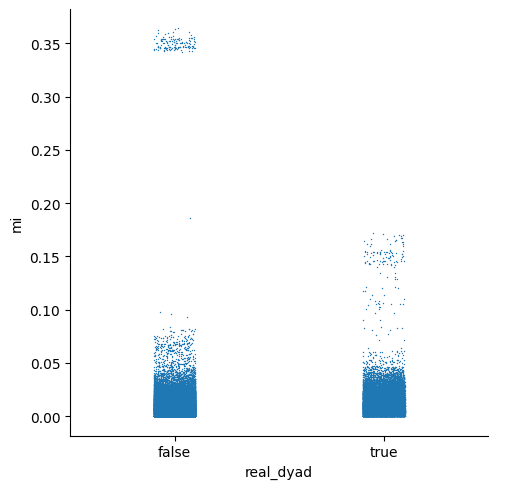

In [62]:
df_analysis = mi_df.groupby(["sid", "dyad", "user_id", "other_id", "real_dyad", "window", "repetition_nb"])[["mi"]].mean().reset_index()

#df_analysis = df_analysis.loc[df_analysis["mi"]<0.2]

sns.catplot(y="mi", x="real_dyad"
                  , data=df_analysis
                  , aspect=1
                  , height=5
                  , size= 1
           )

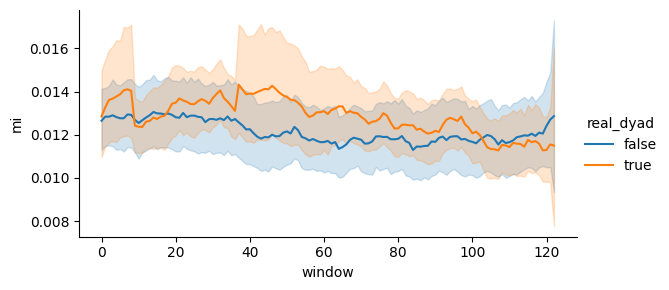

In [63]:
df_analysis = mi_df.groupby(["sid", "dyad", "user_id", "other_id", "real_dyad", "window"])[["mi"]].mean().reset_index()

df_analysis = df_analysis.loc[df_analysis["mi"]<0.15]

sns.relplot(x="window", y="mi",hue="real_dyad", data=df_analysis, aspect=2, height=3, kind="line")

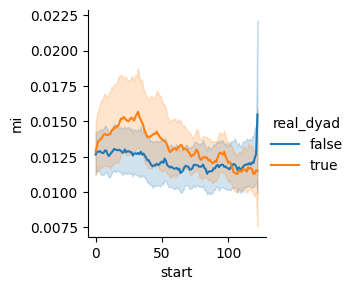

In [64]:
df_analysis = mi_df.groupby(["sid", "dyad", "user_id", "other_id", "real_dyad", "start"])[["mi"]].mean().reset_index()

df_analysis = df_analysis.loc[df_analysis["mi"] < 0.2]

sns.relplot(x="start", y="mi",hue="real_dyad", data=df_analysis, aspect=1, height=3, kind="line")

AssertionError: y cannot be an empty list or array.

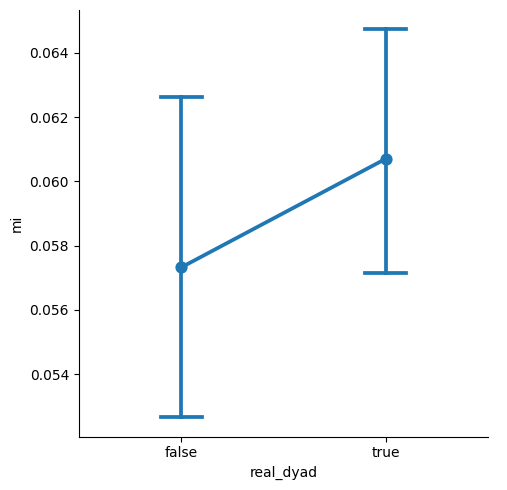

In [65]:
df_analysis = mi_df.groupby(["sid", "dyad", "user_id", "other_id", "real_dyad"])[["mi"]].max().reset_index()

df_analysis = df_analysis.loc[df_analysis["mi"]<0.4]

sns.catplot(y="mi", x="real_dyad", kind="point", data=df_analysis, aspect=1, capsize=0.2)

x = df_analysis.loc[df_analysis["real_dyad"] == True]["mi"].values
y = df_analysis.loc[df_analysis["real_dyad"] == False]["mi"].values
print(pingouin.ttest(x, y, paired=True).round(3))

In [ ]:

df_analysis = mi_df.groupby(["sid", "dyad", "user_id", "other_id", "real_dyad"])[["mi"]].mean().reset_index()

df_analysis = df_analysis.loc[df_analysis["mi"]<0.4]

sns.catplot(x="real_dyad"
            , y="mi"
            , data=df_analysis
            , kind="point"
            , capsize=0.2
            )

sns.catplot(x="real_dyad"
            , y="mi"
            , data=df_analysis
            , kind="box"            
            )
sns.catplot( x="real_dyad"
            , y="mi"
            , data=df_analysis            
            )

x = df_analysis.loc[df_analysis["real_dyad"] == True]["mi"].values
y = df_analysis.loc[df_analysis["real_dyad"] == False]["mi"].values
print(pingouin.ttest(x, y).round(3))

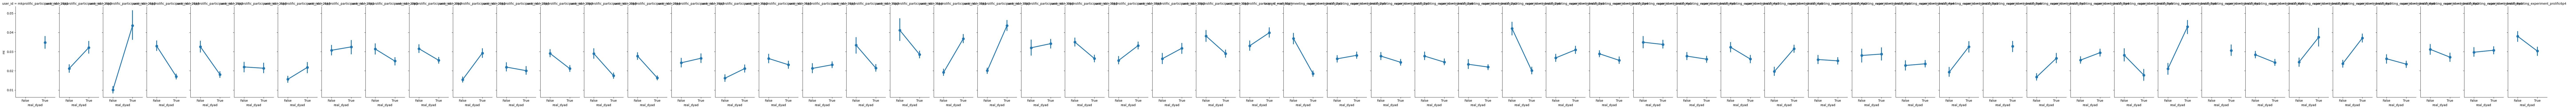

In [45]:
df_analysis = mi_df.groupby(["sid", "dyad", "user_id", "other_id", "real_dyad", "window"])[["mi"]].max().reset_index()

df_analysis = df_analysis.loc[df_analysis["mi"]<1]

sns.catplot(y="mi", x="real_dyad", col="user_id", kind="point", data=df_analysis, aspect=0.4)

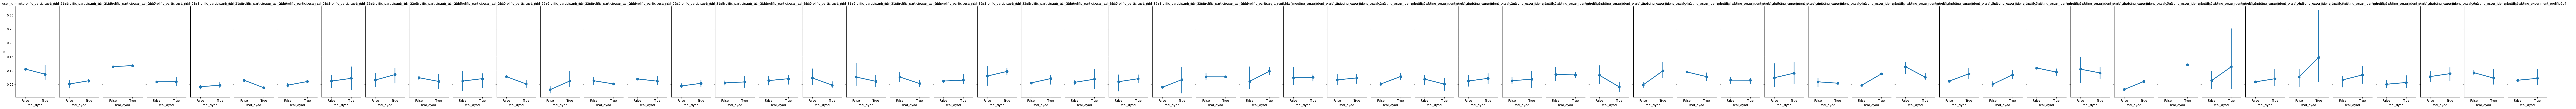

In [77]:
df_analysis = mi_df.groupby(["sid", "dyad", "user_id", "other_id", "real_dyad"])[["mi"]].max().reset_index()

df_analysis = df_analysis.loc[df_analysis["mi"]<1]

sns.catplot(y="mi", x="real_dyad", col="user_id", kind="point", data=df_analysis, aspect=0.4)

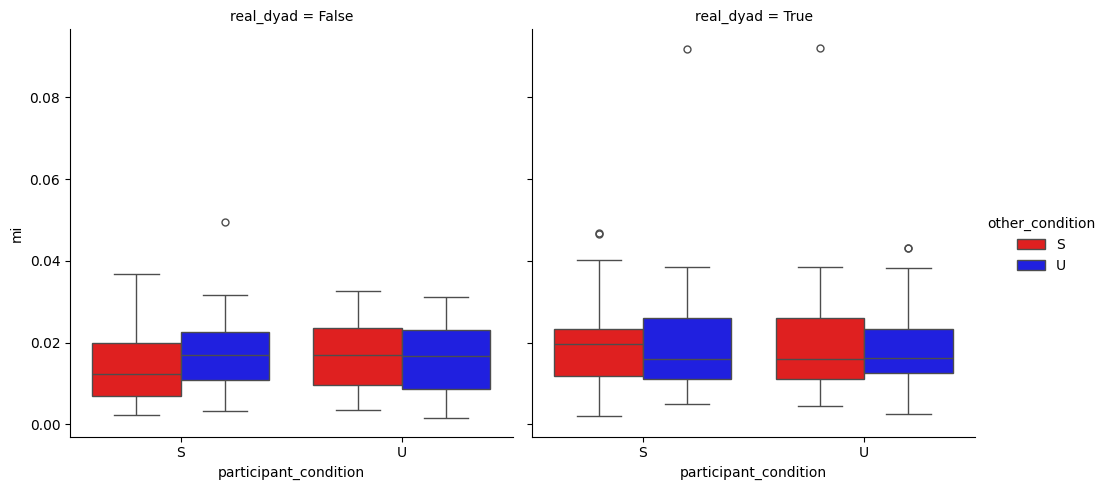

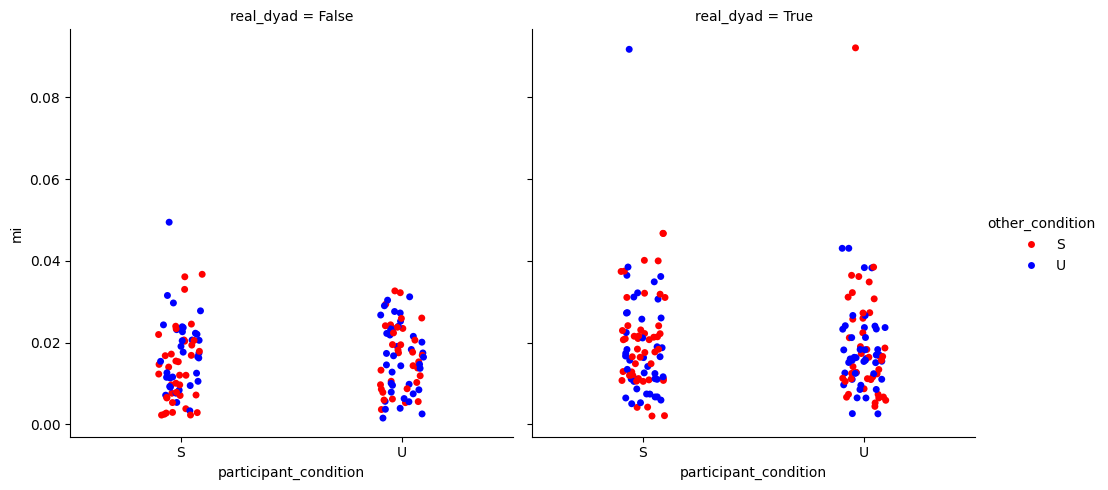

In [36]:

df_analysis = mi_df.groupby(["sid", "dyad", "user_id", "other_id", "participant_condition", "other_condition", "real_dyad"])[["mi"]].mean().reset_index()

df_analysis = df_analysis.loc[df_analysis["mi"]<0.2]

sns.catplot(x="participant_condition"
            , hue="other_condition"
            , y="mi"
            , data=df_analysis
            , kind="box"
            , col="real_dyad"
            , palette=sns.color_palette(['red', 'blue'])
            , order=["S", "U"]
            , hue_order=["S", "U"]
            
            )
sns.catplot(x="participant_condition"
            , hue="other_condition"
            , y="mi"
            , col="real_dyad"
            , data=df_analysis
            , palette=sns.color_palette(['red', 'blue'])
            , order=["S", "U"]
            , hue_order=["S", "U"]
            )

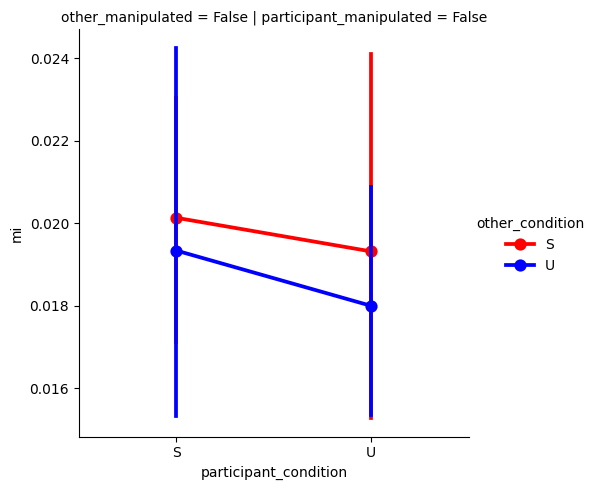

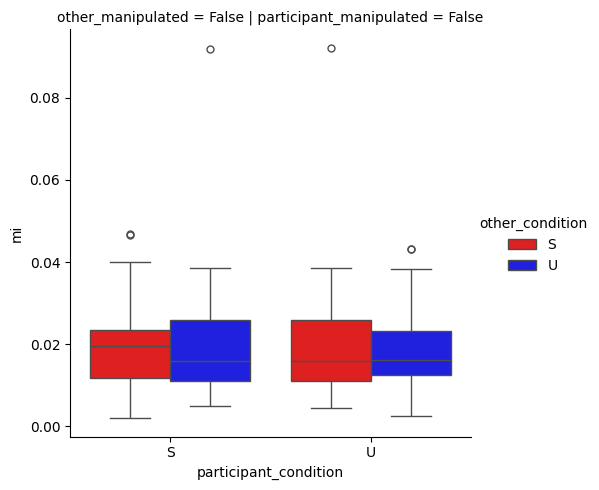

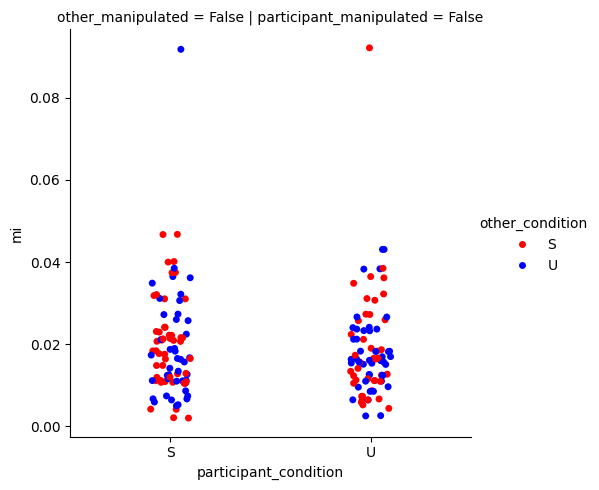

In [32]:
df_analysis = mi_df.groupby(["sid", "dyad", "user_id", "other_id", "participant_condition", "other_condition", "participant_manipulated", "other_manipulated", "real_dyad"])[["mi"]].mean().reset_index()

df_analysis = df_analysis.loc[df_analysis["mi"]<0.2]
df_analysis = df_analysis.loc[df_analysis["real_dyad"] == True]

sns.catplot(x="participant_condition"
            , hue="other_condition"
            , y="mi"
            , col="participant_manipulated"
            , row="other_manipulated"
            , data=df_analysis
            , palette=sns.color_palette(['red', 'blue'])
            , order=["S", "U"]
            , kind="point"
            , hue_order=["S", "U"]
            )

sns.catplot(x="participant_condition"
            , hue="other_condition"
            , y="mi"
            , col="participant_manipulated"
            , row="other_manipulated"
            , data=df_analysis
            , kind="box"
            , palette=sns.color_palette(['red', 'blue'])
            , order=["S", "U"]
            , hue_order=["S", "U"]
            )
sns.catplot(x="participant_condition"
            , hue="other_condition"
            , col="participant_manipulated"
            , row="other_manipulated"
            , y="mi"
            , data=df_analysis
            , palette=sns.color_palette(['red', 'blue'])
            , order=["S", "U"]
            , hue_order=["S", "U"]
            )

## Max Corr

            T      dof alternative  p-val          CI95%  cohen-d   BF10  \
T-test -0.026  307.424   two-sided  0.979  [-0.01, 0.01]    0.003  0.123   

        power  
T-test   0.05  


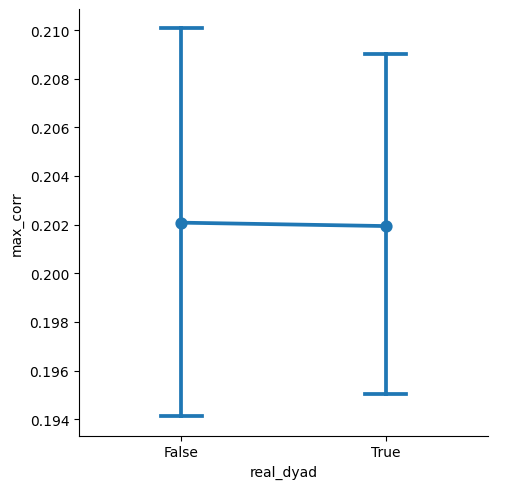

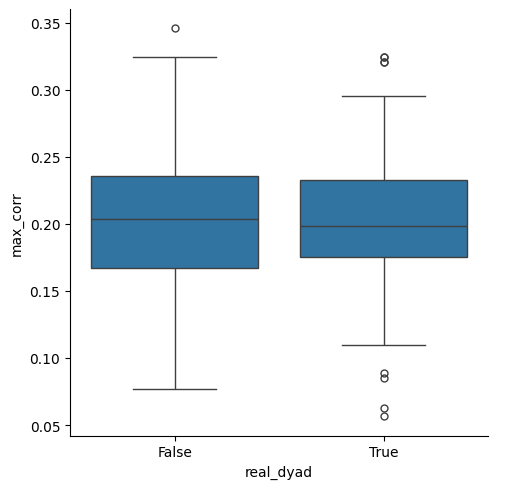

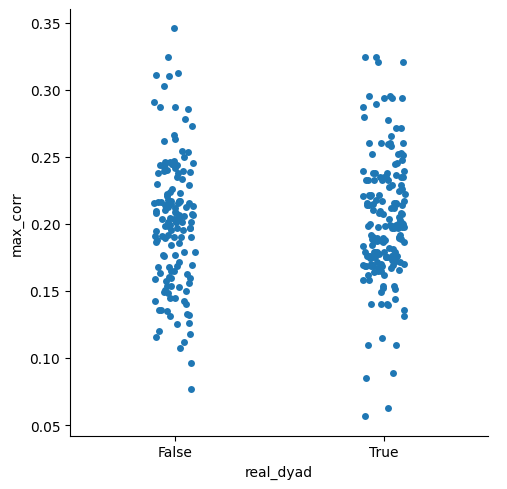

In [54]:
df_analysis = mi_df.groupby(["sid", "dyad", "user_id", "other_id", "real_dyad"])[["max_corr"]].mean().reset_index()

#df_analysis = df_analysis.loc[df_analysis["mi"]<0.05]

sns.catplot(x="real_dyad"
            , y="max_corr"
            , data=df_analysis
            , kind="point"  
            ,capsize=0.2          
            )
sns.catplot(x="real_dyad"
            , y="max_corr"
            , data=df_analysis
            , kind="box"            
            )
sns.catplot( x="real_dyad"
            , y="max_corr"
            , data=df_analysis            
            )



x = df_analysis.loc[df_analysis["real_dyad"] == True]["max_corr"].values
y = df_analysis.loc[df_analysis["real_dyad"] == False]["max_corr"].values
print(pingouin.ttest(x, y).round(3))

/var/folders/g5/mqbcmmn575z0s3c021r942c80000gp/T/ipykernel_65750/264550707.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_analysis = mi_df.groupby(["sid", "dyad", "user_id", "other_id", "participant_condition", "other_condition", "participant_manipulated", "other_manipulated", "surrogate"]).mean().reset_index()


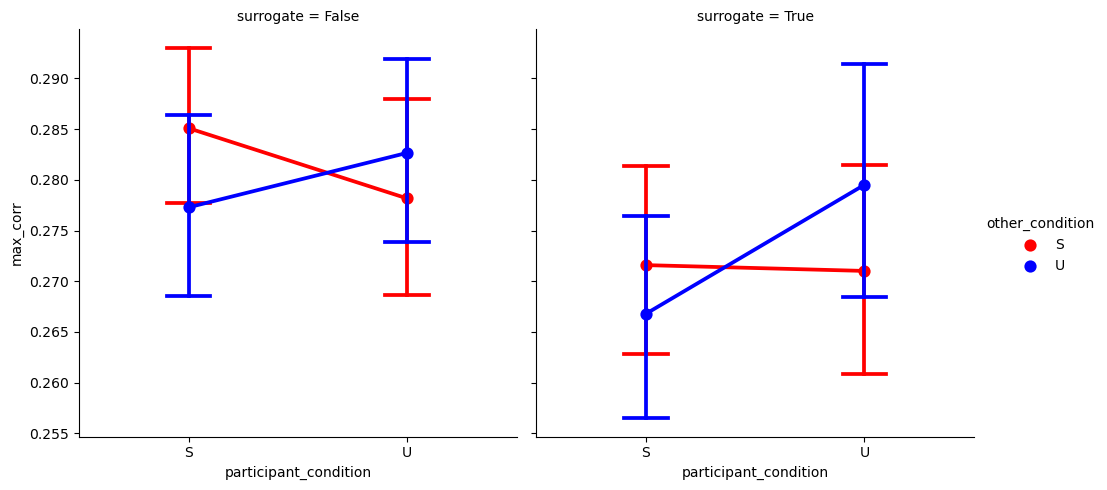

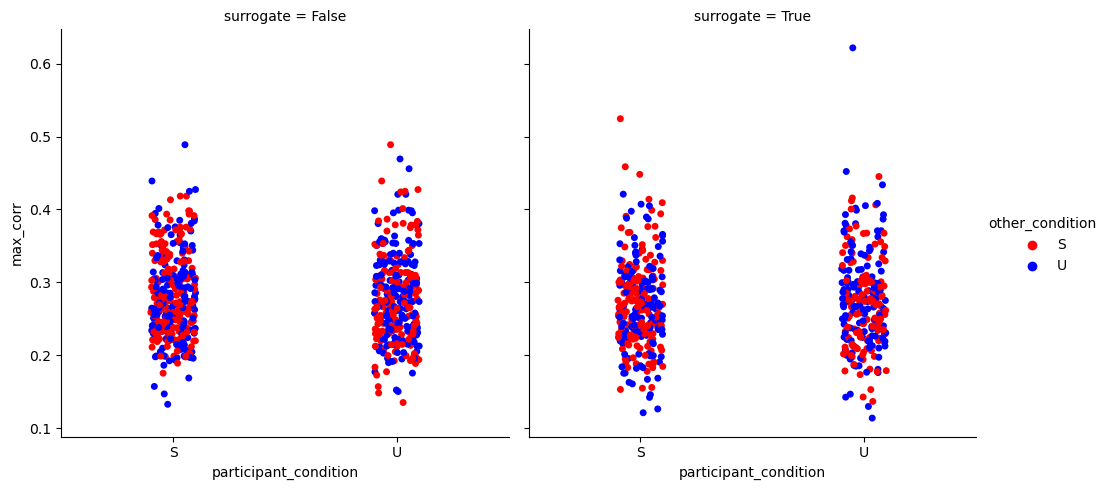

In [123]:
df_analysis = mi_df.groupby(["sid", "dyad", "user_id", "other_id", "participant_condition", "other_condition", "participant_manipulated", "other_manipulated", "real_dyad"]).mean().reset_index()


sns.catplot(x="participant_condition"
            , hue="other_condition"
            , y="max_corr"
            , col="real_dyad"
            , data=df_analysis
            , kind="point"
            , capsize=0.2
            , palette=sns.color_palette(['red', 'blue'])
            , order=["S", "U"]
            , hue_order=["S", "U"]
            )
sns.catplot(x="participant_condition"
            , hue="other_condition"
            , y="max_corr"
            , data=df_analysis
            , palette=sns.color_palette(['red', 'blue'])
            , order=["S", "U"]
            , hue_order=["S", "U"]
            , col="real_dyad"
            )

/var/folders/g5/mqbcmmn575z0s3c021r942c80000gp/T/ipykernel_65750/542759960.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_analysis = mi_df.groupby(["sid", "dyad", "user_id", "other_id", "participant_condition", "other_condition", "participant_manipulated", "other_manipulated", "surrogate"]).mean().reset_index()


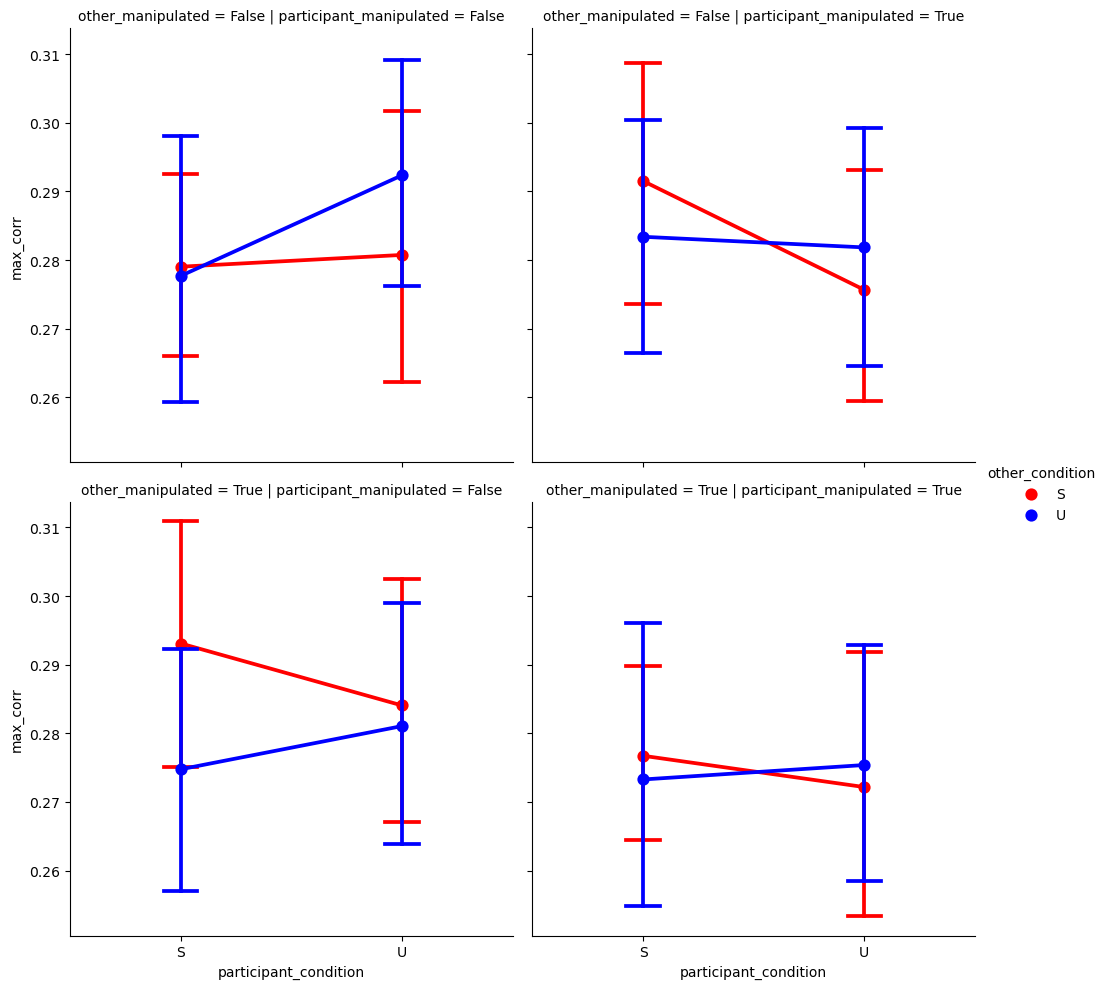

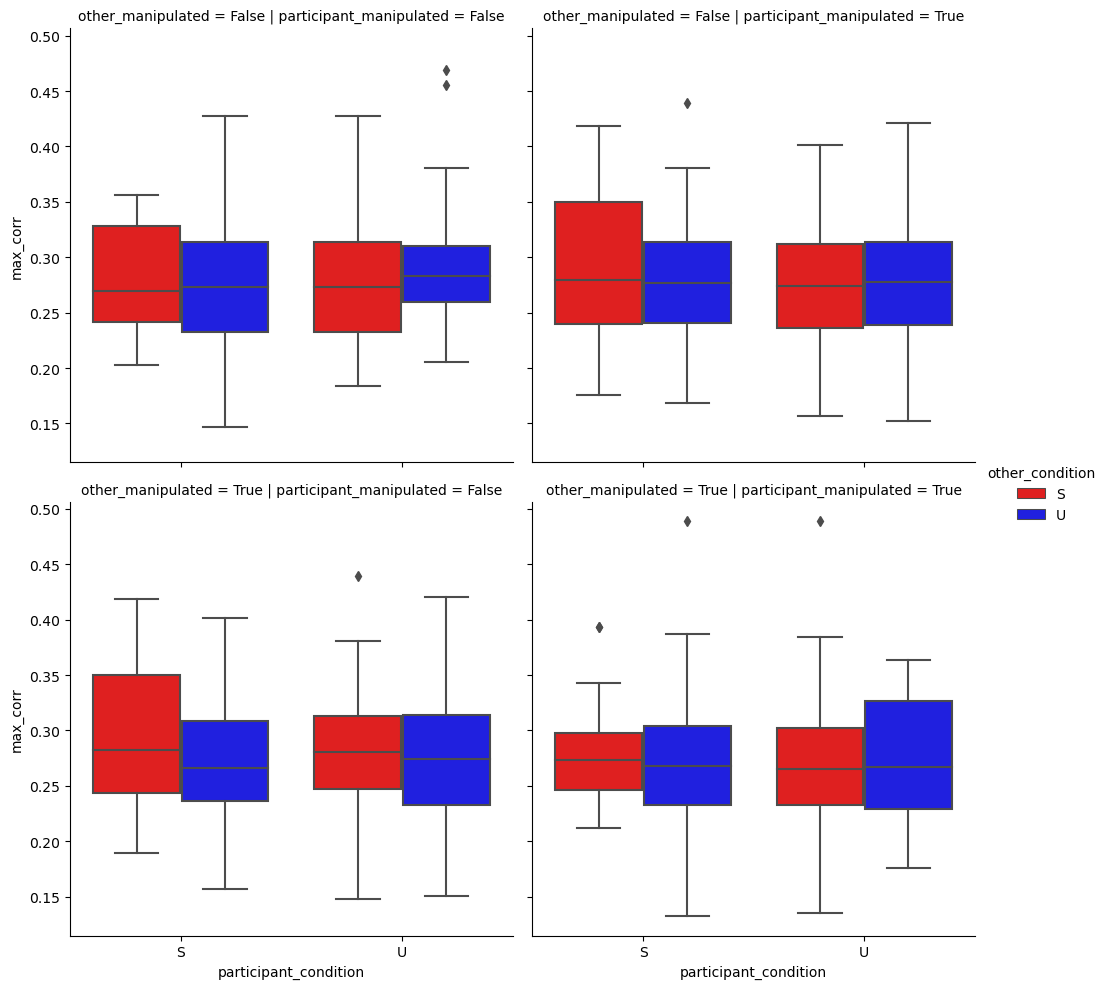

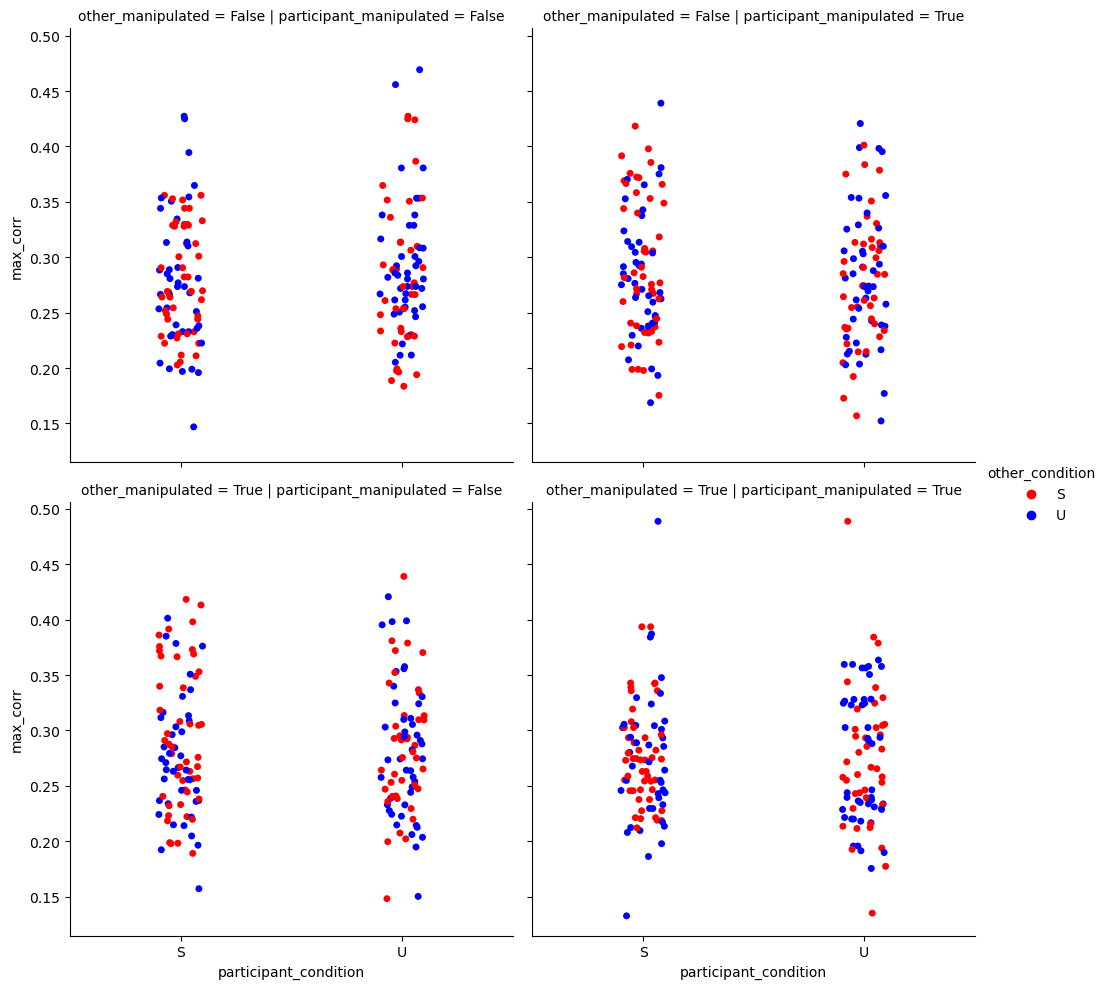

In [124]:
df_analysis = mi_df.groupby(["sid", "dyad", "user_id", "other_id", "participant_condition", "other_condition", "participant_manipulated", "other_manipulated", "real_dyad"]).mean().reset_index()
df_analysis = df_analysis.loc[df_analysis["real_dyad"] == True]

sns.catplot(x="participant_condition"
            , hue="other_condition"
            , col="participant_manipulated"
            , row="other_manipulated"
            , y="max_corr"
            , data=df_analysis
            , palette=sns.color_palette(['red', 'blue'])
            , order=["S", "U"]
            , kind="point"
            , capsize=0.15
            , hue_order=["S", "U"]
            )

sns.catplot(x="participant_condition"
            , hue="other_condition"
            , y="max_corr"
            , data=df_analysis
            , col="participant_manipulated"
            , row="other_manipulated"
            , kind="box"
            , palette=sns.color_palette(['red', 'blue'])
            , order=["S", "U"]
            , hue_order=["S", "U"]
            
            )
sns.catplot(x="participant_condition"
            , hue="other_condition"
            , col="participant_manipulated"
            , row="other_manipulated"
            , y="max_corr"
            , data=df_analysis
            , palette=sns.color_palette(['red', 'blue'])
            , order=["S", "U"]
            , hue_order=["S", "U"]
            )

/var/folders/g5/mqbcmmn575z0s3c021r942c80000gp/T/ipykernel_65750/1666671016.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_analysis = mi_df.groupby(["sid", "dyad", "user_id", "other_id", "participant_condition", "other_condition", "participant_manipulated", "other_manipulated", "surrogate"]).mean().reset_index()


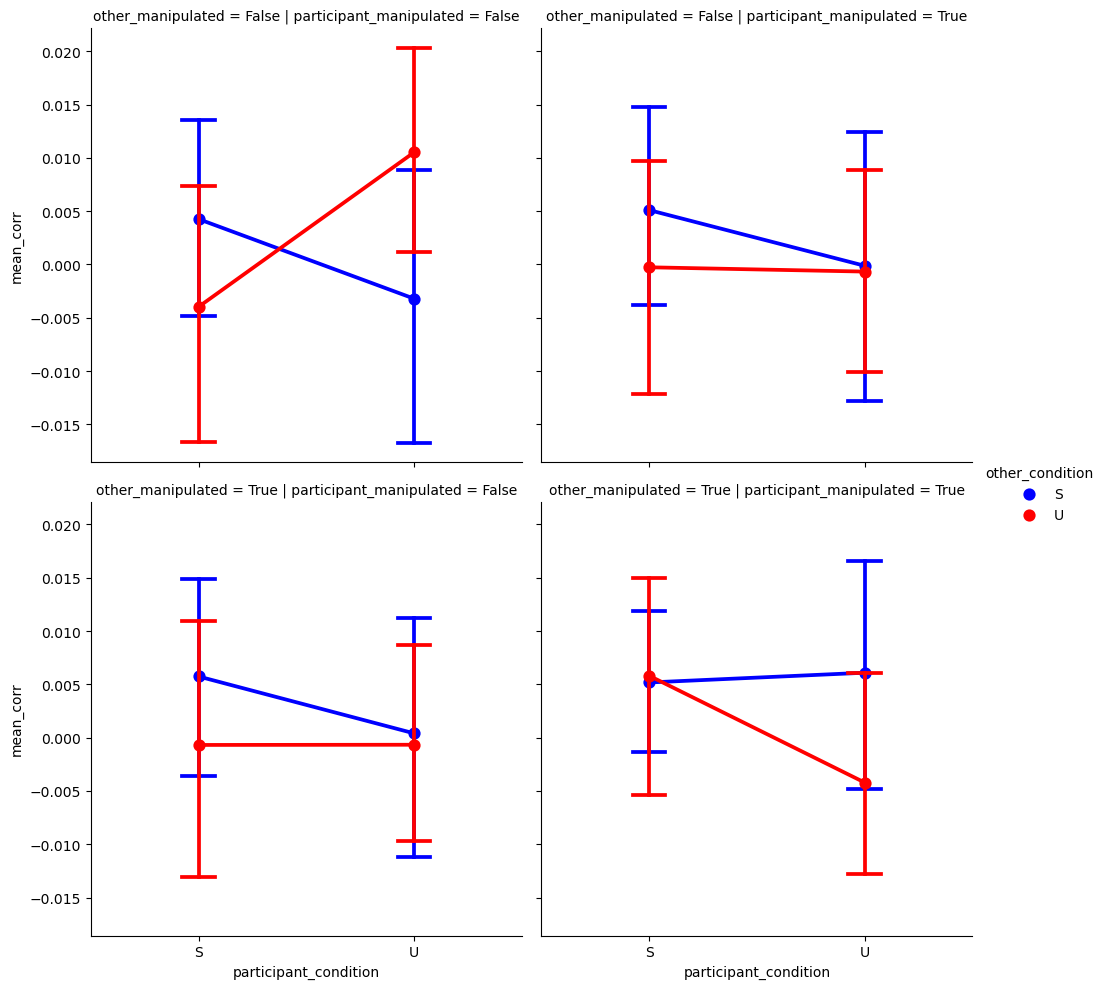

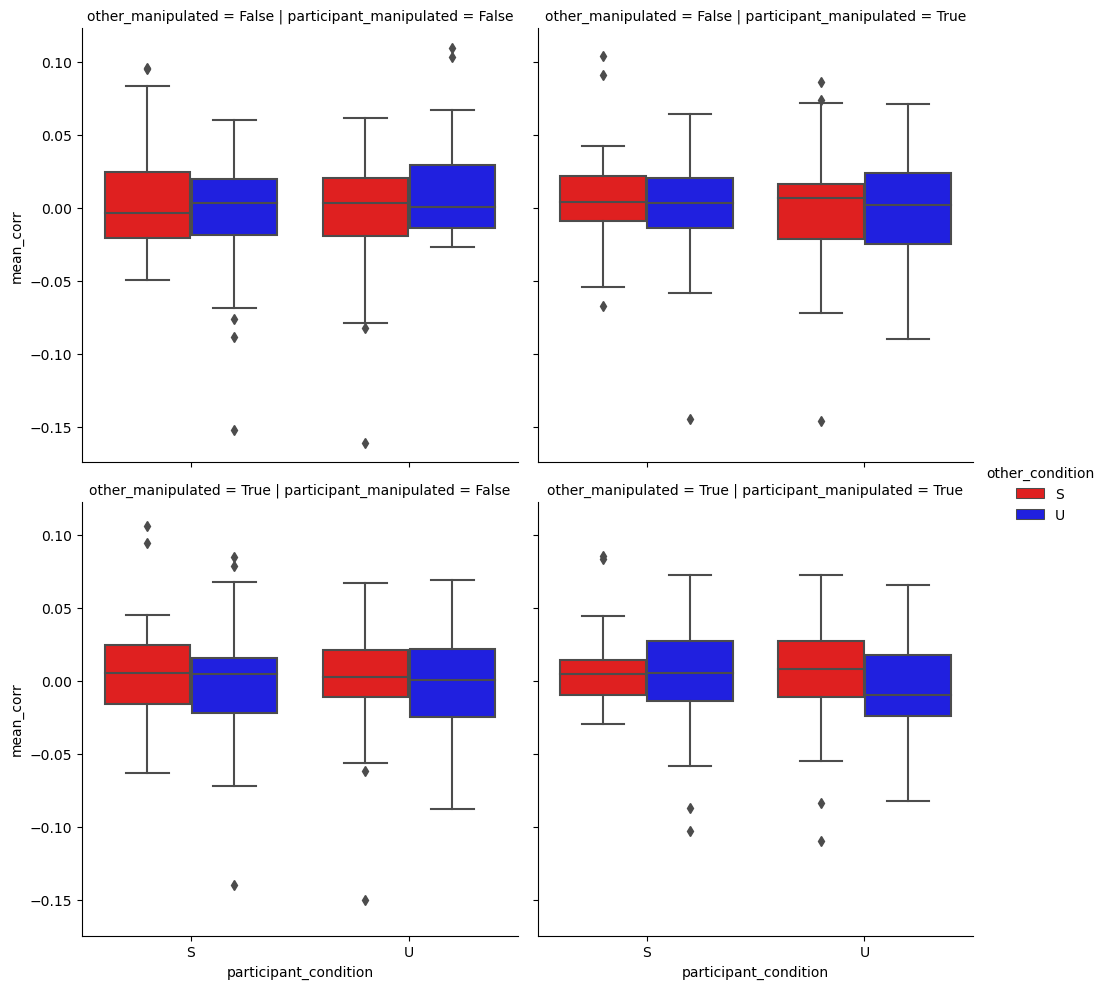

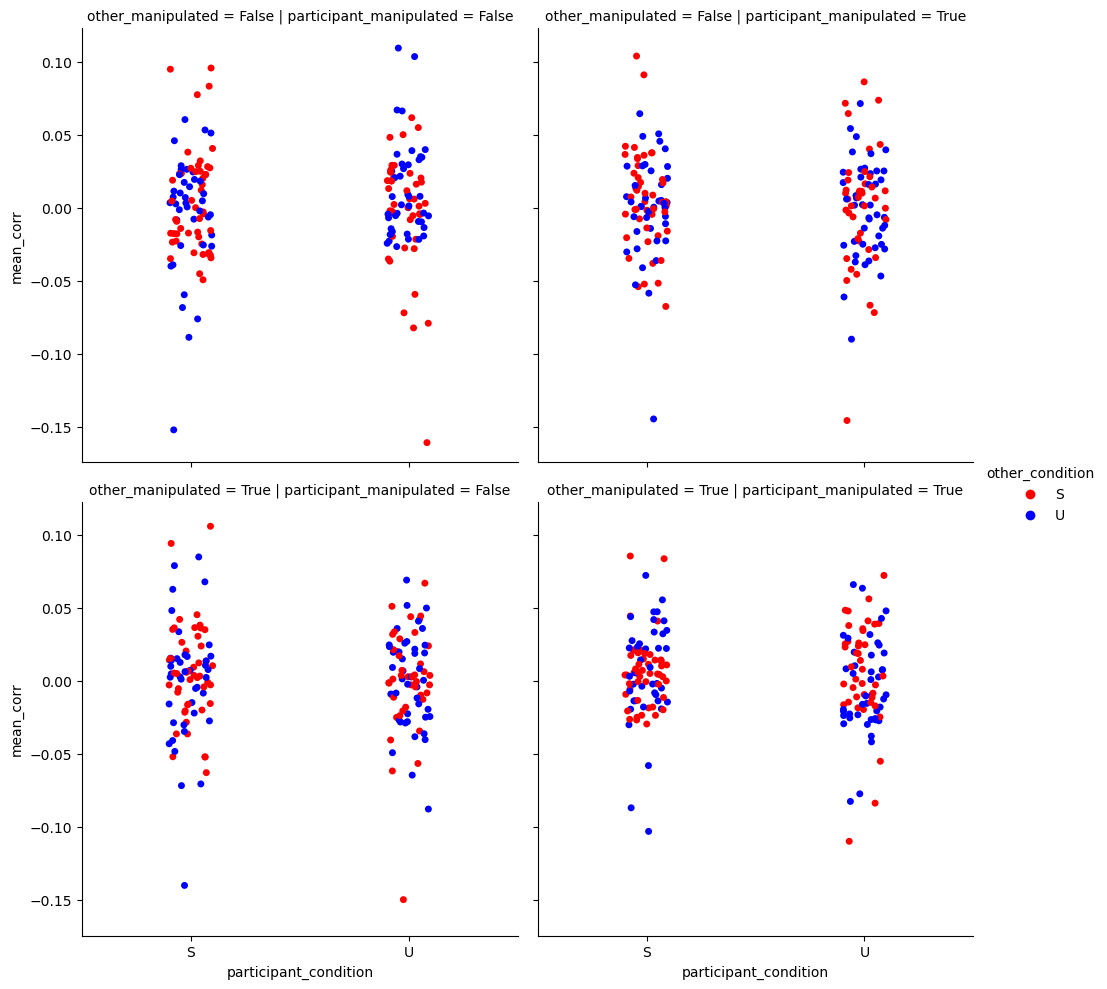

In [125]:
df_analysis = mi_df.groupby(["sid", "dyad", "user_id", "other_id", "participant_condition", "other_condition", "participant_manipulated", "other_manipulated", "real_dyad"]).mean().reset_index()
df_analysis = df_analysis.loc[df_analysis["real_dyad"] == False]

sns.catplot(x="participant_condition"
            , hue="other_condition"
            , col="participant_manipulated"
            , row="other_manipulated"
            , y="mean_corr"
            , data=df_analysis
            , palette=sns.color_palette(['blue', 'red'])
            , order=["S", "U"]
            , hue_order=["S", "U"]
            , kind="point"
            , capsize=0.15
            )

sns.catplot(x="participant_condition"
            , hue="other_condition"
            , y="mean_corr"
            , data=df_analysis
            , col="participant_manipulated"
            , row="other_manipulated"
            , kind="box"
            , palette=sns.color_palette(['red', 'blue'])
            , order=["S", "U"]
            , hue_order=["S", "U"]
            
            )
sns.catplot(x="participant_condition"
            , hue="other_condition"
            , col="participant_manipulated"
            , row="other_manipulated"
            , y="mean_corr"
            , data=df_analysis
            , palette=sns.color_palette(['red', 'blue'])
            , order=["S", "U"]
            , hue_order=["S", "U"]
            )

/mnt/data/project0028/conda/envs/stim39/lib/python3.9/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  func(*plot_args, **plot_kwargs)


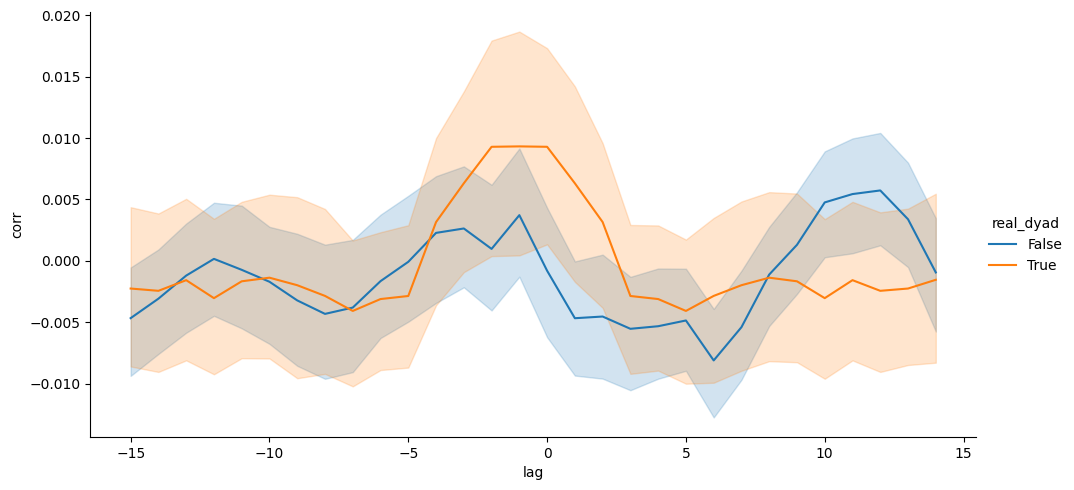

In [130]:
df_lags["u_cond"] = df_lags["participant_condition"] + df_lags["other_condition"]
df_lags["u_dyad"] = df_lags["sid"] + df_lags["dyad"]

df_analysis = df_lags

df_analysis = df_analysis.groupby(["lag", "u_dyad", "participant_condition", "other_condition", "u_cond", "real_dyad"]).mean(numeric_only=True).reset_index()

sns.relplot(x="lag", y="corr", hue="real_dyad", aspect=2, data= df_analysis, kind="line", ci=68)

/mnt/data/project0028/conda/envs/stim39/lib/python3.9/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  func(*plot_args, **plot_kwargs)


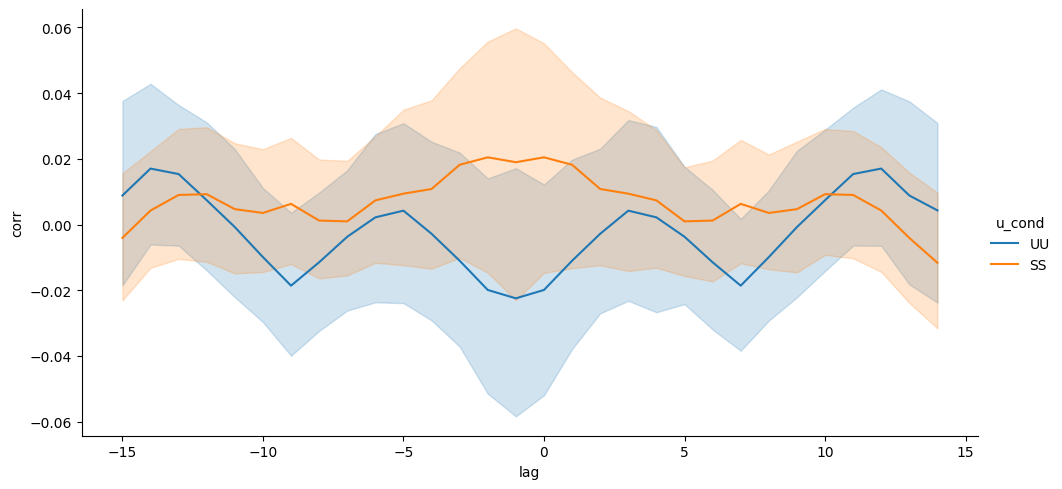

In [127]:
df_lags["u_cond"] = df_lags["participant_condition"] + df_lags["other_condition"]
df_lags["u_dyad"] = df_lags["sid"] + df_lags["dyad"]

df_analysis = df_lags

df_analysis = df_analysis.loc[df_analysis["u_cond"] != "US"]
df_analysis = df_analysis.loc[df_analysis["u_cond"] != "SU"]

df_analysis = df_analysis.loc[df_analysis["real_dyad"] == True]

#df_analysis = df_analysis.loc[df_analysis["other_manipulated"] == False]

#df_analysis = df_analysis.groupby(["lag", "user_id", "participant_condition", "other_condition", "u_cond"]).mean(numeric_only=True).reset_index()

df_analysis = df_analysis.groupby(["lag", "u_dyad", "participant_condition", "other_condition", "u_cond"]).mean(numeric_only=True).reset_index()


sns.relplot(x="lag", y="corr", aspect=2, hue="u_cond", data= df_analysis, kind="line", ci=95)

## Correlations

In [124]:
#import data
#mi_df = pd.read_csv("data/hr_computed/mi2_df.csv")
mi_df["u_cond"] = mi_df["participant_condition"] + mi_df["other_condition"]
mi_df["u_dyad"] = mi_df["sid"] + mi_df["dyad"]

In [125]:
df_analysis = mi_df.groupby(['user_id', "other_id", "participant_condition", "other_condition", "question_content"]).mean().reset_index()

sns.lmplot(y= "mi", x="measure", col="question_content", data=df_analysis)

TypeError: agg function failed [how->mean,dtype->object]

In [20]:
from scipy import stats


for ind, df in df_analysis.groupby("question_content"):
    x = df["mi"].values
    y = df["measure"].values

    r, p = stats.pearsonr(x, y)
    
    print(ind)
    print( " R : "+ str(r), "p= " + str(p))
    print()
    

conversation_quality
 R : 0.046998767528390044 p= 0.5356471770722357

liked
 R : 0.09054776246288994 p= 0.23202884068263774

other_liked
 R : 0.15896561547656876 p= 0.03509082603942975

video_conf_quality
 R : -0.060584766880345746 p= 0.42443268430684106



In [22]:
from scipy import stats


for ind, df in df_analysis.groupby("question_content"):
    x = df["mean_corr"].values
    y = df["measure"].values

    r, p = stats.pearsonr(x, y)
    
    print(ind)
    print( " R : "+ str(r), "p= " + str(p))
    print()
    

conversation_quality
 R : 0.025230461973341518 p= 0.7395964866993116

liked
 R : 0.04384217651080561 p= 0.5634223579576146

other_liked
 R : 0.04351863169371445 p= 0.5663076858891718

video_conf_quality
 R : 0.05666743206992027 p= 0.45505021015264896



# Synchrony analysis for each analysis type

In [2]:
# Initialize the dataframes with the correct schema if they are not initialized
df_lags_schema = {
    "lag": pl.Int64,
    "corr": pl.Float64,
    "dyad": pl.Utf8,
    "source_feature": pl.Utf8,
    "target_feature": pl.Utf8,
    "participant_manipulated": pl.Boolean,
    "other_manipulated": pl.Boolean,
    "other_id": pl.Utf8,
    "sid": pl.Utf8,
    "user_id": pl.Utf8,
    "window": pl.Int64,
    "start": pl.Int64,
    "start_time": pl.Int64,
    "real_dyad": pl.Boolean,
    "repetition_nb": pl.Int64,
    "analysis" : pl.Utf8
}

mi_df_schema = {
    "source_feature": pl.Utf8,
    "target_feature": pl.Utf8,
    "other_id": pl.Utf8,
    "user_id": pl.Utf8,
    "participant_manipulated": pl.Boolean,
    "other_manipulated": pl.Boolean,
    "dyad": pl.Utf8,
    "sid": pl.Utf8,
    "mi": pl.Float64,
    "max_corr": pl.Float64,
    "mean_corr": pl.Float64,
    "window": pl.Int64,
    "start": pl.Int64,
    "start_time": pl.Int64,
    "real_dyad": pl.Boolean,
    "repetition_nb": pl.Int64,
    "analysis" : pl.Utf8
}

## MI

In [49]:
#Read csvs in parallel processes
def process_file(file):
    df = pl.read_csv(file, schema_overrides=schema)
    df = df.with_columns([pl.col(column).cast(dtype) for column, dtype in schema.items()])
    #df = df.filter(pl.col("repetition_nb") == 0) #for efficiency and memory handling

    return df

# Read and process CSV files in parallel
schema = mi_df_schema
csv_files = glob.glob("data/synchrony_for_each_ppg_method_repetition_1_lag_30_overlap_5/*mi_df.csv")
dfs = Parallel(n_jobs=-1)(delayed(process_file)(file) for file in csv_files)

# Concatenate all dataframes
all_data_df = pl.concat(dfs, how="vertical")

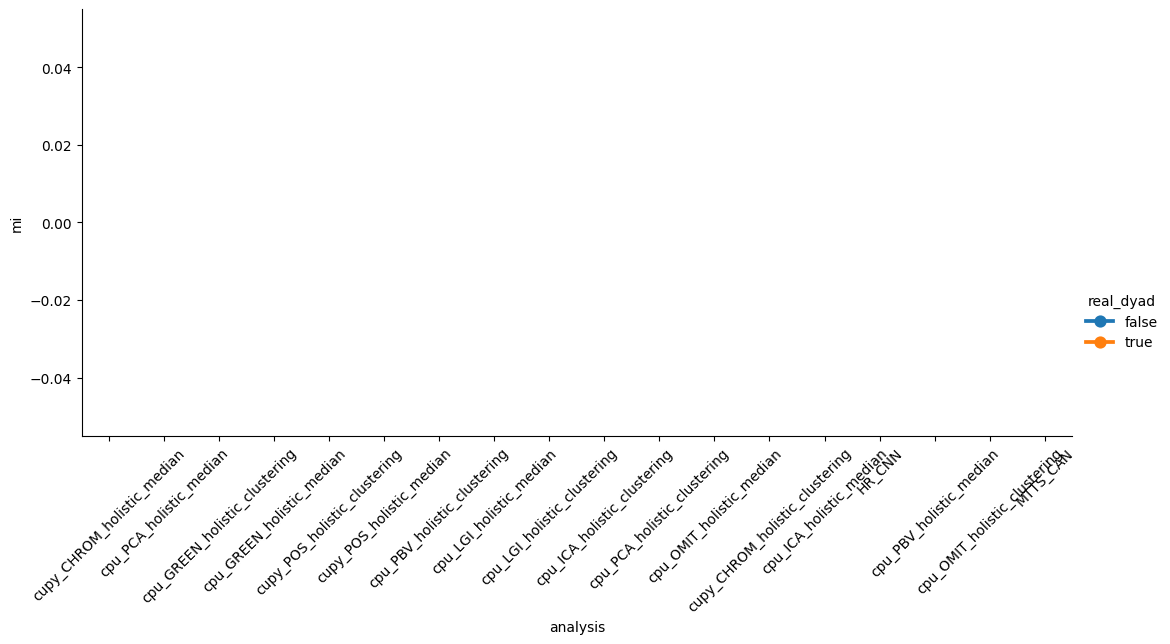

In [73]:
df_analysis = all_data_df.group_by(["sid", "dyad", "user_id", "other_id", "real_dyad", "repetition_nb", "analysis"]).mean().to_pandas(
)
#df_analysis = df_analysis.loc[df_analysis["mi"]<0.2]

sns.catplot(x="analysis", y="mi", hue="real_dyad"
                  , data=df_analysis
                  , aspect=2.2
                  , height=5
                  , kind="point"
                  , capsize=0.15
                  , hue_order=[False, True]
           )

x = plt.xticks(rotation=45);  # Rotate x-axis labels by 45 degrees

In [ ]:
df_analysis = all_data_df.group_by(["sid", "dyad", "user_id", "other_id", "real_dyad", "repetition_nb", "analysis"]).mean().to_pandas(
)
#df_analysis = df_analysis.loc[df_analysis["mi"]<0.2]

sns.catplot(x="analysis", y="mean_corr", hue="real_dyad"
                  , data=df_analysis
                  , aspect=2.2
                  , height=5
                  , kind="point"
                  , capsize=0.15
                  , hue_order=[False, True]
           )

x = plt.xticks(rotation=45);  # Rotate x-axis labels by 45 degrees


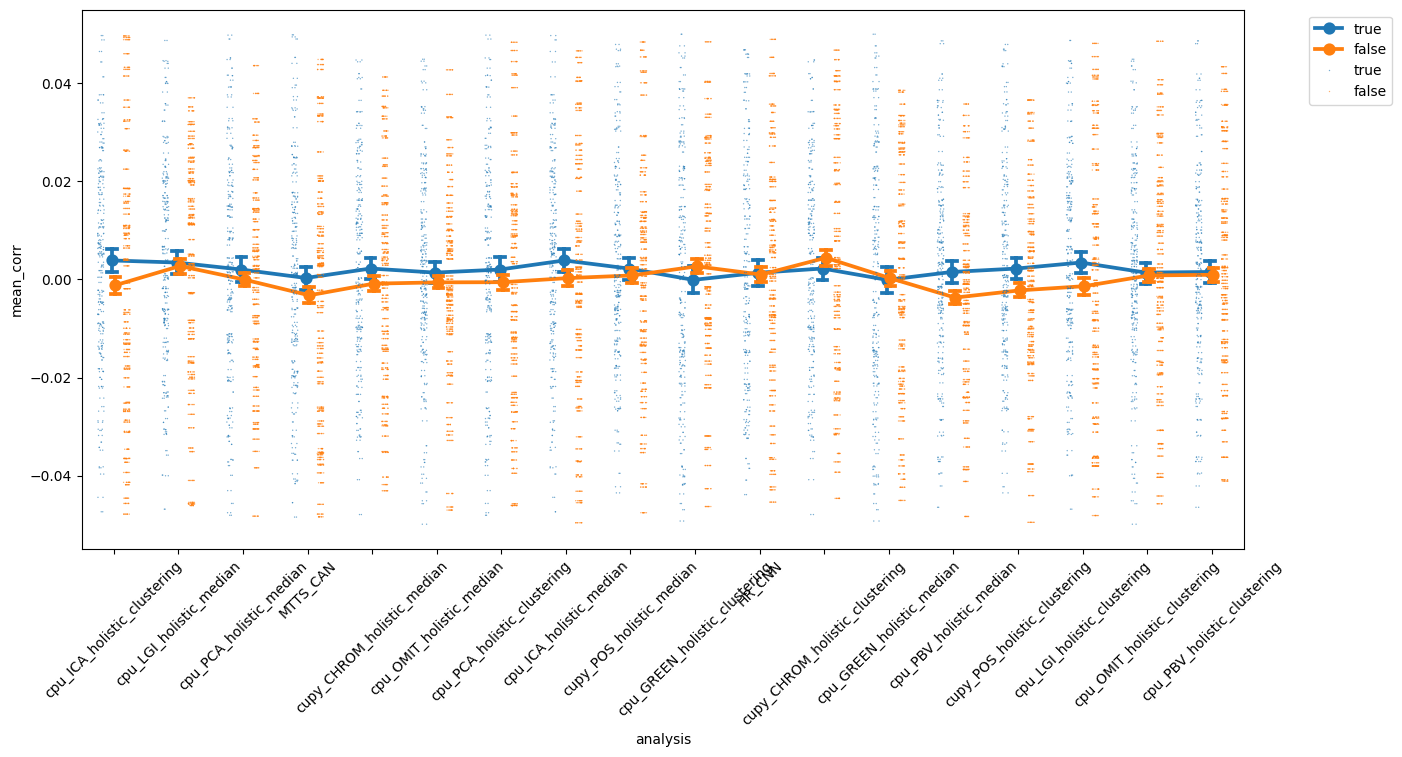

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df_analysis is already defined
df_analysis = all_data_df.group_by(["sid", "dyad", "user_id", "other_id", "real_dyad", "repetition_nb", "analysis"]).mean().to_pandas()

df_analysis = df_analysis.loc[df_analysis["mean_corr"] < 0.05]
df_analysis = df_analysis.loc[df_analysis["mean_corr"] > -0.05]

# Create a figure and a single axis
plt.figure(figsize=(15, 7))

# Plot the point plot with error bars
sns.pointplot(
    x="analysis", 
    y="mean_corr", 
    hue="real_dyad", 
    data=df_analysis, 
    capsize=0.15, 
    dodge=True, 
    markers='o', 
    linestyles='-', 
)

# Plot the strip plot with transparency
sns.stripplot(
    x="analysis", 
    y="mean_corr", 
    hue="real_dyad", 
    data=df_analysis, 
    dodge=True, 
    alpha=0.6, 
    jitter=True,
    size=1,
    legend=False
)

# Rotate x-axis labels by 45 degrees for better readability
plt.xticks(rotation=45)

# Adjust legend to prevent overlap
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()


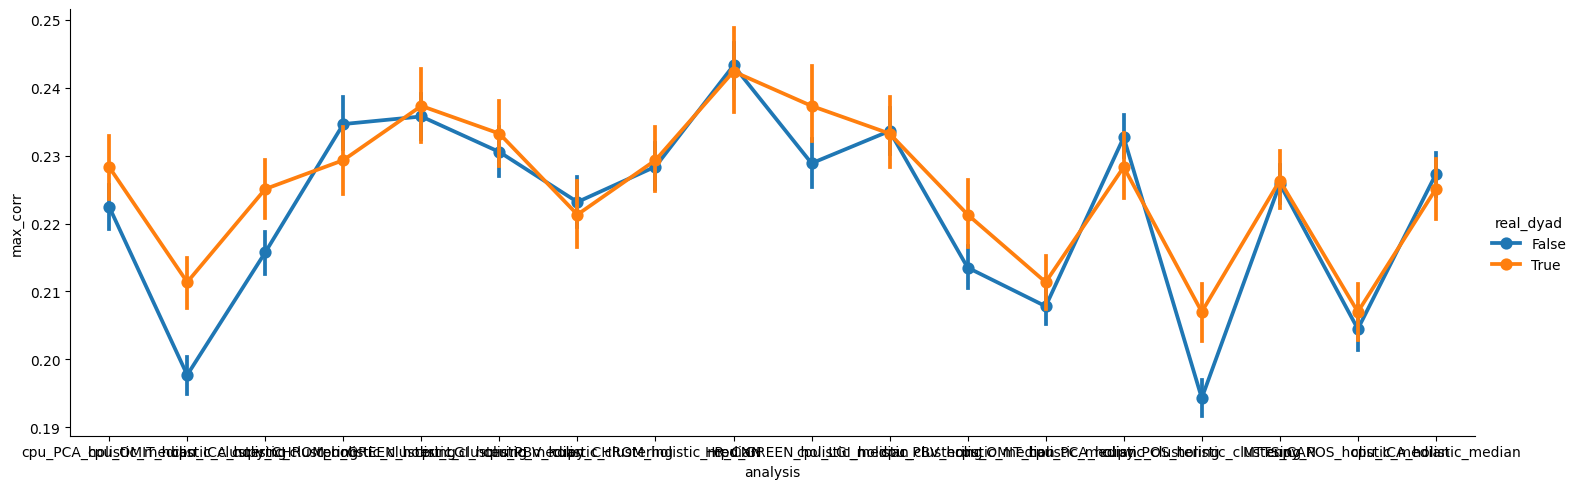

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df_analysis is already defined
df_analysis = all_data_df.group_by(["sid", "dyad", "user_id", "other_id", "real_dyad", "repetition_nb"]).mean().to_pandas()

df_analysis = df_analysis.loc[df_analysis["mean_corr"] < 0.05]
df_analysis = df_analysis.loc[df_analysis["mean_corr"] > -0.05]

# Create a figure and a single axis
plt.figure(figsize=(15, 7))

# Plot the point plot with error bars
sns.pointplot(
    x="analysis", 
    y="max_corr", 
    hue="real_dyad", 
    data=df_analysis, 
    capsize=0.15, 
    dodge=True, 
    markers='o', 
    linestyles='-', 
)

# Plot the strip plot with transparency
sns.stripplot(
    x="analysis", 
    y="max_corr", 
    hue="real_dyad", 
    data=df_analysis, 
    dodge=True, 
    alpha=0.6, 
    jitter=True,
    size=1,
    legend=False
)

# Rotate x-axis labels by 45 degrees for better readability
plt.xticks(rotation=45)

# Adjust legend to prevent overlap
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df_analysis is already defined
df_analysis = all_data_df.group_by(["sid", "dyad", "user_id", "other_id", "real_dyad", "repetition_nb"]).mean().to_pandas()

df_analysis = df_analysis.loc[df_analysis["mean_corr"] < 0.05]
df_analysis = df_analysis.loc[df_analysis["mean_corr"] > -0.05]

# Create a figure and a single axis
plt.figure(figsize=(15, 7))

# Plot the point plot with error bars
sns.pointplot(
    x="analysis", 
    y="max_corr", 
    hue="real_dyad", 
    data=df_analysis, 
    capsize=0.15, 
    dodge=True, 
    markers='o', 
    linestyles='-', 
)

# Plot the strip plot with transparency
sns.stripplot(
    x="analysis", 
    y="max_corr", 
    hue="real_dyad", 
    data=df_analysis, 
    dodge=True, 
    alpha=0.6, 
    jitter=True,
    size=1,
    legend=False
)

# Rotate x-axis labels by 45 degrees for better readability
plt.xticks(rotation=45)

# Adjust legend to prevent overlap
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()


In [ ]:
behavior_df = pl.read_csv("data/behavior/all_data_df.csv")
behavior_df = behavior_df.with_columns(
    pl.col("sid").str.replace_all(":", "").alias("sid"),
    pl.col("user_id").str.replace_all(":", "").alias("user_id"),
    pl.col("other_id").str.replace_all(":", "").alias("other_id")
)

## CORR

In [3]:
#Read csvs in parallel processes
def process_file(file):
    df = pl.read_csv(file, schema_overrides=schema)
    df = df.with_columns([pl.col(column).cast(dtype) for column, dtype in schema.items()])
    #df = df.filter(pl.col("repetition_nb") == 1) #for efficiency and memory handling
    return df

# Read and process CSV files in parallel
schema = df_lags_schema
#csv_files = glob.glob("data/synchrony_for_each_ppg_method_repetition_1_lag_30_overlap_5/*df_lags.csv")
csv_files = glob.glob("data/synchrony_for_each_ppg_method_repetition_2_lag_20_overlap_1_wl_100/*df_lags.csv")

# --> csv_files = glob.glob("synchrony_for_each_ppg_method_repetition_2_lag_15_overlap_1_wl_30)

dfs = Parallel(n_jobs=-1)(delayed(process_file)(file) for file in csv_files)

# Concatenate all dataframes
df_lags = pl.concat(dfs, how="vertical")
df_lags.head()

shape: (5, 16)
┌─────┬───────────┬──────┬──────────────┬───┬────────────┬───────────┬──────────────┬──────────────┐
│ lag ┆ corr      ┆ dyad ┆ source_featu ┆ … ┆ start_time ┆ real_dyad ┆ repetition_n ┆ analysis     │
│ --- ┆ ---       ┆ ---  ┆ re           ┆   ┆ ---        ┆ ---       ┆ b            ┆ ---          │
│ i64 ┆ f64       ┆ str  ┆ ---          ┆   ┆ i64        ┆ bool      ┆ ---          ┆ str          │
│     ┆           ┆      ┆ str          ┆   ┆            ┆           ┆ i64          ┆              │
╞═════╪═══════════╪══════╪══════════════╪═══╪════════════╪═══════════╪══════════════╪══════════════╡
│ -20 ┆ -0.112838 ┆ p3p7 ┆ bpmES        ┆ … ┆ 0          ┆ false     ┆ 0            ┆ cpu_OMIT_hol │
│     ┆           ┆      ┆              ┆   ┆            ┆           ┆              ┆ istic_median │
│ -19 ┆ -0.010476 ┆ p3p7 ┆ bpmES        ┆ … ┆ 0          ┆ false     ┆ 0            ┆ cpu_OMIT_hol │
│     ┆           ┆      ┆              ┆   ┆            ┆           ┆              ┆ istic_median │
│ -18 ┆ 0.032009  ┆ p3p7 ┆ bpmES        ┆ … ┆ 0          ┆ false     ┆ 0            ┆ cpu_OMIT_hol │
│     ┆           ┆      ┆              ┆   ┆            ┆           ┆              ┆ istic_median │
│ -17 ┆ 0.073119  ┆ p3p7 ┆ bpmES        ┆ … ┆ 0          ┆ false     ┆ 0            ┆ cpu_OMIT_hol │
│     ┆           ┆      ┆              ┆   ┆            ┆           ┆              ┆ istic_median │
│ -16 ┆ 0.03648   ┆ p3p7 ┆ bpmES        ┆ … ┆ 0          ┆ false     ┆ 0            ┆ cpu_OMIT_hol │
│     ┆           ┆      ┆              ┆   ┆            ┆           ┆              ┆ istic_median │
└─────┴───────────┴──────┴──────────────┴───┴────────────┴───────────┴──────────────┴──────────────┘

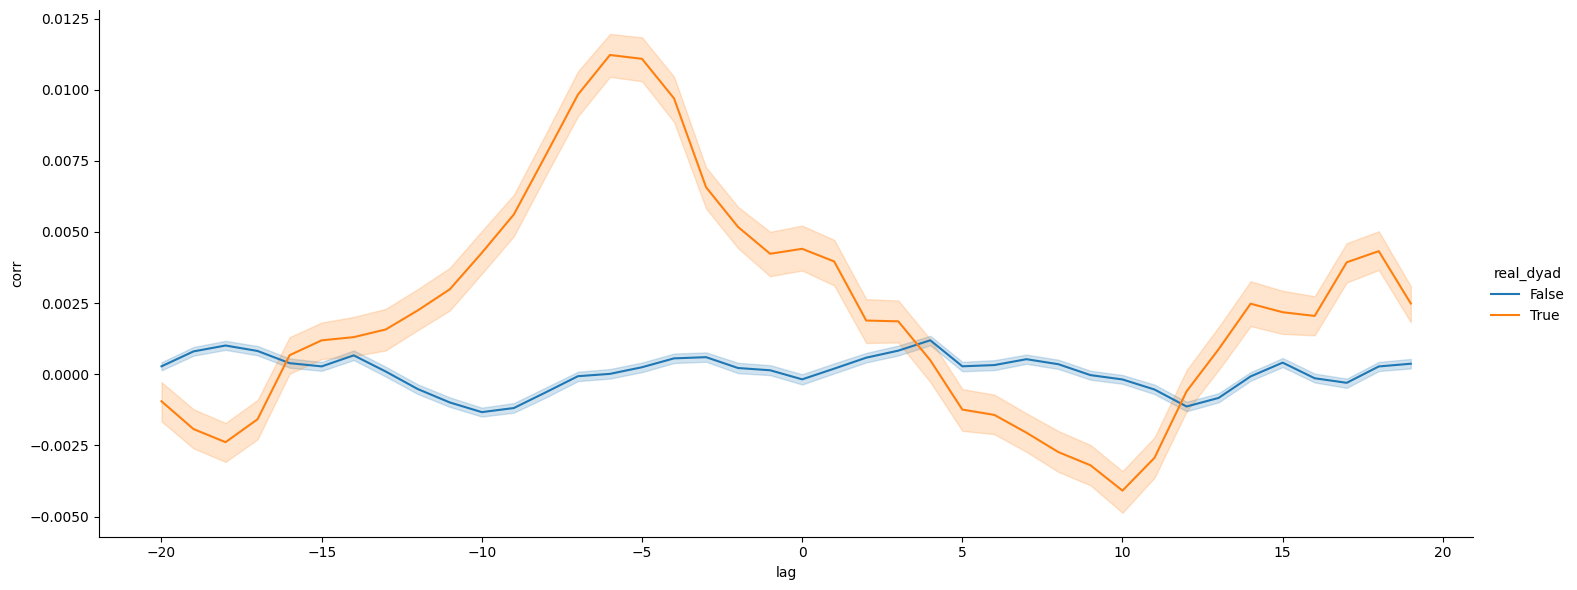

In [4]:
df_analysis = df_lags.group_by(["sid", "dyad", "user_id", "other_id", "real_dyad", "window", "lag"]).mean().to_pandas()

sns.relplot(x="lag", y="corr",hue="real_dyad", data=df_analysis, aspect=2.5, height=6, kind="line")

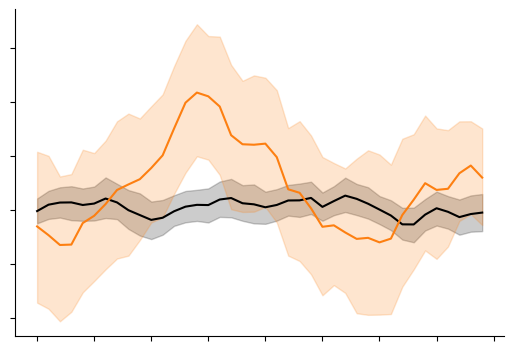

In [4]:
df_analysis = df_lags.group_by(["sid", "user_id", "real_dyad", "lag"]).mean().to_pandas()

g = sns.relplot(x="lag", y="corr", hue="real_dyad"
                , data=df_analysis, aspect=1.5, height=4, kind="line", errorbar=('ci', 95)
                , palette = ["#000000", "#FD7F11"]
                , legend=False
               )

plt.savefig("plots/hr_lags_legend.pdf", bbox_inches='tight')
g.set(xticklabels=[], yticklabels=[], title='',xlabel=None, ylabel=None)
plt.savefig("plots/hr_lags.pdf", bbox_inches='tight')


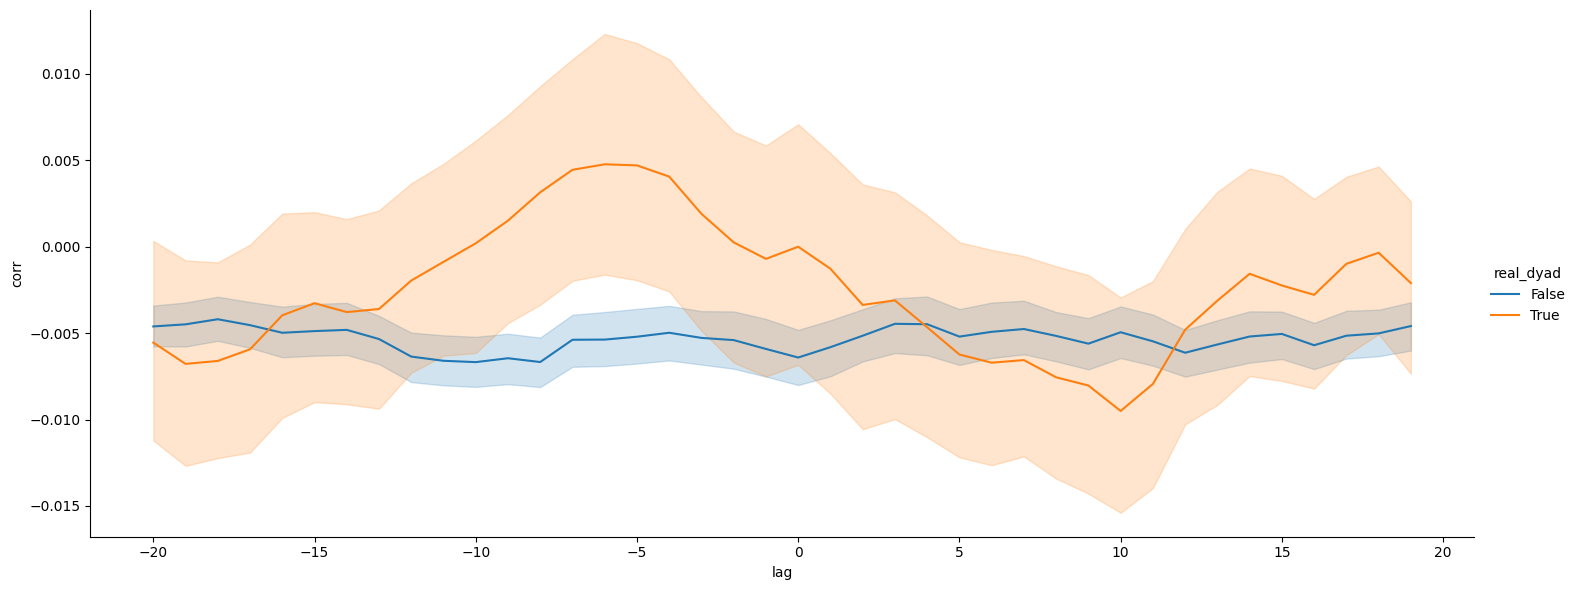

In [18]:
df_analysis = df_lags
df_analysis = df_analysis.group_by(["sid", "dyad", "user_id", "other_id", "real_dyad", "lag"]).median().to_pandas()

sns.relplot(x="lag", y="corr", hue="real_dyad", data=df_analysis, aspect=2.5, height=6, kind="line")

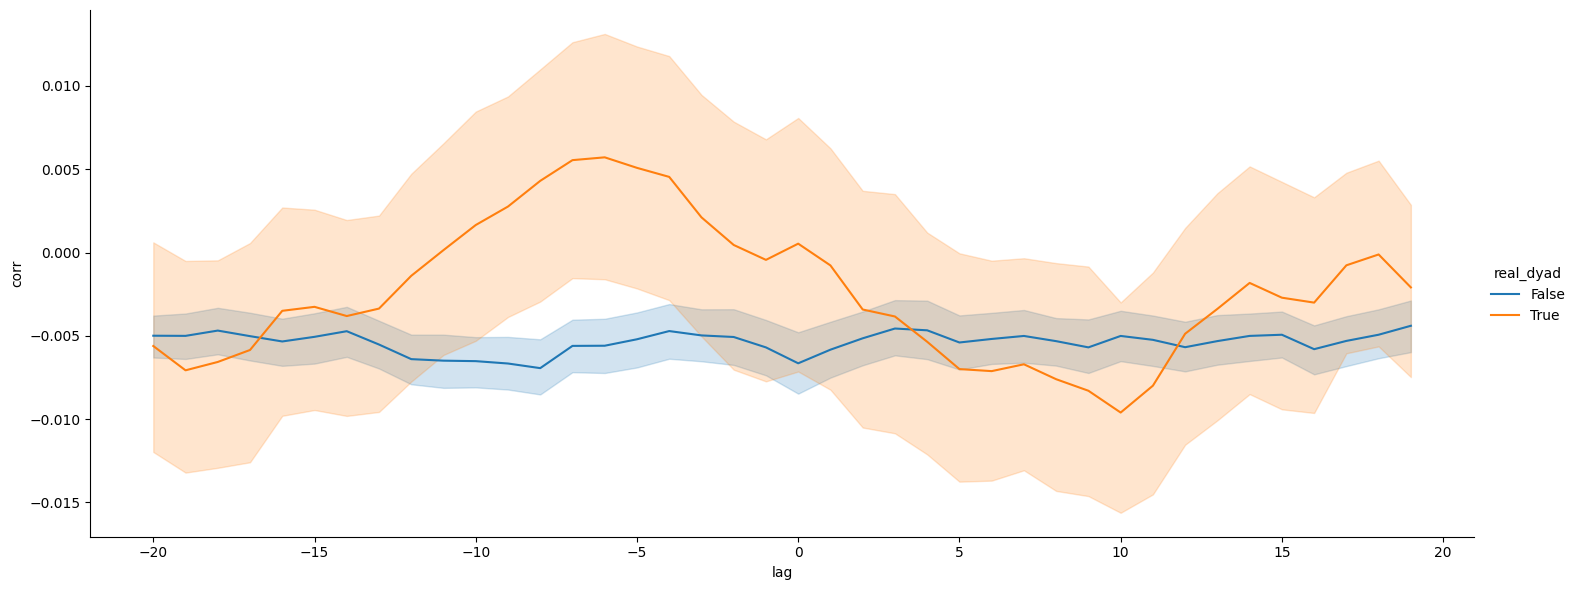

In [19]:
df_analysis = df_lags
df_analysis = df_analysis.filter(pl.col("analysis") != "MTTS_CAN")
df_analysis = df_analysis.filter(pl.col("analysis") != "HR_CNN")
df_analysis = df_analysis.group_by(["sid", "dyad", "user_id", "other_id", "real_dyad", "lag"]).median().to_pandas()

sns.relplot(x="lag", y="corr", hue="real_dyad"
            , data=df_analysis, aspect=2.5, height=6, kind="line"
            , hue_order = [False, True]
            , palette= sns.color_palette(["red", "blue"])
           
           )

In [6]:
# Group and aggregate the data
df_analysis = df_lags
df_analysis = df_analysis.filter(pl.col("repetition_nb")==0)
df_analysis = df_analysis.group_by(["sid", "dyad", "user_id", "other_id", "real_dyad", "lag"]).mean().to_pandas()

Shape of data_true: (58, 40)
Shape of data_false: (58, 40)
stat_fun(H1): min=0.001584855765904579 max=10.535736402362893
Running initial clustering …
Found 1 cluster


  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]

Raw clusters:
Cluster 1: (array([11, 12, 13, 14, 15, 16]),)
Significant clusters (p <= 0.05):
Cluster 1:
Indices: [11 12 13 14 15 16]
Lag range: -9 to -4
p-value: 0.016


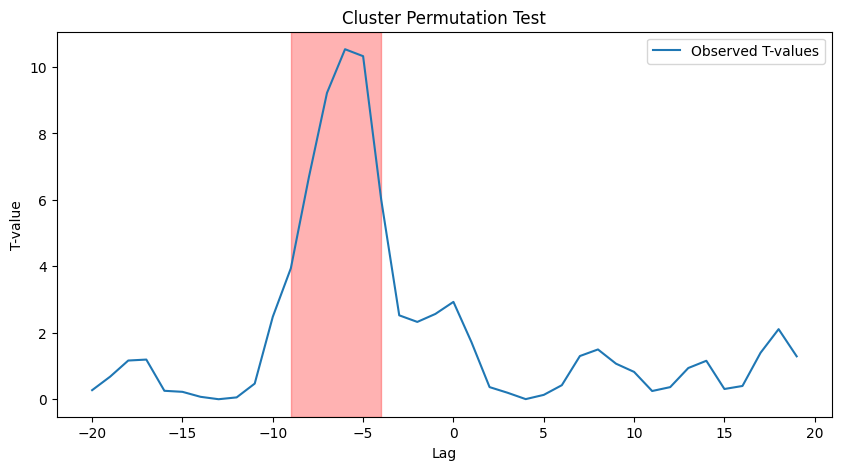

In [5]:
# Group and aggregate the data
df_analysis = df_lags
df_analysis = df_analysis.filter(pl.col("repetition_nb")==0)
df_analysis = df_analysis.group_by(["sid", "user_id", "real_dyad", "lag"]).mean().to_pandas()

# Pivot the data to have separate columns for True and False real_dyad
df_pivot = df_analysis.pivot_table(index=["sid", "user_id", "lag"], 
                                   columns="real_dyad", values="corr").reset_index()

# Rename the columns for clarity
df_pivot.columns = ['sid', 'user_id',  'lag', 'False', 'True']

# Prepare the data for mne
times = df_pivot['lag'].unique()

data_true = df_pivot[df_pivot['True'].notna()]['True'].values.reshape(-1, len(times))
data_false = df_pivot[df_pivot['False'].notna()]['False'].values.reshape(-1, len(times))

# Print shapes of the data arrays for debugging
print("Shape of data_true:", data_true.shape)
print("Shape of data_false:", data_false.shape)

# Print data samples for initial lags
#print("Data at initial lags for True condition:", data_true[:, 0])
#print("Data at initial lags for False condition:", data_false[:, 0])

# Ensure the data is correctly reshaped
assert data_true.shape[1] == len(times), "Reshaping error for True data"
assert data_false.shape[1] == len(times), "Reshaping error for False data"

# Combine the data for the test
data = [data_true, data_false]

# Perform the cluster permutation test
T_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
    data, n_permutations=1000, threshold=3.842517, tail=1, n_jobs=1)

# Print the raw clusters
print("Raw clusters:")
for i, cluster in enumerate(clusters):
    print(f"Cluster {i+1}: {cluster}")

# Print the significant clusters with indices
print("Significant clusters (p <= 0.05):")
for i_c, c in enumerate(clusters):
    if cluster_p_values[i_c] <= 0.05:
        c_indices = c[0]  # Extract indices of the cluster
        print(f"Cluster {i_c + 1}:")
        print(f"Indices: {c_indices}")
        print(f"Lag range: {times[c_indices[0]]} to {times[c_indices[-1]]}")
        print(f"p-value: {cluster_p_values[i_c]}")

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(times, T_obs, label='Observed T-values')
plt.xlabel('Lag')
plt.ylabel('T-value')
plt.title('Cluster Permutation Test')

# Highlight significant clusters
for i_c, c in enumerate(clusters):
    if cluster_p_values[i_c] <= 0.05:
        c_indices = c[0]  # Extract indices of the cluster
        plt.axvspan(times[c_indices[0]], times[c_indices[-1]], color='r', alpha=0.3)

plt.legend()
plt.show()


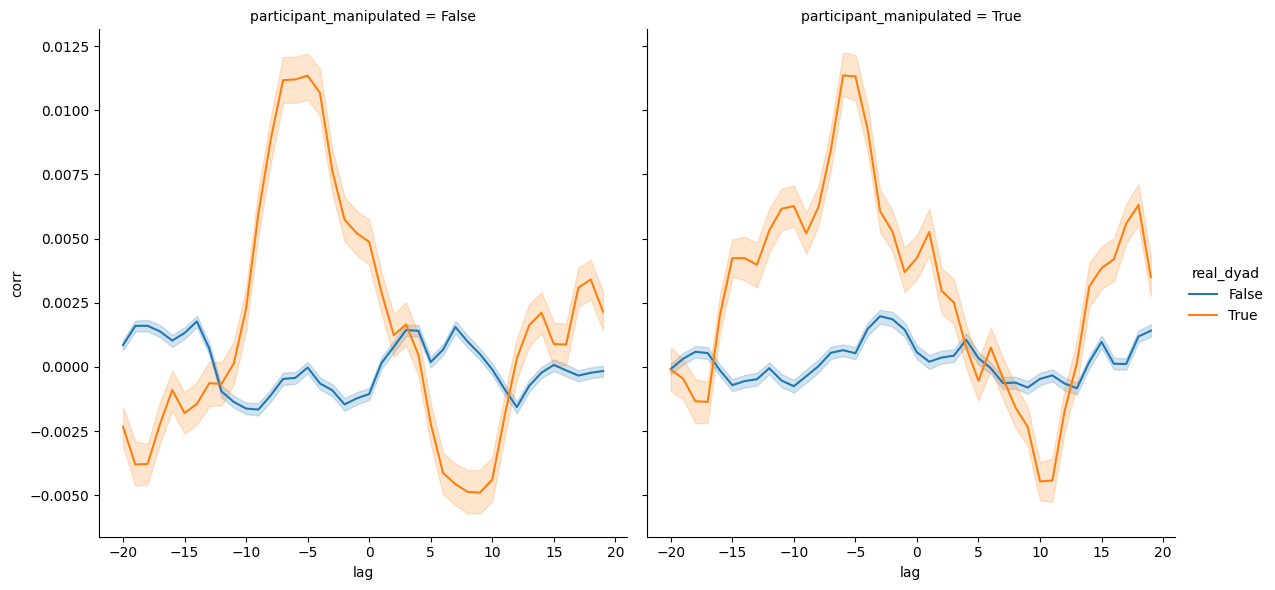

In [8]:
df_analysis = df_lags.group_by(["sid", "dyad", "user_id", "other_id", "real_dyad", "window", "lag", "participant_manipulated"]).mean().to_pandas()

#df_analysis = df_analysis.loc[df_analysis["mi"]<0.15]

sns.relplot(x="lag", y="corr",hue="real_dyad", col="participant_manipulated", data=df_analysis, aspect=1, height=6, kind="line")

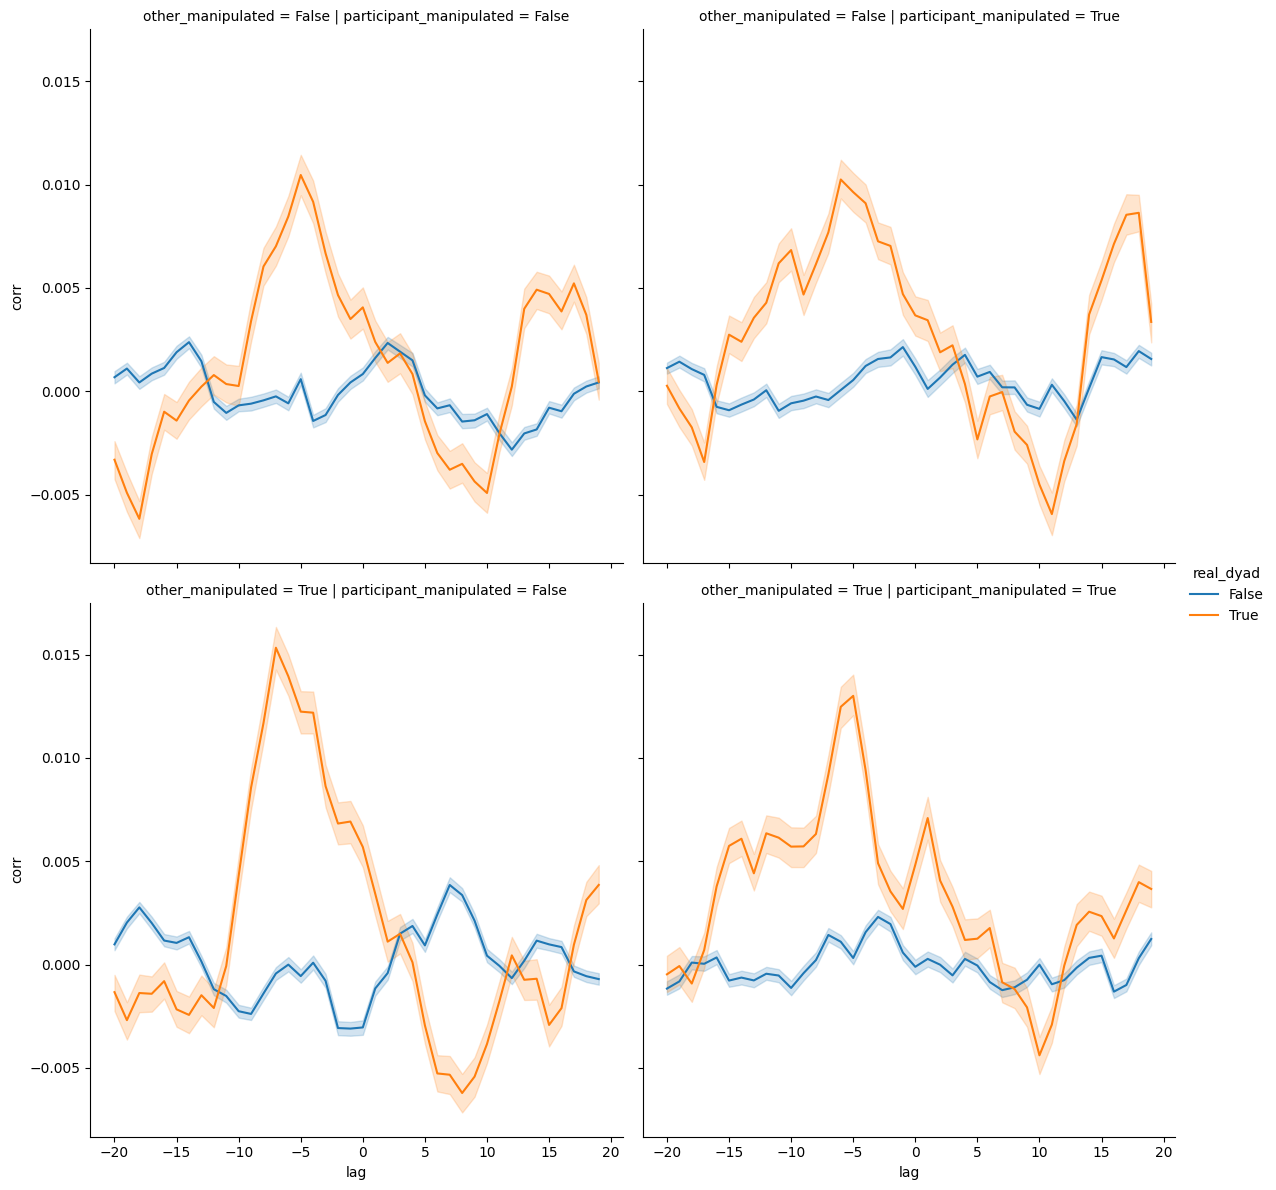

In [9]:
df_analysis = df_lags.group_by(["sid", "dyad", "user_id", "other_id", "real_dyad", "window", "lag", "participant_manipulated", "other_manipulated"]).mean().to_pandas()

#df_analysis = df_analysis.loc[df_analysis["mi"]<0.15]

sns.relplot(x="lag", y="corr",hue="real_dyad", col="participant_manipulated", row="other_manipulated",data=df_analysis, aspect=1, height=6, kind="line")

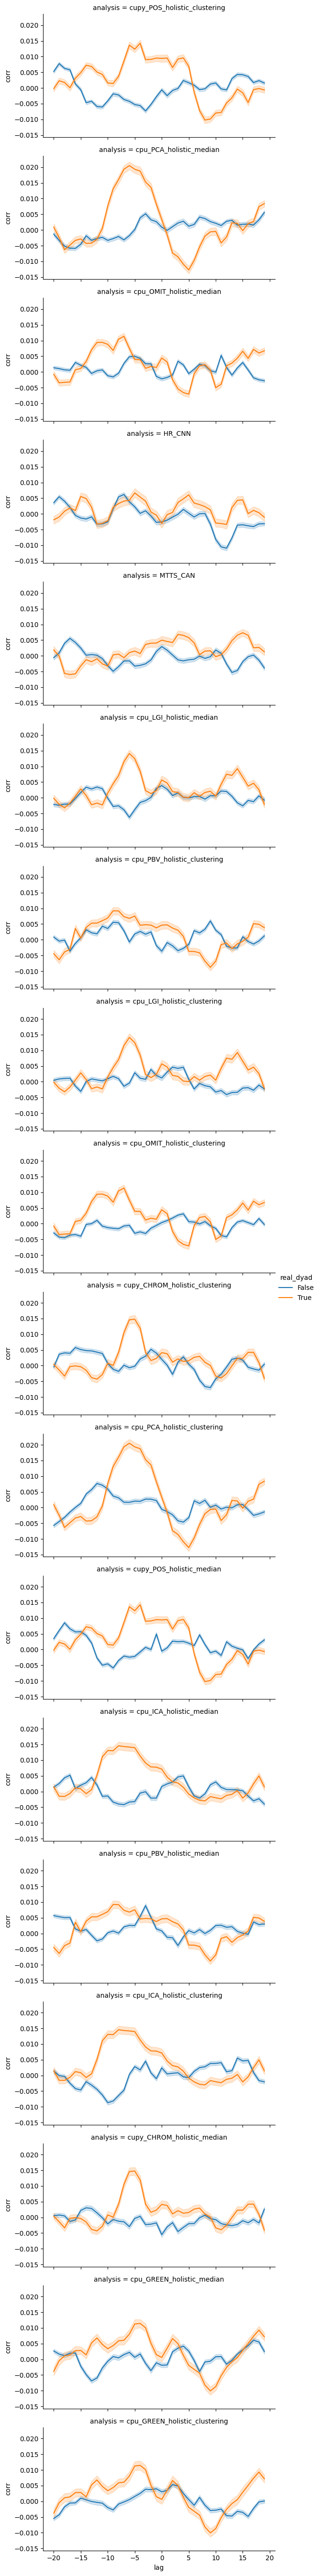

In [11]:
df_analysis = df_lags.group_by(["sid", "dyad", "user_id", "other_id", "real_dyad", "window", "analysis", "lag"]).mean().to_pandas()

#df_analysis = df_analysis.loc[df_analysis["mi"]<0.15]

sns.relplot( x="lag", y="corr",hue="real_dyad", row="analysis", data=df_analysis, aspect=2, height=3, kind="line" )

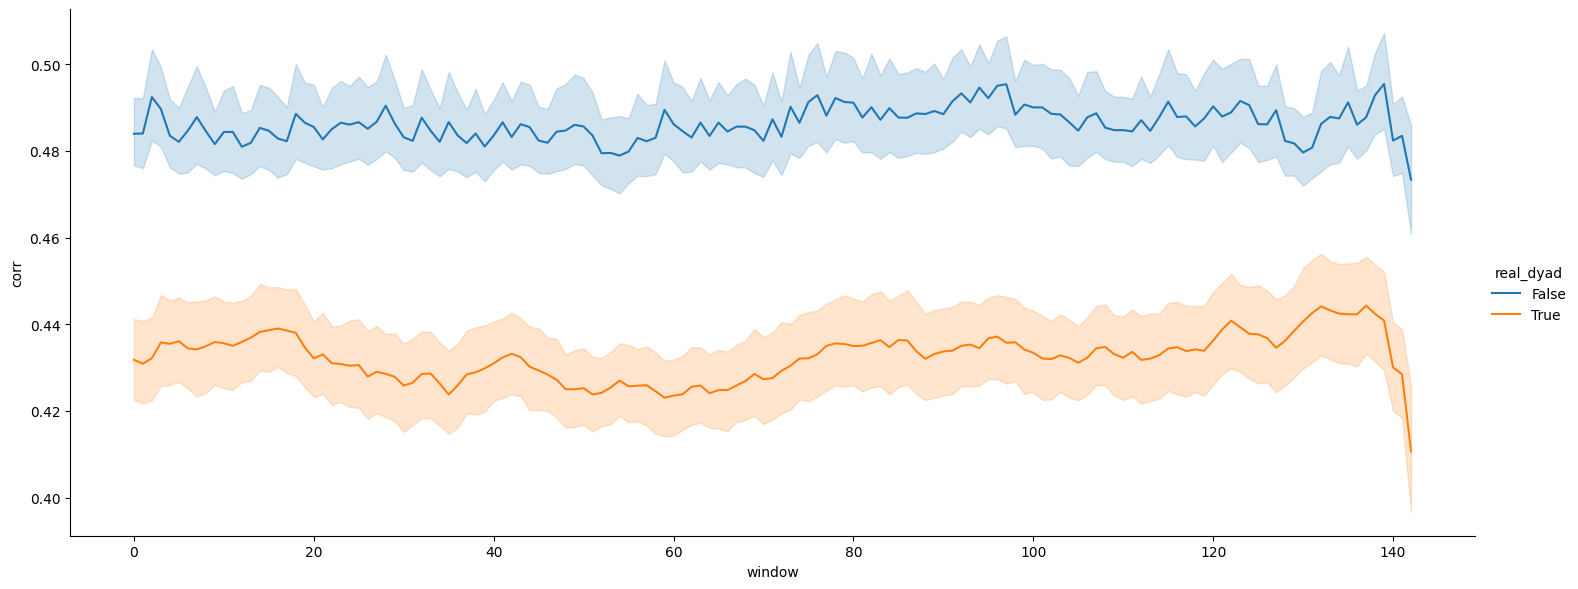

In [69]:
# Where in time is the effect?
df_analysis = df_lags
df_analysis = df_analysis.filter(pl.col(["lag"]) > -10)
df_analysis = df_analysis.filter(pl.col(["lag"]) < 10)

df_analysis = df_analysis.with_columns(pl.col("corr").abs().alias("corr"))

df_analysis = df_analysis.group_by(["sid", "dyad", "user_id", "other_id", "real_dyad", "window"]).max().to_pandas()

sns.relplot(x="window", y="corr",hue="real_dyad", data=df_analysis, aspect=2.5, height=6, kind="line")

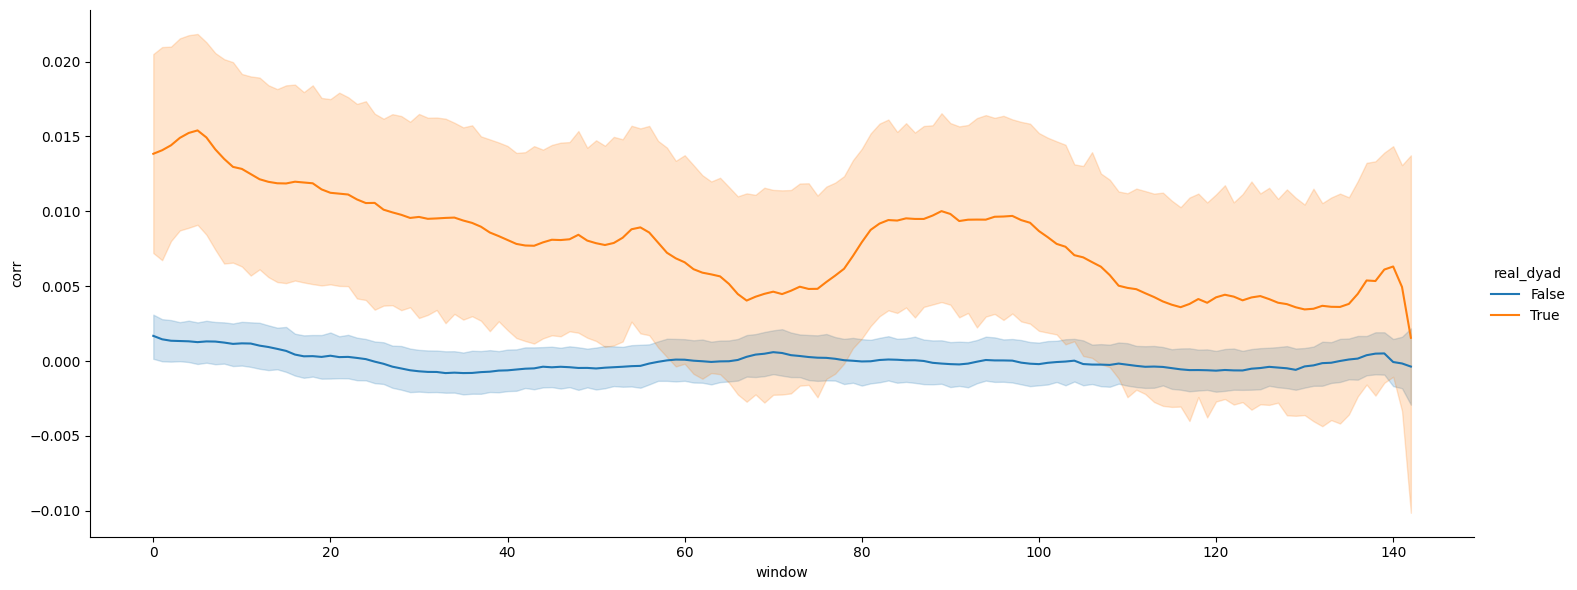

In [74]:
# Where in time is the effect?
df_analysis = df_lags
#df_analysis = df_analysis.with_columns(pl.col("corr").abs().alias("corr"))
df_analysis = df_analysis.filter(pl.col(["lag"]) > -10)
df_analysis = df_analysis.filter(pl.col(["lag"]) < 0)
df_analysis = df_analysis.group_by(["sid", "dyad", "user_id", "real_dyad", "window"]).mean().to_pandas()

sns.relplot(x="window", y="corr",hue="real_dyad", data=df_analysis, aspect=2.5, height=6, kind="line")

### Compare with conditions

#### Format data

In [6]:
behavior_df = pl.read_csv("data/behavior/all_data_df.csv")

behavior_df = behavior_df.with_columns(
    pl.col("sid").str.replace_all(":", "").alias("sid"),
    pl.col("user_id").str.replace_all(":", "").alias("user_id"),
    pl.col("other_id").str.replace_all(":", "").alias("other_id")
)

In [7]:
df_analysis = df_lags.group_by(["sid", "dyad", "user_id", "other_id", "real_dyad", "lag"]).mean()
merge_df = behavior_df.join(df_analysis, on=["user_id", "sid", "dyad", "other_id"])
merge_df = merge_df.with_columns(
    (pl.col("participant_condition") + pl.col("other_condition")).alias("u_cond")
)


In [8]:
merge_df = merge_df.write_csv("data/merge_df.csv")

#### Analysis

In [75]:
merge_df = pl.read_csv("data/merge_df.csv")

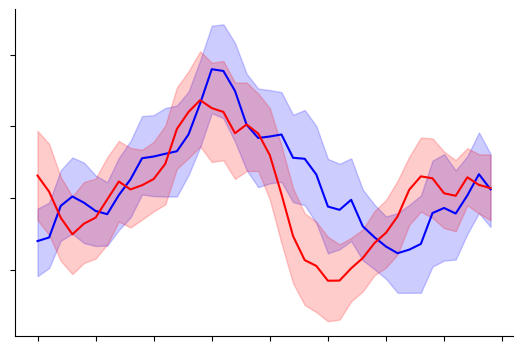

In [10]:
df_analysis = merge_df.filter(pl.col("u_cond") != "SU")
df_analysis = df_analysis.filter(pl.col("u_cond") != "US")
df_analysis = df_analysis.filter(pl.col("real_dyad") == True).to_pandas()

g = sns.relplot( x="lag",y="corr", hue="u_cond",kind="line", data=df_analysis
            , aspect=1.5, height=4, hue_order=["UU", "SS"], palette= sns.color_palette(["blue", "red"])
            , errorbar=('ci', 95)
            , legend = False
        
            )


plt.savefig("plots/hr_lags_condition_legend.pdf", bbox_inches='tight')
g.set(xticklabels=[], yticklabels=[], title='',xlabel=None, ylabel=None)
plt.savefig("plots/hr_lags_condition.pdf", bbox_inches='tight')



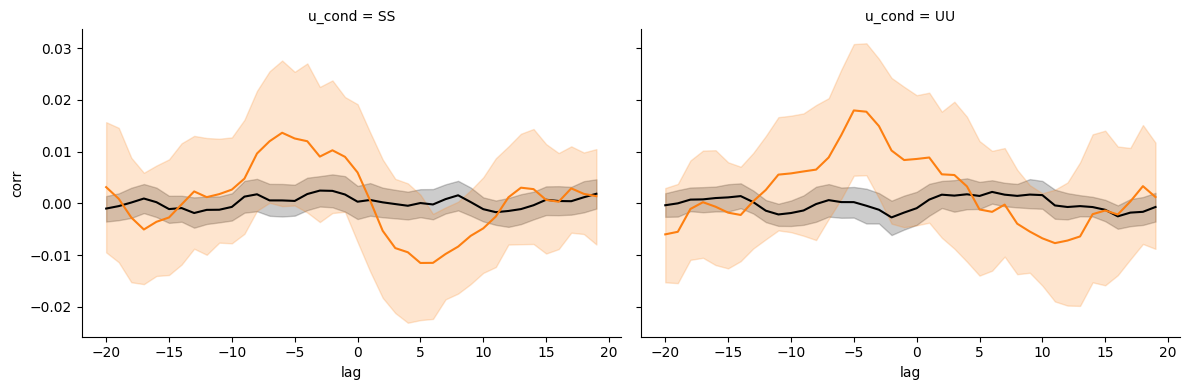

In [21]:
df_analysis = merge_df.filter(pl.col("u_cond") != "SU")

df_analysis = df_analysis.filter(pl.col("u_cond") != "US")

df_analysis = df_analysis.group_by(["sid", "user_id", "u_cond", "real_dyad", "lag"]).mean().to_pandas()

g = sns.relplot( x="lag",y="corr", col="u_cond",hue="real_dyad", kind="line", data=df_analysis
            , aspect=1.5, height=4
            , errorbar=('ci', 95)
            , legend = False
            , palette = ["#000000", "#FD7F11"]
            )

plt.savefig("plots/hr_lags_condition_with_surrogate_legend.pdf", bbox_inches='tight')
#g.set(xticklabels=[], yticklabels=[], title='',xlabel=None, ylabel=None)
#plt.savefig("plots/hr_lags_condition_with_surrogate.pdf", bbox_inches='tight')



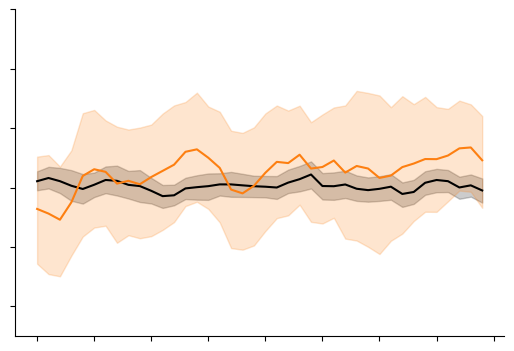

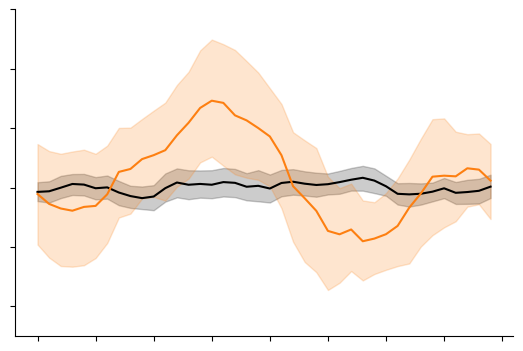

In [77]:
conditions = {"incongruent" : ["SU", "US"], "congruent" : ["SS", "UU"]} 

for condition in conditions:
    df_analysis = merge_df
    df_analysis = df_analysis.filter(pl.col("u_cond").is_in(conditions[condition]))
    
    df_analysis = df_analysis.group_by(["sid", "user_id", "real_dyad", "lag"]).mean().to_pandas()
    
    
    g = sns.relplot( x="lag",y="corr",hue="real_dyad", kind="line", data=df_analysis
                , aspect=1.5, height=4
                , errorbar=('ci', 95)
                , legend = False
                , palette = ["#000000", "#FD7F11"]
                )

    g.set(ylim=(-0.025, 0.03))    
    plt.savefig("plots/"+condition+"_hr_lags_condition_with_surrogate_legend.pdf", bbox_inches='tight')
    g.set(xticklabels=[], yticklabels=[], title='',xlabel=None, ylabel=None)
    plt.savefig("plots/"+condition+"hr_lags_condition_with_surrogate.pdf", bbox_inches='tight')
    


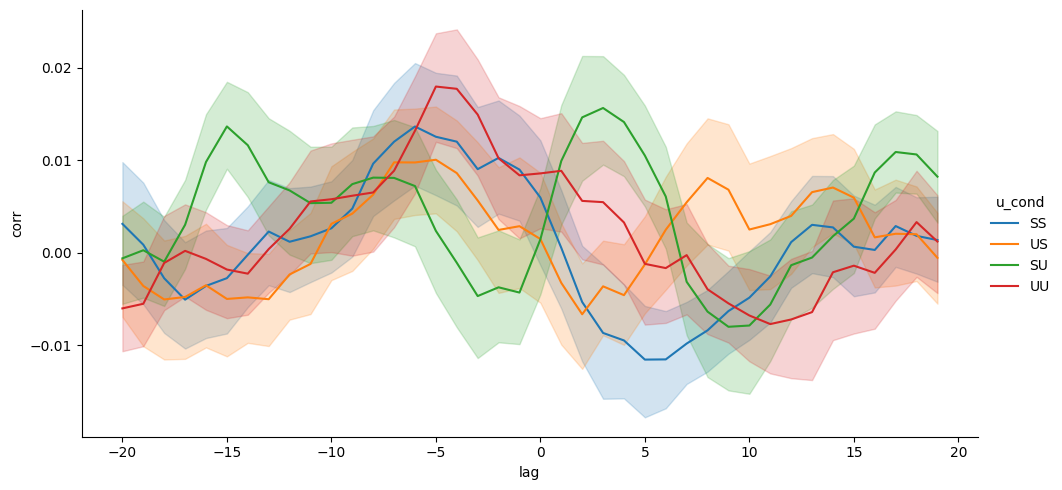

In [13]:
df_analysis = merge_df
#df_analysis = df_analysis.filter(pl.col("u_cond") != "SU")
#df_analysis = df_analysis.filter(pl.col("u_cond") != "US")
df_analysis = df_analysis.filter(pl.col("real_dyad") == True).to_pandas()

sns.relplot( x="lag",y="corr", hue="u_cond",kind="line", data=df_analysis, aspect=2)

-----------------------------------------
Analysing CONDITION: ['SS', 'UU']
Shape of data_true: (53, 40)
Shape of data_false: (54, 40)
stat_fun(H1): min=0.00011543441574040097 max=8.950412013608904
Running initial clustering …
Found 3 clusters


  0%|          | Permuting : 0/9999 [00:00<?,       ?it/s]

Raw clusters:
Cluster 1: (array([ 9, 10]),)
Cluster 2: (array([12, 13, 14, 15, 16, 17, 18, 19, 20]),)
Cluster 3: (array([26, 27, 28, 29, 30]),)
Significant clusters (p <= 0.05):
Cluster 2:
Indices: [12 13 14 15 16 17 18 19 20]
Lag range: -8 to 0
p-value: 0.0273


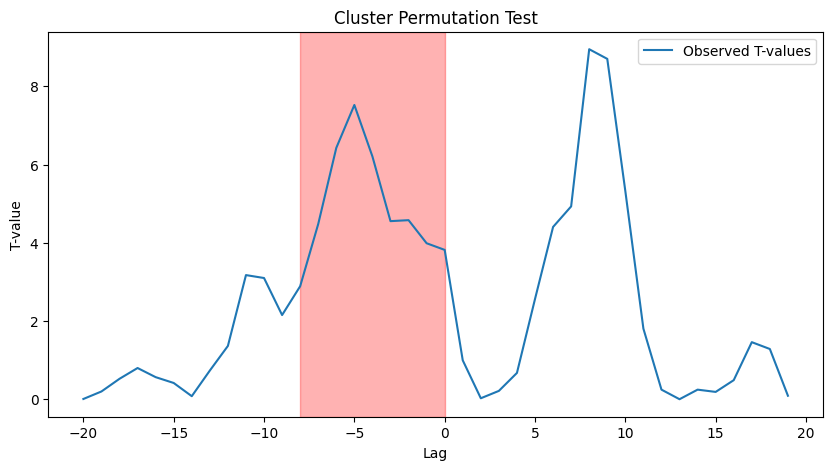

In [14]:
# Group and aggregate the data
df_analysis = merge_df

#condition = ["SU", "US"]
condition = ["SS", "UU"]

df_analysis = df_analysis.filter(pl.col("u_cond").is_in(condition))

df_analysis = df_analysis.group_by(["sid", "user_id", "real_dyad", "lag"]).mean().to_pandas()

# Pivot the data to have separate columns for True and False real_dyad
df_pivot = df_analysis.pivot_table(index=["sid", "user_id", "lag"], 
                                   columns="real_dyad", values="corr").reset_index()

# Rename the columns for clarity
df_pivot.columns = ['sid', 'user_id', 'lag', 'False', 'True']

# Prepare the data for mne
times = df_pivot['lag'].unique()

data_true = df_pivot[df_pivot['True'].notna()]['True'].values.reshape(-1, len(times))
data_false = df_pivot[df_pivot['False'].notna()]['False'].values.reshape(-1, len(times))

# Print shapes of the data arrays for debugging
print("-----------------------------------------")
print("Analysing CONDITION:", condition)
print("Shape of data_true:", data_true.shape)
print("Shape of data_false:", data_false.shape)

# Print data samples for initial lags
#print("Data at initial lags for True condition:", data_true[:, 0])
#print("Data at initial lags for False condition:", data_false[:, 0])

# Ensure the data is correctly reshaped
assert data_true.shape[1] == len(times), "Reshaping error for True data"
assert data_false.shape[1] == len(times), "Reshaping error for False data"

# Combine the data for the test
data = [data_true, data_false]

# Perform the cluster permutation test
T_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
    data, n_permutations=10000, threshold=2.842517, tail=1, n_jobs=1)

# Print the raw clusters
print("Raw clusters:")
for i, cluster in enumerate(clusters):
    print(f"Cluster {i+1}: {cluster}")

# Print the significant clusters with indices
print("Significant clusters (p <= 0.05):")
for i_c, c in enumerate(clusters):
    if cluster_p_values[i_c] <= 0.05:
        c_indices = c[0]  # Extract indices of the cluster
        print(f"Cluster {i_c + 1}:")
        print(f"Indices: {c_indices}")
        print(f"Lag range: {times[c_indices[0]]} to {times[c_indices[-1]]}")
        print(f"p-value: {cluster_p_values[i_c]}")

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(times, T_obs, label='Observed T-values')
plt.xlabel('Lag')
plt.ylabel('T-value')
plt.title('Cluster Permutation Test')

# Highlight significant clusters
for i_c, c in enumerate(clusters):
    if cluster_p_values[i_c] <= 0.05:
        c_indices = c[0]  # Extract indices of the cluster
        plt.axvspan(times[c_indices[0]], times[c_indices[-1]], color='r', alpha=0.3)

plt.legend()
plt.show()


#### Compare Time

#### Format data

In [22]:
behavior_df = pl.read_csv("data/behavior/all_data_df.csv")

behavior_df = behavior_df.with_columns(
    pl.col("sid").str.replace_all(":", "").alias("sid"),
    pl.col("user_id").str.replace_all(":", "").alias("user_id"),
    pl.col("other_id").str.replace_all(":", "").alias("other_id")
)

In [23]:
df_analysis = df_lags

df_analysis = df_analysis.filter(pl.col(["lag"]) > -10)
df_analysis = df_analysis.filter(pl.col(["lag"]) < 0)

df_analysis = df_analysis.group_by(["sid", "dyad", "user_id", "other_id", "real_dyad", "window"]).mean()
time_df = behavior_df.join(df_analysis, on=["user_id", "sid", "dyad", "other_id"])
time_df = time_df.with_columns(
    (pl.col("participant_condition") + pl.col("other_condition")).alias("u_cond")
)


In [24]:
time_df = time_df.write_csv("data/time_df.csv")

#### Analysis

In [36]:
time_df = pl.read_csv("data/time_df.csv")

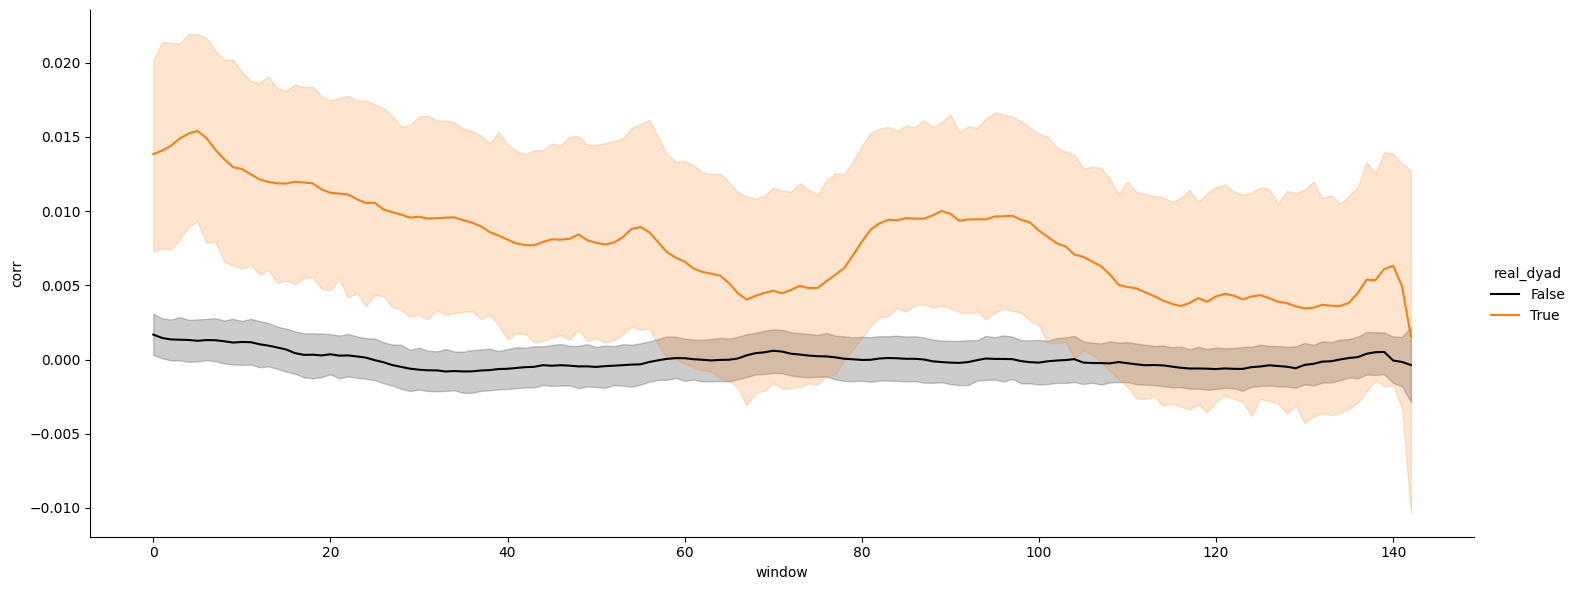

In [4]:
# Where in time is the effect?
df_analysis = time_df
df_analysis = df_analysis.group_by(["sid", "dyad", "user_id", "real_dyad", "window"]).mean().to_pandas()

sns.relplot(x="window", y="corr",hue="real_dyad", data=df_analysis, aspect=2.5
            , height=6, kind="line"
            , palette = ["#000000", "#FD7F11"]
           )

In [ ]:
# Where in time is the effect?
conditions = {"incongruent" : ["SU", "US"], "congruent" : ["SS", "UU"], "all"  : ["SS", "UU", "SU", "US"]} 

for condition in conditions.keys():
    df_analysis = time_df
    df_analysis = df_analysis.filter(pl.col("u_cond").is_in(conditions[condition]))
    df_analysis = df_analysis.group_by(["sid", "dyad", "user_id", "real_dyad", "window"]).mean().to_pandas()
    g = sns.relplot(x="window", y="corr",hue="real_dyad", data=df_analysis, aspect=1.3
                , height=3, kind="line"
                , palette = ["#000000", "#FD7F11"]
                , legend=False
               )

    g.set(ylim=(-0.025, 0.035))    
    plt.savefig("plots/"+condition+"time_with_surrogate_legend.pdf", bbox_inches='tight')
    g.set(xticklabels=[], yticklabels=[], title='',xlabel=None, ylabel=None)
    plt.savefig("plots/"+condition+"time_with_surrogate.pdf", bbox_inches='tight')

-----------------------------------------
Analysing CONDITION: ['SS', 'UU']
Shape of data_true: (54, 143)
Shape of data_false: (54, 143)
stat_fun(H1): min=0.5492189172996214 max=26.413091132743826
Running initial clustering …
Found 7 clusters


/tmp/ipykernel_30572/1081655355.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_pivot


  0%|          | Permuting : 0/9999 [00:00<?,       ?it/s]

Raw clusters:
Cluster 1: (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62]),)
Cluster 2: (array([82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92]),)
Cluster 3: (array([94, 95, 96, 97, 98]),)
Cluster 4: (array([102]),)
Cluster 5: (array([104, 105, 106, 107]),)
Cluster 6: (array([117]),)
Cluster 7: (array([138, 139, 140]),)
Significant clusters (p <= 0.05):
Cluster 1:
Indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62]
Lag range: 1 to 63
p-value: 0.0025


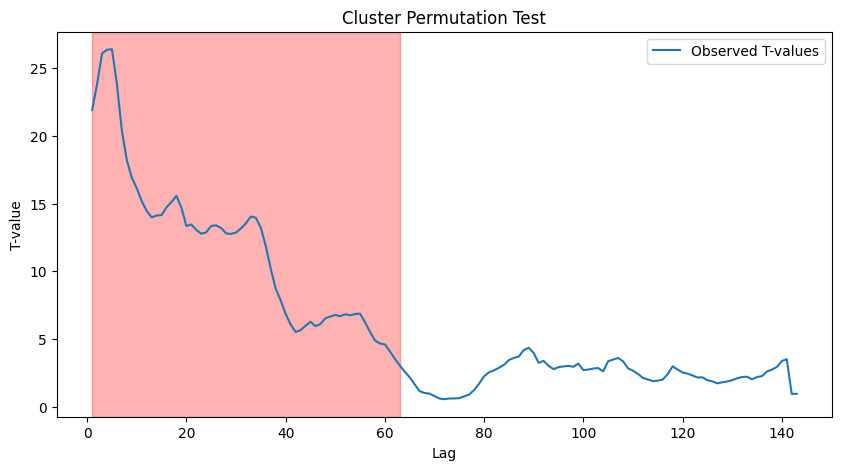

In [66]:
# Group and aggregate the data
df_analysis = time_df

#condition = ["SU", "US"]
#condition = ["SS", "UU"]
condition = ["SS", "UU", "SU", "US"]

df_analysis = df_analysis.filter(pl.col("u_cond").is_in(condition))

df_analysis = df_analysis.group_by(["sid", "user_id", "real_dyad", "window"]).mean().to_pandas()

# Pivot the data to have separate columns for True and False real_dyad
df_pivot = df_analysis.pivot_table(index=["sid", "user_id", "window"], 
                                   columns="real_dyad", values="corr").reset_index()
# Rename the columns for clarity
df_pivot.columns = ['sid', 'user_id', 'window', 'False', 'True']

#Deal with missing values
# Define the full range for reindexing (e.g., from 1 to 143)
full_range = pd.Index(range(1, 144))  # Adjust the range as necessary

# Reindex each group, fill missing values with NaN, then forward fill within each group
df_pivot = (
    df_pivot
    .groupby(["user_id"], as_index=False, group_keys=False)
    .apply(lambda group: group.set_index("window").reindex(full_range).rename_axis("window").ffill().reset_index())
)

# Prepare the data for mne
times = df_pivot['window'].unique()

df_pivot["True"] = df_pivot["True"].bfill()
df_pivot["True"] = df_pivot["True"].ffill()
df_pivot["False"] = df_pivot["False"].bfill()
df_pivot["False"] = df_pivot["False"].ffill()

data_true = df_pivot[df_pivot['True'].notna()]['True'].values.reshape(-1, len(times))
data_false = df_pivot[df_pivot['False'].notna()]['False'].values.reshape(-1, len(times))

# Print shapes of the data arrays for debugging
print("-----------------------------------------")
print("Analysing CONDITION:", condition)
print("Shape of data_true:", data_true.shape)
print("Shape of data_false:", data_false.shape)

# Print data samples for initial lags
#print("Data at initial lags for True condition:", data_true[:, 0])
#print("Data at initial lags for False condition:", data_false[:, 0])

# Ensure the data is correctly reshaped
assert data_true.shape[1] == len(times), "Reshaping error for True data"
assert data_false.shape[1] == len(times), "Reshaping error for False data"

# Combine the data for the test
data = [data_true, data_false]

# Perform the cluster permutation test
T_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
    data, n_permutations=10000, threshold=2.842517, tail=1, n_jobs=1)

# Print the raw clusters
print("Raw clusters:")
for i, cluster in enumerate(clusters):
    print(f"Cluster {i+1}: {cluster}")

# Print the significant clusters with indices
print("Significant clusters (p <= 0.05):")
for i_c, c in enumerate(clusters):
    if cluster_p_values[i_c] <= 0.05:
        c_indices = c[0]  # Extract indices of the cluster
        print(f"Cluster {i_c + 1}:")
        print(f"Indices: {c_indices}")
        print(f"Lag range: {times[c_indices[0]]} to {times[c_indices[-1]]}")
        print(f"p-value: {cluster_p_values[i_c]}")

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(times, T_obs, label='Observed T-values')
plt.xlabel('Lag')
plt.ylabel('T-value')
plt.title('Cluster Permutation Test')

# Highlight significant clusters
for i_c, c in enumerate(clusters):
    if cluster_p_values[i_c] <= 0.05:
        c_indices = c[0]  # Extract indices of the cluster
        plt.axvspan(times[c_indices[0]], times[c_indices[-1]], color='r', alpha=0.3)

plt.legend()
plt.show()
